# BERT's Attention and Dependency Syntax

This notebook contains code for comparing BERT's attention to dependency syntax annotations (see Sections 4.2 and 5 of [What Does BERT Look At? An Analysis of BERT's Attention](https://arxiv.org/abs/1906.04341))

In [37]:
import collections
import pickle
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

### Loading the data

Download the data used in this notebook from [here](https://drive.google.com/open?id=1DEIBQIl0Q0az5ZuLoy4_lYabIfLSKBg-). However, note that since Penn Treebank annotations are not public, this is dummy data where all labels are ROOT. See the README for extracting attention maps on your own data.

In [38]:
def load_pickle(fname):
    with open(fname, "rb") as f:
        return pickle.load(f, encoding="latin1")  # add, encoding="latin1") if using python3 and downloaded data

dev_data = load_pickle("dev_attn.pkl")

# The data consists of a list of examples (dicts)
# with the following keys/values
# {
#    "words": list of words in the sentence
#    "heads": index of each word"s syntactic head (0 for ROOT, 1 for the first 
#             word of the sentence, etc.)
#    "relns": the relation between each word and its head
#    "attns": [n_layers, n_heads, seq_len, seq_len] tensor of attention maps
#             from BERT
#}
print("words:", dev_data[0]["words"])
print("heads:", dev_data[0]["heads"])
print("relns:", dev_data[0]["relns"])
# Attention maps are 9x9 because [CLS] and [SEP] are added
print("attns: a tensor with shape", dev_data[0]["attns"].shape)

words: ['Influential', 'members', 'of', 'the', 'House', 'Ways', 'and', 'Means', 'Committee', 'introduced', 'legislation', 'that', 'would', 'restrict', 'how', 'the', 'new', 'savings-and-loan', 'bailout', 'agency', 'can', 'raise', 'capital', ',', 'creating', 'another', 'potential', 'obstacle', 'to', 'the', 'government', "'s", 'sale', 'of', 'sick', 'thrifts', '.']
heads: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
relns: ['root', 'root', 'root', 'root', 'root', 'root', 'root', 'root', 'root', 'root', 'root', 'root', 'root', 'root', 'root', 'root', 'root', 'root', 'root', 'root', 'root', 'root', 'root', 'root', 'root', 'root', 'root', 'root', 'root', 'root', 'root', 'root', 'root', 'root', 'root', 'root', 'root']
attns: a tensor with shape (12, 12, 39, 39)


In [39]:
def listwords_to_string(l):
    sentence = ''
    for i in range(len(l)):
        element = l[i]
        if i < len(l)-1:  
            if l[i+1] in [',', '.', '?', '!', '``', '\'s']:
                sentence += element
            else:
                sentence += element + ' '
    return sentence
t = listwords_to_string(dev_data[0]["words"])
t

"Influential members of the House Ways and Means Committee introduced legislation that would restrict how the new savings-and-loan bailout agency can raise capital, creating another potential obstacle to the government's sale of sick thrifts"

In [40]:
from transformers import AutoTokenizer, AutoModel, utils
from bertviz import model_view

model_name = "facebook/bart-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name, output_attentions=True)

# get encoded input vectors
encoder_input_ids = tokenizer(listwords_to_string(dev_data[0]["words"]))
outputs = model(input_ids=encoder_input_ids)

AttributeError: 

In [41]:
# Find the most common relations in our data
reln_counts = collections.Counter()
for example in dev_data:
    for reln in example["relns"]:
        reln_counts[reln] += 1
print(reln_counts.most_common(10))

[('root', 39901)]


In [47]:
el = np.array(list(reln_counts.elements()))
np.unique(el)

array(['root'], dtype='<U4')

# CANNOT USE THIS CODE

# Don't have all the dataset

# Only relation to ROOT 

### Evaluating individual heads at dependency syntax (Section 4.2)

In [65]:
# Code for evaluating individual attention maps and baselines

def evaluate_predictor(prediction_fn):
    n_correct, n_incorrect = collections.Counter(), collections.Counter()
    for example in dev_data:
        words = example["words"]
        predictions = prediction_fn(example)
        for i, (p, y, r) in enumerate(zip(predictions, example["heads"],
                                      example["relns"])):
            is_correct = (p == y)
            print(p, y)
            if r == "poss" and p < len(words):
            # Special case for poss (see discussion in Section 4.2)
                if i < len(words) and words[i + 1] == "'s" or words[i + 1] == "s'":
                    is_correct = (predictions[i + 1] == y)
                if is_correct:
                    n_correct[r] += 1
                    n_correct["all"] += 1
                else:
                    n_incorrect[r] += 1
                    n_incorrect["all"] += 1
    return {k: n_correct[k] / float(n_correct[k] + n_incorrect[k])
              for k in n_incorrect.keys()}

def attn_head_predictor(layer, head, mode="normal"):
        def predict(example):
            attn = np.array(example["attns"][layer][head])
            if mode == "transpose":
                attn = attn.T
            elif mode == "both":
                attn += attn.T
            else:
                assert mode == "normal"
        # ignore attention to self and [CLS]/[SEP] tokens
            attn[range(attn.shape[0]), range(attn.shape[0])] = 0
            attn = attn[1:-1, 1:-1]
            return np.argmax(attn, axis=-1) + 1  # +1 because ROOT is at index 0
        return predict

def offset_predictor(offset):
    def predict(example):
        return [max(0, min(i + offset + 1, len(example["words"])))
            for i in range(len(example["words"]))]
    return predict

def get_scores(mode="normal"):
    scores = collections.defaultdict(dict)
    for layer in range(12):
        for head in range(12):
            scores[layer][head] = evaluate_predictor(
              attn_head_predictor(layer, head, mode))
    return scores

# attn_head_scores[direction][layer][head][dep_relation] = accuracy
attn_head_scores = {
    "dep->head": get_scores("normal"),
    "head<-dep": get_scores("transpose")
}
# baseline_scores[offset][dep_relation] = accuracy
baseline_scores = {
    i: evaluate_predictor(offset_predictor(i)) for i in range(-3, 3)
}

18 0
18 0
18 0
18 0
18 0
18 0
18 0
18 0
18 0
18 0
18 0
18 0
18 0
18 0
18 0
18 0
18 0
36 0
36 0
18 0
18 0
18 0
18 0
18 0
18 0
18 0
18 0
36 0
18 0
18 0
18 0
18 0
19 0
18 0
18 0
18 0
18 0
10 0
30 0
14 0
5 0
10 0
30 0
30 0
14 0
14 0
9 0
30 0
14 0
30 0
38 0
14 0
30 0
30 0
10 0
30 0
9 0
30 0
10 0
30 0
9 0
30 0
30 0
10 0
30 0
10 0
9 0
9 0
10 0
30 0
30 0
14 0
10 0
14 0
30 0
9 0
2 0
10 0
10 0
9 0
30 0
10 0
10 0
7 0
18 0
8 0
3 0
4 0
9 0
4 0
7 0
18 0
4 0
10 0
3 0
7 0
7 0
3 0
2 0
10 0
7 0
4 0
24 0
26 0
24 0
24 0
1 0
30 0
1 0
21 0
30 0
26 0
1 0
5 0
30 0
1 0
1 0
26 0
24 0
24 0
1 0
5 0
30 0
30 0
30 0
1 0
24 0
1 0
24 0
5 0
30 0
1 0
5 0
5 0
30 0
30 0
1 0
5 0
30 0
8 0
3 0
8 0
7 0
7 0
8 0
10 0
14 0
12 0
8 0
7 0
7 0
7 0
7 0
7 0
7 0
7 0
7 0
8 0
11 0
7 0
3 0
7 0
15 0
15 0
2 0
15 0
15 0
12 0
15 0
2 0
2 0
15 0
2 0
15 0
2 0
15 0
2 0
15 0
15 0
2 0
15 0
15 0
2 0
12 0
8 0
9 0
5 0
5 0
7 0
5 0
5 0
11 0
2 0
9 0
8 0
5 0
3 0
16 0
9 0
9 0
8 0
16 0
6 0
6 0
18 0
8 0
16 0
6 0
16 0
6 0
6 0
6 0
6 0
16 0
6 0
6 0
3 0
6 0
6 0


14 0
13 0
18 0
18 0
14 0
14 0
18 0
14 0
18 0
21 0
18 0
21 0
18 0
21 0
18 0
14 0
21 0
12 0
14 0
18 0
18 0
18 0
14 0
14 0
14 0
14 0
18 0
14 0
18 0
14 0
6 0
9 0
6 0
9 0
2 0
2 0
2 0
5 0
8 0
2 0
16 0
16 0
7 0
16 0
16 0
16 0
27 0
16 0
16 0
36 0
16 0
16 0
27 0
16 0
36 0
27 0
16 0
36 0
16 0
36 0
36 0
36 0
16 0
36 0
36 0
16 0
36 0
27 0
16 0
36 0
27 0
7 0
36 0
7 0
36 0
27 0
27 0
16 0
16 0
7 0
16 0
16 0
16 0
16 0
16 0
16 0
25 0
16 0
16 0
36 0
25 0
16 0
12 0
12 0
12 0
12 0
16 0
12 0
12 0
12 0
12 0
12 0
12 0
39 0
12 0
12 0
12 0
15 0
12 0
12 0
12 0
12 0
12 0
12 0
12 0
12 0
12 0
12 0
15 0
12 0
12 0
12 0
12 0
12 0
12 0
12 0
12 0
12 0
12 0
12 0
12 0
12 0
12 0
12 0
13 0
6 0
16 0
17 0
6 0
12 0
13 0
16 0
16 0
13 0
13 0
13 0
16 0
13 0
17 0
7 0
13 0
6 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
9 0
2 0
1 0
1 0
1 0
1 0
2 0
3 0
5 0
3 0
3 0
24 0
24 0
23 0
24 0
24 0
24 0
24 0
24 0
24 0
24 0
24 0
24 0
24 0
24 0
24 0
24 0
24 0
24 0
24 0
24 0
24 0
24 0
24 0
20 0
24 0
24 0
24 0
24 0
24 0
24 0
24 0
24 0
24 0
5 0
5 0
5 0
5 0
8

1 0
1 0
23 0
16 0
1 0
1 0
15 0
17 0
1 0
1 0
1 0
1 0
16 0
1 0
1 0
17 0
8 0
1 0
10 0
1 0
1 0
1 0
9 0
7 0
9 0
9 0
8 0
9 0
9 0
9 0
8 0
2 0
3 0
13 0
2 0
3 0
3 0
3 0
2 0
3 0
2 0
2 0
3 0
3 0
3 0
2 0
3 0
3 0
16 0
2 0
3 0
3 0
3 0
3 0
3 0
3 0
3 0
3 0
3 0
29 0
28 0
29 0
12 0
28 0
29 0
19 0
28 0
29 0
38 0
15 0
15 0
28 0
28 0
29 0
29 0
29 0
28 0
12 0
29 0
16 0
29 0
28 0
29 0
12 0
12 0
16 0
14 0
15 0
16 0
12 0
19 0
16 0
29 0
29 0
29 0
14 0
29 0
28 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
2 0
8 0
25 0
6 0
11 0
19 0
25 0
25 0
14 0
25 0
7 0
11 0
14 0
13 0
11 0
11 0
13 0
13 0
18 0
11 0
7 0
25 0
7 0
7 0
7 0
25 0
11 0
25 0
11 0
11 0
11 0
11 0
11 0
11 0
5 0
11 0
5 0
11 0
1 0
11 0
11 0
11 0
5 0
11 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
10 0
9 0
9 0
9 0
28 0
14 0
1 0
8 0
20 0
20 0
20 0
20 0
1 0
20 0
3 0
20 0
20 0
20 0
3 0
20 0
14 0
14 0
14 0
1 0
1 0
15 0
1 0
1 0
4 0
1 0
20 0
20 0
20 0
10 0
7 0
7 0
10 0
12 0
10 0
3 0
7 0
10 0
6 0
7 0
11 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
13 0
12 0
8 0
8 0
6 0
8 0
9 0
9 0
14 0
10 0
9 0
9 0
4 0
10 

18 0
17 0
17 0
16 0
17 0
11 0
17 0
17 0
17 0
17 0
17 0
17 0
3 0
17 0
17 0
4 0
6 0
17 0
15 0
1 0
15 0
15 0
15 0
1 0
1 0
1 0
1 0
1 0
1 0
15 0
1 0
1 0
5 0
5 0
15 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
15 0
15 0
5 0
1 0
1 0
1 0
1 0
1 0
2 0
1 0
1 0
2 0
1 0
40 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
21 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
39 0
1 0
1 0
9 0
2 0
1 0
1 0
1 0
1 0
1 0
1 0
21 0
1 0
1 0
1 0
40 0
1 0
1 0
1 0
1 0
1 0
1 0
21 0
1 0
16 0
16 0
16 0
29 0
16 0
29 0
16 0
16 0
30 0
16 0
8 0
16 0
16 0
16 0
16 0
30 0
29 0
16 0
16 0
29 0
16 0
16 0
16 0
9 0
16 0
16 0
29 0
16 0
16 0
16 0
16 0
30 0
16 0
8 0
8 0
8 0
8 0
8 0
8 0
4 0
4 0
8 0
4 0
8 0
3 0
9 0
9 0
3 0
9 0
9 0
3 0
3 0
14 0
9 0
9 0
3 0
3 0
9 0
3 0
3 0
3 0
14 0
7 0
7 0
7 0
7 0
7 0
3 0
7 0
7 0
7 0
7 0
7 0
7 0
7 0
14 0
7 0
7 0
7 0
8 0
23 0
8 0
23 0
16 0
23 0
23 0
16 0
23 0
23 0
23 0
23 0
8 0
23 0
8 0
8 0
8 0
4 0
23 0
23 0
9 0
23 0
19 0
19 0
16 0
23 0
18 0
18 0
12 0
18 0
8 0
3 0
18 0
13 0
18 0
18 0
18 0
3 0
18 0
18 0
18 0
18 0
3 0
13 0
18 0
4 0
4 0
4 0
15 0
16 0
4 

15 0
15 0
15 0
15 0
15 0
15 0
15 0
12 0
16 0
23 0
16 0
23 0
16 0
23 0
23 0
23 0
23 0
23 0
23 0
23 0
12 0
23 0
24 0
23 0
23 0
23 0
23 0
23 0
23 0
23 0
6 0
23 0
23 0
23 0
23 0
23 0
23 0
23 0
23 0
7 0
23 0
42 0
23 0
23 0
12 0
23 0
23 0
23 0
23 0
36 0
23 0
23 0
23 0
16 0
20 0
16 0
20 0
20 0
20 0
20 0
20 0
20 0
20 0
16 0
20 0
20 0
20 0
14 0
20 0
20 0
20 0
20 0
5 0
20 0
20 0
16 0
20 0
20 0
20 0
20 0
20 0
20 0
20 0
16 0
20 0
20 0
20 0
20 0
16 0
16 0
20 0
20 0
20 0
20 0
20 0
16 0
8 0
27 0
20 0
27 0
20 0
27 0
27 0
27 0
6 0
20 0
27 0
27 0
20 0
27 0
27 0
20 0
27 0
20 0
27 0
35 0
27 0
20 0
27 0
20 0
27 0
20 0
6 0
27 0
27 0
27 0
27 0
6 0
27 0
8 0
20 0
27 0
20 0
27 0
6 0
20 0
27 0
27 0
20 0
27 0
27 0
20 0
20 0
27 0
27 0
6 0
20 0
2 0
5 0
2 0
8 0
17 0
12 0
5 0
2 0
12 0
12 0
12 0
2 0
12 0
8 0
3 0
12 0
2 0
2 0
5 0
8 0
8 0
18 0
24 0
8 0
18 0
24 0
17 0
17 0
17 0
24 0
8 0
24 0
25 0
18 0
6 0
1 0
24 0
7 0
1 0
1 0
24 0
17 0
24 0
1 0
17 0
7 0
16 0
24 0
32 0
25 0
2 0
2 0
2 0
29 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
25 

22 0
22 0
22 0
22 0
10 0
10 0
10 0
10 0
22 0
10 0
20 0
10 0
20 0
10 0
20 0
20 0
20 0
10 0
10 0
22 0
10 0
10 0
20 0
20 0
10 0
10 0
20 0
22 0
10 0
17 0
10 0
10 0
22 0
22 0
10 0
16 0
16 0
8 0
12 0
18 0
8 0
13 0
18 0
8 0
8 0
8 0
18 0
8 0
13 0
8 0
4 0
18 0
8 0
13 0
8 0
13 0
12 0
11 0
7 0
17 0
17 0
6 0
10 0
11 0
7 0
7 0
7 0
3 0
11 0
9 0
10 0
7 0
7 0
7 0
11 0
11 0
7 0
10 0
28 0
28 0
28 0
28 0
28 0
28 0
28 0
16 0
28 0
7 0
28 0
28 0
28 0
16 0
12 0
28 0
28 0
15 0
28 0
3 0
28 0
28 0
28 0
28 0
15 0
28 0
18 0
7 0
28 0
28 0
3 0
12 0
12 0
12 0
28 0
10 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
24 0
24 0
24 0
24 0
24 0
24 0
24 0
24 0
24 0
24 0
24 0
24 0
24 0
24 0
24 0
24 0
24 0
24 0
13 0
24 0
24 0
21 0
24 0
5 0
4 0
8 0
8 0
8 0
3 0
9 0
8 0
6 0
10 0
8 0
2 0
12 0
1 0
1 0
2 0
1 0
2 0
2 0
2 0
6 0
2 0
2 0
1 0
2 0
2 0
18 0
2 0
10 0
2 0
2 0
10 0
2 0
22 0
2 0
2 0
2 0
6 0
1 0
10 0
11 0
11 0
10 0
10 0
10 0
10 0
10 0
10 0
3 0
10 0
10 0
27 0
27 0
27 0
27 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
30 

8 0
8 0
18 0
8 0
8 0
8 0
9 0
8 0
9 0
9 0
8 0
8 0
8 0
8 0
8 0
9 0
8 0
9 0
8 0
8 0
15 0
15 0
15 0
15 0
14 0
15 0
15 0
15 0
15 0
15 0
16 0
15 0
16 0
15 0
7 0
15 0
15 0
15 0
7 0
15 0
15 0
11 0
17 0
11 0
9 0
9 0
11 0
16 0
11 0
16 0
11 0
23 0
16 0
9 0
11 0
11 0
11 0
11 0
4 0
11 0
11 0
16 0
16 0
11 0
12 0
16 0
8 0
16 0
8 0
4 0
4 0
5 0
4 0
1 0
4 0
3 0
18 0
18 0
18 0
31 0
1 0
1 0
1 0
18 0
1 0
18 0
18 0
18 0
20 0
28 0
18 0
18 0
1 0
1 0
1 0
28 0
1 0
8 0
12 0
1 0
1 0
1 0
1 0
1 0
28 0
28 0
1 0
10 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
3 0
1 0
1 0
1 0
1 0
1 0
3 0
1 0
2 0
3 0
1 0
1 0
6 0
8 0
8 0
8 0
6 0
4 0
18 0
2 0
6 0
6 0
4 0
2 0
6 0
18 0
4 0
9 0
4 0
2 0
12 0
12 0
14 0
20 0
4 0
22 0
18 0
22 0
22 0
4 0
12 0
3 0
4 0
22 0
4 0
18 0
3 0
7 0
4 0
22 0
12 0
3 0
14 0
22 0
22 0
4 0
22 0
22 0
4 0
26 0
26 0
17 0
26 0
26 0
26 0
26 0
26 0
26 0
26 0
26 0
26 0
26 0
23 0
26 0
17 0
26 0
26 0
26 0
26 0
26 0
26 0
26 0
26 0
26 0
11 0
26 0
26 0
11 0
11 0
11 0
5 0
4 0
11 0
11 0
11 0
11 0
12 0
8 0
11 0
7 0
7 0


6 0
11 0
11 0
6 0
11 0
11 0
11 0
11 0
13 0
13 0
7 0
11 0
11 0
11 0
13 0
11 0
11 0
13 0
11 0
3 0
18 0
28 0
3 0
3 0
3 0
3 0
3 0
3 0
3 0
3 0
27 0
3 0
3 0
3 0
3 0
3 0
9 0
3 0
3 0
3 0
3 0
3 0
3 0
3 0
5 0
12 0
3 0
3 0
3 0
25 0
25 0
25 0
10 0
10 0
25 0
27 0
10 0
10 0
38 0
10 0
25 0
38 0
10 0
10 0
25 0
10 0
25 0
10 0
25 0
10 0
30 0
10 0
10 0
38 0
10 0
38 0
38 0
25 0
38 0
10 0
10 0
10 0
10 0
10 0
10 0
10 0
10 0
10 0
10 0
38 0
10 0
13 0
3 0
12 0
12 0
3 0
13 0
3 0
3 0
3 0
12 0
12 0
3 0
12 0
19 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
19 0
1 0
1 0
2 0
1 0
1 0
19 0
1 0
1 0
1 0
1 0
1 0
3 0
14 0
14 0
14 0
13 0
10 0
14 0
7 0
16 0
6 0
13 0
14 0
14 0
5 0
11 0
14 0
8 0
1 0
8 0
1 0
1 0
1 0
1 0
1 0
8 0
6 0
11 0
6 0
7 0
7 0
4 0
1 0
6 0
13 0
3 0
6 0
7 0
4 0
8 0
9 0
15 0
15 0
4 0
4 0
4 0
18 0
4 0
4 0
4 0
4 0
4 0
4 0
4 0
4 0
9 0
4 0
4 0
4 0
4 0
4 0
2 0
19 0
2 0
15 0
2 0
2 0
2 0
22 0
2 0
15 0
2 0
2 0
15 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
15 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
4 0
19 0
4 0
14 0
6 0
5 0
4 0
4 0
4 0
4 0
4 0
4 0

37 0
12 0
12 0
12 0
1 0
12 0
12 0
12 0
12 0
1 0
12 0
12 0
12 0
12 0
12 0
12 0
12 0
12 0
1 0
12 0
12 0
7 0
4 0
13 0
6 0
16 0
4 0
13 0
13 0
3 0
13 0
13 0
7 0
7 0
3 0
10 0
7 0
4 0
13 0
2 0
16 0
31 0
31 0
24 0
30 0
31 0
31 0
26 0
26 0
6 0
31 0
12 0
30 0
32 0
2 0
6 0
3 0
24 0
32 0
12 0
6 0
3 0
6 0
3 0
5 0
6 0
3 0
31 0
31 0
31 0
6 0
1 0
6 0
26 0
26 0
21 0
34 0
21 0
27 0
21 0
2 0
1 0
1 0
26 0
26 0
37 0
26 0
1 0
1 0
37 0
37 0
34 0
1 0
3 0
37 0
37 0
37 0
1 0
35 0
37 0
37 0
26 0
1 0
37 0
35 0
1 0
1 0
2 0
2 0
1 0
1 0
34 0
8 0
27 0
27 0
8 0
4 0
3 0
8 0
32 0
19 0
1 0
32 0
32 0
27 0
32 0
1 0
32 0
30 0
6 0
9 0
1 0
3 0
17 0
32 0
2 0
8 0
27 0
32 0
6 0
28 0
17 0
2 0
17 0
8 0
3 0
10 0
4 0
3 0
10 0
3 0
3 0
10 0
5 0
8 0
8 0
10 0
5 0
8 0
10 0
10 0
14 0
6 0
2 0
14 0
14 0
14 0
3 0
12 0
14 0
14 0
14 0
14 0
14 0
10 0
14 0
12 0
12 0
12 0
12 0
12 0
12 0
12 0
12 0
12 0
12 0
12 0
10 0
12 0
12 0
12 0
13 0
13 0
13 0
13 0
13 0
13 0
13 0
3 0
13 0
13 0
3 0
13 0
5 0
12 0
13 0
13 0
13 0
13 0
13 0
2 0
7 0
2 0
2 0
2 0
2 0
2

25 0
25 0
25 0
25 0
27 0
25 0
25 0
9 0
8 0
9 0
8 0
25 0
25 0
8 0
9 0
25 0
9 0
9 0
9 0
9 0
9 0
25 0
25 0
25 0
9 0
25 0
9 0
25 0
9 0
9 0
9 0
27 0
9 0
21 0
25 0
24 0
24 0
1 0
24 0
24 0
24 0
24 0
24 0
2 0
15 0
24 0
15 0
2 0
1 0
24 0
1 0
35 0
24 0
24 0
24 0
24 0
1 0
24 0
1 0
2 0
2 0
1 0
24 0
24 0
24 0
2 0
24 0
15 0
3 0
24 0
24 0
2 0
10 0
21 0
1 0
1 0
8 0
1 0
10 0
1 0
1 0
1 0
1 0
1 0
5 0
1 0
1 0
1 0
1 0
1 0
10 0
1 0
1 0
1 0
1 0
1 0
4 0
5 0
4 0
9 0
4 0
7 0
2 0
7 0
5 0
5 0
5 0
14 0
13 0
13 0
13 0
7 0
13 0
27 0
17 0
13 0
13 0
13 0
13 0
14 0
7 0
14 0
13 0
27 0
13 0
8 0
13 0
13 0
13 0
27 0
14 0
13 0
8 0
7 0
13 0
14 0
13 0
13 0
13 0
11 0
7 0
7 0
7 0
7 0
7 0
11 0
7 0
8 0
7 0
7 0
7 0
18 0
7 0
7 0
7 0
13 0
7 0
17 0
7 0
12 0
7 0
9 0
7 0
5 0
7 0
7 0
7 0
4 0
7 0
4 0
7 0
7 0
9 0
9 0
9 0
9 0
3 0
3 0
6 0
6 0
3 0
9 0
9 0
6 0
8 0
6 0
3 0
6 0
6 0
6 0
9 0
6 0
9 0
9 0
6 0
6 0
24 0
24 0
24 0
24 0
24 0
24 0
23 0
24 0
7 0
7 0
7 0
24 0
6 0
6 0
6 0
24 0
6 0
24 0
6 0
6 0
24 0
24 0
24 0
3 0
21 0
4 0
4 0
16 0
6 0
16 0


29 0
33 0
31 0
31 0
33 0
11 0
4 0
4 0
33 0
11 0
11 0
10 0
11 0
33 0
33 0
11 0
31 0
33 0
11 0
11 0
31 0
4 0
33 0
11 0
31 0
11 0
4 0
23 0
13 0
11 0
29 0
11 0
33 0
11 0
33 0
11 0
14 0
12 0
12 0
16 0
11 0
5 0
5 0
5 0
5 0
5 0
4 0
1 0
5 0
8 0
16 0
5 0
5 0
16 0
9 0
17 0
5 0
14 0
5 0
8 0
5 0
6 0
6 0
7 0
3 0
3 0
3 0
1 0
3 0
3 0
3 0
3 0
7 0
3 0
3 0
7 0
3 0
3 0
3 0
3 0
18 0
8 0
8 0
8 0
16 0
3 0
4 0
20 0
20 0
3 0
19 0
4 0
3 0
3 0
3 0
19 0
4 0
4 0
5 0
8 0
8 0
3 0
5 0
4 0
6 0
3 0
4 0
13 0
19 0
4 0
15 0
4 0
18 0
30 0
15 0
13 0
15 0
31 0
13 0
18 0
9 0
4 0
9 0
28 0
9 0
13 0
9 0
3 0
9 0
9 0
13 0
4 0
1 0
18 0
9 0
2 0
1 0
6 0
4 0
3 0
9 0
15 0
15 0
15 0
11 0
15 0
15 0
15 0
5 0
15 0
15 0
21 0
15 0
14 0
15 0
2 0
15 0
15 0
15 0
14 0
15 0
8 0
21 0
5 0
15 0
18 0
8 0
15 0
20 0
37 0
10 0
33 0
3 0
30 0
15 0
33 0
2 0
3 0
20 0
33 0
20 0
20 0
16 0
15 0
3 0
20 0
33 0
3 0
9 0
10 0
10 0
3 0
3 0
20 0
33 0
20 0
3 0
20 0
20 0
9 0
20 0
20 0
3 0
33 0
3 0
33 0
5 0
6 0
1 0
8 0
1 0
8 0
5 0
4 0
18 0
6 0
7 0
7 0
6 0
24 0
18 0
29 

12 0
1 0
12 0
1 0
1 0
1 0
2 0
1 0
3 0
8 0
5 0
5 0
3 0
8 0
3 0
5 0
3 0
7 0
8 0
23 0
23 0
23 0
23 0
23 0
23 0
3 0
3 0
3 0
14 0
3 0
3 0
23 0
23 0
14 0
2 0
3 0
14 0
3 0
3 0
14 0
23 0
14 0
14 0
3 0
12 0
5 0
12 0
12 0
13 0
5 0
12 0
9 0
12 0
5 0
2 0
9 0
12 0
12 0
10 0
10 0
21 0
18 0
3 0
3 0
24 0
3 0
24 0
24 0
3 0
10 0
4 0
10 0
10 0
3 0
10 0
3 0
3 0
24 0
10 0
24 0
4 0
10 0
3 0
24 0
12 0
1 0
4 0
1 0
1 0
1 0
1 0
11 0
1 0
1 0
10 0
1 0
1 0
1 0
11 0
7 0
25 0
7 0
7 0
7 0
20 0
7 0
7 0
7 0
20 0
7 0
11 0
11 0
7 0
7 0
7 0
7 0
7 0
7 0
7 0
7 0
11 0
7 0
7 0
3 0
20 0
11 0
11 0
7 0
10 0
10 0
24 0
25 0
10 0
10 0
10 0
10 0
10 0
19 0
10 0
6 0
6 0
6 0
10 0
10 0
3 0
10 0
10 0
10 0
10 0
6 0
10 0
10 0
6 0
6 0
6 0
6 0
10 0
5 0
5 0
5 0
2 0
1 0
13 0
1 0
2 0
2 0
2 0
14 0
9 0
2 0
2 0
1 0
4 0
1 0
1 0
4 0
8 0
8 0
8 0
9 0
9 0
8 0
8 0
13 0
13 0
8 0
5 0
9 0
12 0
8 0
8 0
13 0
13 0
19 0
13 0
13 0
13 0
13 0
13 0
13 0
13 0
13 0
13 0
19 0
13 0
13 0
13 0
13 0
13 0
13 0
19 0
13 0
5 0
5 0
5 0
5 0
2 0
5 0
5 0
12 0
12 0
2 0
12 0
13 0


3 0
23 0
23 0
23 0
23 0
3 0
23 0
23 0
23 0
23 0
3 0
11 0
23 0
23 0
8 0
23 0
19 0
19 0
24 0
18 0
24 0
19 0
21 0
18 0
24 0
24 0
24 0
21 0
1 0
24 0
6 0
21 0
18 0
24 0
18 0
19 0
9 0
9 0
9 0
18 0
24 0
21 0
6 0
6 0
15 0
6 0
16 0
16 0
12 0
15 0
2 0
16 0
18 0
20 0
6 0
6 0
6 0
2 0
2 0
6 0
6 0
6 0
15 0
11 0
22 0
12 0
3 0
11 0
8 0
3 0
11 0
11 0
12 0
12 0
11 0
11 0
3 0
3 0
3 0
3 0
11 0
3 0
5 0
3 0
11 0
8 0
3 0
3 0
8 0
13 0
8 0
8 0
8 0
8 0
15 0
13 0
8 0
8 0
8 0
8 0
15 0
8 0
8 0
15 0
2 0
10 0
9 0
1 0
1 0
2 0
5 0
1 0
3 0
3 0
1 0
21 0
5 0
21 0
5 0
15 0
21 0
21 0
5 0
5 0
15 0
18 0
21 0
2 0
18 0
5 0
21 0
18 0
2 0
21 0
23 0
2 0
5 0
21 0
2 0
23 0
18 0
21 0
15 0
15 0
20 0
15 0
8 0
3 0
11 0
15 0
15 0
11 0
14 0
3 0
15 0
3 0
21 0
15 0
15 0
15 0
15 0
3 0
15 0
15 0
3 0
3 0
6 0
3 0
3 0
3 0
6 0
3 0
2 0
6 0
3 0
3 0
3 0
6 0
3 0
6 0
6 0
6 0
6 0
4 0
4 0
4 0
5 0
4 0
4 0
4 0
4 0
4 0
4 0
9 0
11 0
13 0
9 0
13 0
9 0
9 0
9 0
13 0
9 0
9 0
9 0
9 0
9 0
6 0
6 0
6 0
6 0
9 0
9 0
6 0
6 0
6 0
6 0
6 0
9 0
6 0
6 0
6 0
6 0
6 0
13 0
1

10 0
10 0
20 0
10 0
9 0
9 0
28 0
9 0
4 0
9 0
28 0
9 0
28 0
28 0
28 0
28 0
9 0
28 0
4 0
9 0
9 0
26 0
28 0
28 0
9 0
9 0
9 0
4 0
9 0
28 0
4 0
9 0
4 0
9 0
28 0
12 0
3 0
9 0
9 0
23 0
9 0
3 0
9 0
4 0
15 0
12 0
11 0
4 0
17 0
4 0
4 0
4 0
4 0
15 0
4 0
4 0
15 0
12 0
15 0
4 0
16 0
1 0
1 0
18 0
1 0
17 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
19 0
1 0
1 0
19 0
1 0
1 0
1 0
1 0
19 0
21 0
21 0
21 0
21 0
21 0
21 0
21 0
21 0
19 0
21 0
21 0
21 0
21 0
21 0
21 0
21 0
21 0
21 0
21 0
18 0
18 0
18 0
19 0
3 0
21 0
21 0
21 0
21 0
21 0
21 0
21 0
21 0
21 0
21 0
21 0
4 0
4 0
4 0
14 0
4 0
4 0
4 0
4 0
4 0
4 0
16 0
18 0
4 0
4 0
4 0
4 0
4 0
4 0
4 0
30 0
4 0
12 0
7 0
7 0
28 0
14 0
4 0
4 0
8 0
9 0
7 0
3 0
6 0
8 0
14 0
8 0
3 0
4 0
14 0
8 0
7 0
14 0
14 0
3 0
14 0
8 0
29 0
3 0
14 0
28 0
8 0
3 0
28 0
8 0
4 0
4 0
4 0
25 0
10 0
10 0
25 0
4 0
4 0
4 0
32 0
4 0
4 0
4 0
4 0
4 0
29 0
4 0
4 0
4 0
4 0
4 0
4 0
4 0
4 0
4 0
4 0
4 0
17 0
4 0
21 0
4 0
4 0
4 0
4 0
20 0
19 0
20 0
17 0
20 0
20 0
30 0
15 0
20 0
12 0
7 0
30 0
20 0
30 0
30 0
20 0
12 0
8 

14 0
4 0
14 0
29 0
24 0
24 0
4 0
14 0
29 0
4 0
14 0
4 0
14 0
29 0
24 0
14 0
4 0
14 0
29 0
4 0
14 0
4 0
14 0
29 0
9 0
3 0
3 0
1 0
1 0
1 0
3 0
3 0
1 0
3 0
1 0
3 0
3 0
3 0
3 0
1 0
3 0
26 0
26 0
3 0
3 0
30 0
3 0
3 0
3 0
3 0
30 0
30 0
30 0
63 0
3 0
60 0
3 0
63 0
60 0
3 0
3 0
60 0
60 0
63 0
3 0
60 0
60 0
63 0
60 0
3 0
3 0
60 0
3 0
63 0
3 0
60 0
60 0
63 0
60 0
3 0
3 0
60 0
3 0
3 0
3 0
60 0
20 0
3 0
20 0
3 0
26 0
26 0
3 0
3 0
3 0
26 0
26 0
3 0
26 0
3 0
26 0
7 0
7 0
5 0
3 0
22 0
2 0
22 0
7 0
22 0
22 0
3 0
7 0
7 0
7 0
22 0
22 0
3 0
10 0
5 0
7 0
22 0
28 0
5 0
28 0
7 0
7 0
22 0
10 0
5 0
7 0
7 0
7 0
16 0
16 0
15 0
12 0
15 0
5 0
15 0
16 0
16 0
16 0
16 0
2 0
12 0
16 0
16 0
4 0
16 0
17 0
4 0
6 0
15 0
5 0
13 0
5 0
6 0
21 0
18 0
6 0
6 0
3 0
6 0
6 0
6 0
3 0
6 0
6 0
6 0
3 0
6 0
6 0
6 0
5 0
6 0
6 0
6 0
8 0
5 0
5 0
8 0
11 0
8 0
5 0
5 0
4 0
5 0
5 0
5 0
5 0
5 0
5 0
17 0
17 0
16 0
9 0
16 0
16 0
16 0
17 0
17 0
38 0
17 0
38 0
17 0
17 0
17 0
17 0
34 0
17 0
17 0
17 0
17 0
17 0
17 0
2 0
17 0
17 0
16 0
17 0
9 0
17 0

24 0
24 0
24 0
24 0
24 0
24 0
24 0
24 0
24 0
24 0
24 0
24 0
24 0
24 0
24 0
24 0
24 0
24 0
24 0
24 0
24 0
24 0
24 0
31 0
24 0
24 0
5 0
24 0
24 0
24 0
24 0
24 0
13 0
24 0
24 0
24 0
5 0
24 0
5 0
24 0
24 0
24 0
24 0
24 0
24 0
24 0
24 0
24 0
24 0
24 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
2 0
9 0
9 0
9 0
9 0
22 0
22 0
22 0
7 0
22 0
22 0
5 0
22 0
7 0
22 0
22 0
2 0
22 0
22 0
22 0
7 0
7 0
22 0
22 0
22 0
7 0
7 0
7 0
22 0
22 0
19 0
19 0
14 0
22 0
22 0
7 0
22 0
22 0
22 0
22 0
22 0
2 0
7 0
22 0
24 0
20 0
1 0
23 0
1 0
7 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
23 0
7 0
1 0
7 0
7 0
1 0
23 0
1 0
17 0
1 0
1 0
1 0
18 0
15 0
8 0
18 0
18 0
2 0
8 0
2 0
8 0
16 0
16 0
8 0
16 0
8 0
2 0
2 0
8 0
2 0
10 0
1 0
10 0
8 0
17 0
1 0
1 0
17 0
10 0
1 0
1 0
7 0
1 0
19 0
1 0
7 0
1 0
2 0
13 0
30 0
5 0
22 0
5 0
31 0
22 0
5 0
5 0
6 0
5 0
5 0
5 0
31 0
30 0
5 0
31 0
5 0
30 0
5 0
5 0
5 0
30 0
6 0
5 0
5 0
5 0
30 0
5 0
5 0
5 0
30 0
30 0
5 0
2 0
13 0
13 0
12 0
2 0
13 0
4 0
5 0
13 0
13 0
15 0
8 0
2 0
2 0
5 0
2 0
1 0
12 0
5 0
5 0
5 0
12 0
5 0
12 0


25 0
16 0
1 0
1 0
1 0
2 0
1 0
1 0
16 0
1 0
1 0
1 0
26 0
1 0
1 0
1 0
1 0
10 0
1 0
1 0
1 0
10 0
16 0
10 0
4 0
1 0
16 0
11 0
23 0
11 0
11 0
9 0
20 0
34 0
7 0
23 0
37 0
23 0
15 0
55 0
7 0
34 0
34 0
48 0
37 0
55 0
37 0
34 0
37 0
48 0
55 0
34 0
55 0
55 0
55 0
34 0
55 0
34 0
15 0
55 0
37 0
34 0
55 0
12 0
23 0
15 0
55 0
55 0
20 0
20 0
15 0
23 0
21 0
20 0
15 0
55 0
37 0
7 0
55 0
34 0
37 0
23 0
55 0
53 0
34 0
48 0
23 0
2 0
8 0
2 0
2 0
2 0
2 0
2 0
11 0
2 0
2 0
2 0
11 0
2 0
11 0
2 0
29 0
20 0
23 0
33 0
3 0
28 0
26 0
6 0
26 0
3 0
28 0
6 0
6 0
30 0
7 0
3 0
3 0
3 0
25 0
6 0
10 0
6 0
30 0
6 0
3 0
29 0
3 0
6 0
2 0
2 0
3 0
3 0
6 0
28 0
3 0
11 0
6 0
3 0
7 0
5 0
7 0
26 0
7 0
26 0
12 0
7 0
7 0
7 0
7 0
7 0
12 0
7 0
7 0
7 0
7 0
7 0
37 0
7 0
7 0
7 0
37 0
7 0
5 0
37 0
5 0
37 0
7 0
37 0
22 0
7 0
7 0
37 0
7 0
5 0
26 0
7 0
37 0
12 0
37 0
22 0
7 0
7 0
7 0
7 0
11 0
11 0
11 0
11 0
11 0
11 0
11 0
16 0
7 0
5 0
11 0
11 0
11 0
11 0
10 0
11 0
2 0
11 0
8 0
7 0
8 0
2 0
8 0
8 0
8 0
12 0
8 0
8 0
8 0
8 0
2 0
8 0
6 0
8 0
16 0


18 0
14 0
14 0
18 0
9 0
6 0
6 0
9 0
9 0
2 0
9 0
9 0
3 0
6 0
9 0
9 0
9 0
9 0
9 0
6 0
9 0
6 0
9 0
18 0
25 0
17 0
11 0
8 0
25 0
17 0
25 0
8 0
16 0
17 0
25 0
25 0
26 0
5 0
25 0
14 0
25 0
5 0
23 0
14 0
25 0
14 0
8 0
16 0
25 0
16 0
16 0
9 0
16 0
13 0
17 0
9 0
16 0
16 0
16 0
12 0
16 0
12 0
16 0
16 0
11 0
13 0
16 0
5 0
7 0
7 0
17 0
7 0
5 0
2 0
7 0
6 0
5 0
6 0
7 0
7 0
5 0
7 0
7 0
2 0
5 0
5 0
6 0
4 0
5 0
5 0
5 0
2 0
13 0
7 0
6 0
2 0
2 0
13 0
7 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
3 0
5 0
2 0
9 0
7 0
2 0
2 0
12 0
2 0
8 0
5 0
9 0
2 0
8 0
9 0
8 0
1 0
2 0
2 0
2 0
2 0
16 0
2 0
16 0
2 0
2 0
1 0
2 0
1 0
14 0
2 0
15 0
15 0
1 0
15 0
15 0
15 0
15 0
15 0
15 0
15 0
15 0
15 0
15 0
15 0
1 0
16 0
12 0
16 0
16 0
16 0
16 0
16 0
16 0
16 0
16 0
16 0
16 0
16 0
16 0
18 0
22 0
16 0
16 0
16 0
16 0
16 0
16 0
18 0
6 0
6 0
6 0
6 0
6 0
3 0
6 0
6 0
15 0
6 0
3 0
15 0
15 0
3 0
6 0
6 0
6 0
5 0
5 0
8 0
2 0
2 0
2 0
2 0
4 0
21 0
1 0
21 0
1 0
25 0
1 0
1 0
1 0
21 0
21 0
21 0
25 0
25 0
21 0
21 0
21 0
21 0
25 0
1 0
1 0
1 0
1 0
1 0
1 0


18 0
18 0
18 0
18 0
18 0
18 0
18 0
18 0
18 0
18 0
18 0
18 0
21 0
21 0
18 0
18 0
18 0
21 0
18 0
18 0
13 0
21 0
18 0
18 0
18 0
18 0
18 0
18 0
18 0
8 0
8 0
18 0
15 0
10 0
19 0
10 0
19 0
10 0
10 0
10 0
10 0
19 0
10 0
10 0
10 0
10 0
10 0
10 0
10 0
10 0
17 0
10 0
10 0
10 0
10 0
25 0
19 0
10 0
10 0
18 0
18 0
8 0
18 0
18 0
18 0
18 0
3 0
18 0
14 0
18 0
18 0
14 0
18 0
18 0
18 0
18 0
2 0
18 0
6 0
6 0
6 0
6 0
6 0
17 0
6 0
6 0
6 0
6 0
6 0
6 0
6 0
6 0
6 0
6 0
6 0
6 0
2 0
29 0
13 0
2 0
8 0
8 0
13 0
17 0
11 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
11 0
8 0
8 0
8 0
8 0
8 0
1 0
8 0
2 0
8 0
8 0
13 0
8 0
14 0
23 0
23 0
5 0
7 0
14 0
14 0
14 0
5 0
14 0
15 0
14 0
14 0
23 0
7 0
14 0
14 0
14 0
23 0
14 0
14 0
14 0
14 0
7 0
14 0
14 0
14 0
14 0
14 0
22 0
21 0
21 0
21 0
22 0
22 0
21 0
22 0
2 0
22 0
21 0
21 0
4 0
31 0
22 0
22 0
3 0
21 0
22 0
22 0
4 0
13 0
22 0
22 0
21 0
21 0
22 0
21 0
21 0
22 0
4 0
22 0
11 0
11 0
11 0
11 0
11 0
11 0
11 0
20 0
11 0
11 0
14 0
32 0
11 0
11 0
6 0
11 0
11 0
11 0
42 0
11 0
6 0
11 0
32 0
6 0
11 

13 0
1 0
13 0
13 0
12 0
22 0
13 0
1 0
21 0
9 0
8 0
10 0
2 0
9 0
10 0
3 0
3 0
2 0
3 0
9 0
2 0
9 0
4 0
16 0
16 0
8 0
4 0
16 0
4 0
11 0
8 0
4 0
8 0
16 0
18 0
11 0
16 0
11 0
16 0
4 0
16 0
1 0
12 0
18 0
1 0
1 0
20 0
15 0
4 0
15 0
6 0
1 0
1 0
9 0
12 0
12 0
30 0
18 0
1 0
1 0
15 0
1 0
38 0
1 0
1 0
34 0
23 0
23 0
34 0
23 0
23 0
27 0
21 0
30 0
23 0
38 0
34 0
21 0
23 0
34 0
23 0
34 0
38 0
32 0
28 0
5 0
7 0
5 0
2 0
7 0
5 0
7 0
10 0
7 0
1 0
7 0
10 0
5 0
18 0
18 0
28 0
2 0
2 0
21 0
1 0
2 0
24 0
18 0
28 0
18 0
21 0
30 0
28 0
28 0
34 0
36 0
42 0
35 0
42 0
43 0
43 0
43 0
43 0
43 0
34 0
35 0
42 0
28 0
22 0
20 0
1 0
7 0
2 0
8 0
1 0
20 0
1 0
7 0
7 0
22 0
16 0
22 0
16 0
20 0
1 0
16 0
20 0
12 0
20 0
7 0
16 0
20 0
22 0
7 0
16 0
11 0
4 0
24 0
14 0
1 0
13 0
14 0
13 0
3 0
4 0
14 0
4 0
14 0
1 0
14 0
4 0
1 0
20 0
14 0
22 0
20 0
20 0
21 0
14 0
21 0
22 0
3 0
5 0
15 0
5 0
12 0
14 0
5 0
4 0
5 0
5 0
3 0
14 0
2 0
5 0
3 0
7 0
3 0
8 0
6 0
7 0
3 0
8 0
7 0
1 0
9 0
6 0
23 0
21 0
9 0
21 0
4 0
9 0
22 0
9 0
14 0
23 0
9 0
13 0


22 0
22 0
22 0
22 0
31 0
22 0
30 0
2 0
5 0
20 0
9 0
39 0
8 0
2 0
20 0
9 0
4 0
5 0
29 0
9 0
31 0
9 0
20 0
20 0
20 0
31 0
20 0
23 0
10 0
2 0
20 0
16 0
31 0
39 0
25 0
36 0
31 0
2 0
20 0
39 0
36 0
31 0
2 0
20 0
31 0
39 0
31 0
26 0
6 0
3 0
5 0
2 0
3 0
5 0
6 0
4 0
21 0
9 0
11 0
21 0
21 0
9 0
8 0
14 0
14 0
14 0
14 0
13 0
14 0
21 0
9 0
14 0
8 0
21 0
9 0
14 0
14 0
9 0
15 0
6 0
6 0
6 0
27 0
15 0
6 0
6 0
6 0
1 0
6 0
6 0
24 0
6 0
20 0
6 0
6 0
6 0
6 0
6 0
24 0
24 0
6 0
23 0
23 0
6 0
6 0
6 0
27 0
6 0
35 0
24 0
35 0
41 0
41 0
24 0
41 0
6 0
6 0
24 0
6 0
6 0
41 0
24 0
12 0
13 0
13 0
13 0
13 0
1 0
13 0
2 0
13 0
13 0
13 0
1 0
12 0
2 0
13 0
13 0
13 0
16 0
7 0
3 0
18 0
7 0
7 0
21 0
3 0
3 0
3 0
7 0
21 0
21 0
7 0
20 0
20 0
7 0
7 0
21 0
20 0
21 0
18 0
7 0
21 0
13 0
9 0
13 0
13 0
1 0
9 0
21 0
13 0
1 0
18 0
13 0
21 0
9 0
9 0
2 0
9 0
21 0
13 0
5 0
13 0
1 0
4 0
4 0
2 0
5 0
9 0
4 0
1 0
2 0
4 0
5 0
1 0
5 0
1 0
7 0
12 0
12 0
12 0
7 0
16 0
18 0
3 0
12 0
12 0
12 0
13 0
12 0
3 0
12 0
7 0
12 0
23 0
18 0
16 0
12 0
18 0
1

6 0
6 0
6 0
3 0
6 0
3 0
8 0
6 0
6 0
3 0
6 0
3 0
8 0
20 0
6 0
8 0
20 0
20 0
3 0
3 0
15 0
15 0
6 0
6 0
3 0
1 0
7 0
1 0
6 0
1 0
29 0
15 0
15 0
29 0
29 0
13 0
43 0
13 0
9 0
16 0
15 0
1 0
1 0
1 0
13 0
29 0
28 0
15 0
15 0
28 0
43 0
43 0
35 0
22 0
28 0
15 0
43 0
27 0
52 0
15 0
15 0
52 0
22 0
51 0
43 0
43 0
35 0
29 0
51 0
55 0
49 0
43 0
55 0
51 0
55 0
52 0
49 0
51 0
49 0
2 0
16 0
2 0
8 0
4 0
26 0
4 0
2 0
22 0
4 0
8 0
2 0
4 0
15 0
2 0
6 0
6 0
8 0
9 0
22 0
22 0
21 0
22 0
37 0
37 0
29 0
16 0
22 0
21 0
29 0
29 0
40 0
37 0
21 0
40 0
22 0
22 0
37 0
37 0
29 0
38 0
8 0
6 0
6 0
6 0
4 0
7 0
4 0
6 0
6 0
8 0
2 0
1 0
23 0
4 0
4 0
7 0
7 0
10 0
4 0
4 0
4 0
5 0
20 0
13 0
4 0
7 0
20 0
4 0
8 0
20 0
20 0
4 0
20 0
24 0
24 0
3 0
23 0
7 0
14 0
27 0
2 0
12 0
12 0
19 0
23 0
12 0
3 0
12 0
6 0
23 0
19 0
31 0
19 0
27 0
7 0
22 0
23 0
19 0
19 0
7 0
31 0
31 0
21 0
19 0
27 0
32 0
27 0
27 0
27 0
23 0
3 0
21 0
4 0
12 0
4 0
16 0
4 0
21 0
4 0
3 0
14 0
2 0
3 0
11 0
21 0
27 0
13 0
13 0
3 0
21 0
15 0
21 0
21 0
15 0
27 0
16 0
21 0


12 0
14 0
1 0
12 0
26 0
12 0
11 0
16 0
14 0
12 0
12 0
13 0
12 0
11 0
14 0
13 0
12 0
16 0
14 0
26 0
16 0
14 0
12 0
14 0
26 0
12 0
16 0
3 0
3 0
7 0
3 0
3 0
3 0
3 0
7 0
6 0
7 0
7 0
28 0
4 0
10 0
28 0
14 0
14 0
4 0
14 0
3 0
28 0
25 0
6 0
25 0
14 0
7 0
29 0
3 0
7 0
29 0
13 0
14 0
12 0
9 0
3 0
5 0
24 0
9 0
7 0
14 0
2 0
24 0
24 0
15 0
14 0
2 0
9 0
9 0
14 0
9 0
22 0
15 0
2 0
14 0
21 0
14 0
1 0
4 0
6 0
13 0
4 0
4 0
1 0
16 0
16 0
4 0
13 0
6 0
1 0
4 0
11 0
4 0
16 0
4 0
13 0
5 0
5 0
8 0
5 0
3 0
2 0
8 0
7 0
5 0
5 0
3 0
2 0
2 0
1 0
8 0
6 0
6 0
3 0
8 0
8 0
3 0
5 0
8 0
6 0
8 0
8 0
8 0
3 0
10 0
6 0
10 0
10 0
10 0
4 0
2 0
4 0
8 0
4 0
4 0
10 0
8 0
10 0
10 0
4 0
8 0
8 0
4 0
8 0
10 0
15 0
5 0
5 0
5 0
5 0
1 0
5 0
1 0
5 0
5 0
5 0
5 0
5 0
5 0
1 0
9 0
17 0
5 0
1 0
1 0
9 0
3 0
8 0
5 0
8 0
24 0
24 0
19 0
3 0
6 0
7 0
1 0
1 0
4 0
14 0
1 0
7 0
1 0
4 0
2 0
14 0
15 0
1 0
1 0
5 0
1 0
13 0
14 0
6 0
1 0
2 0
27 0
11 0
1 0
21 0
2 0
1 0
1 0
30 0
6 0
6 0
3 0
21 0
21 0
30 0
21 0
23 0
21 0
1 0
1 0
27 0
27 0
30 0
11 0
30 0
3 0

23 0
15 0
7 0
1 0
1 0
1 0
1 0
1 0
1 0
7 0
9 0
1 0
1 0
16 0
17 0
1 0
15 0
4 0
16 0
15 0
4 0
7 0
17 0
17 0
17 0
4 0
14 0
4 0
15 0
4 0
14 0
8 0
14 0
11 0
21 0
14 0
14 0
20 0
15 0
12 0
21 0
12 0
11 0
12 0
13 0
12 0
13 0
15 0
15 0
4 0
25 0
10 0
10 0
6 0
15 0
12 0
15 0
10 0
15 0
15 0
15 0
12 0
15 0
6 0
15 0
15 0
4 0
12 0
4 0
15 0
15 0
15 0
32 0
23 0
15 0
30 0
27 0
30 0
33 0
37 0
30 0
32 0
12 0
6 0
37 0
4 0
8 0
23 0
2 0
23 0
21 0
19 0
15 0
19 0
17 0
23 0
23 0
23 0
23 0
21 0
19 0
10 0
23 0
23 0
23 0
23 0
19 0
23 0
19 0
23 0
21 0
19 0
23 0
17 0
33 0
27 0
23 0
23 0
19 0
19 0
23 0
26 0
19 0
33 0
23 0
43 0
42 0
44 0
23 0
27 0
17 0
9 0
20 0
2 0
9 0
36 0
9 0
29 0
20 0
20 0
5 0
8 0
20 0
20 0
20 0
20 0
2 0
29 0
41 0
18 0
29 0
20 0
29 0
9 0
9 0
20 0
18 0
9 0
32 0
20 0
20 0
20 0
39 0
20 0
28 0
18 0
20 0
8 0
9 0
29 0
41 0
29 0
36 0
8 0
23 0
4 0
1 0
27 0
1 0
20 0
27 0
27 0
27 0
6 0
12 0
49 0
12 0
12 0
27 0
9 0
27 0
12 0
15 0
27 0
27 0
23 0
20 0
1 0
27 0
27 0
25 0
50 0
23 0
27 0
32 0
27 0
27 0
27 0
27 0
49

2 0
1 0
8 0
12 0
7 0
20 0
2 0
20 0
20 0
2 0
20 0
20 0
12 0
18 0
20 0
20 0
18 0
16 0
16 0
16 0
18 0
5 0
25 0
5 0
5 0
9 0
17 0
5 0
9 0
12 0
5 0
10 0
9 0
18 0
9 0
11 0
5 0
2 0
5 0
17 0
18 0
28 0
23 0
21 0
18 0
21 0
17 0
21 0
35 0
22 0
21 0
21 0
30 0
5 0
29 0
30 0
23 0
22 0
3 0
13 0
8 0
13 0
8 0
8 0
1 0
1 0
8 0
1 0
12 0
17 0
5 0
12 0
25 0
20 0
25 0
25 0
23 0
18 0
25 0
25 0
19 0
7 0
8 0
13 0
8 0
4 0
8 0
8 0
8 0
4 0
8 0
1 0
5 0
8 0
4 0
10 0
10 0
10 0
16 0
21 0
1 0
10 0
10 0
5 0
9 0
21 0
21 0
21 0
10 0
21 0
21 0
21 0
19 0
21 0
1 0
16 0
1 0
10 0
21 0
16 0
21 0
19 0
3 0
19 0
4 0
15 0
3 0
3 0
18 0
7 0
3 0
19 0
7 0
3 0
2 0
3 0
19 0
4 0
3 0
19 0
18 0
3 0
7 0
5 0
7 0
13 0
3 0
4 0
8 0
7 0
7 0
3 0
7 0
9 0
7 0
3 0
4 0
19 0
7 0
7 0
7 0
4 0
5 0
4 0
5 0
15 0
4 0
5 0
3 0
15 0
3 0
15 0
5 0
5 0
3 0
25 0
20 0
15 0
13 0
20 0
21 0
5 0
5 0
15 0
20 0
13 0
17 0
15 0
6 0
15 0
6 0
6 0
2 0
5 0
4 0
6 0
5 0
6 0
4 0
15 0
6 0
6 0
5 0
14 0
5 0
21 0
21 0
6 0
6 0
21 0
5 0
21 0
6 0
6 0
21 0
13 0
18 0
5 0
6 0
6 0
6 0
2 0
18 

3 0
13 0
5 0
13 0
7 0
13 0
13 0
13 0
1 0
13 0
5 0
13 0
14 0
13 0
1 0
14 0
3 0
2 0
3 0
14 0
2 0
9 0
14 0
3 0
12 0
3 0
3 0
19 0
3 0
3 0
14 0
20 0
3 0
20 0
19 0
12 0
19 0
6 0
7 0
10 0
24 0
9 0
2 0
10 0
13 0
5 0
6 0
13 0
5 0
5 0
7 0
17 0
16 0
13 0
21 0
4 0
5 0
24 0
19 0
10 0
28 0
19 0
13 0
24 0
7 0
3 0
3 0
4 0
2 0
19 0
17 0
12 0
19 0
10 0
17 0
15 0
10 0
15 0
19 0
22 0
17 0
10 0
3 0
14 0
19 0
23 0
24 0
22 0
19 0
15 0
6 0
1 0
1 0
1 0
2 0
1 0
4 0
6 0
6 0
12 0
13 0
1 0
1 0
12 0
9 0
6 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
6 0
5 0
10 0
9 0
9 0
6 0
9 0
12 0
8 0
6 0
6 0
6 0
6 0
8 0
9 0
7 0
13 0
7 0
7 0
13 0
13 0
4 0
9 0
10 0
11 0
13 0
7 0
7 0
10 0
3 0
3 0
2 0
3 0
4 0
5 0
12 0
4 0
6 0
3 0
2 0
1 0
5 0
5 0
5 0
2 0
13 0
17 0
5 0
17 0
5 0
5 0
5 0
18 0
2 0
18 0
3 0
3 0
1 0
10 0
1 0
9 0
1 0
9 0
1 0
1 0
1 0
1 0
1 0
8 0
17 0
14 0
4 0
11 0
18 0
10 0
10 0
10 0
6 0
9 0
2 0
8 0
10 0
11 0
18 0
10 0
14 0
14 0
7 0
9 0
18 0
24 0
14 0
28 0
17 0
17 0
28 0
27 0
17 0
29 0
4 0
6 0
6 0
6 0
3 0
2 0
6 0
10 0
19 0
10 0
24 0
24 0
2

41 0
17 0
17 0
2 0
3 0
20 0
41 0
3 0
42 0
2 0
2 0
17 0
20 0
7 0
10 0
3 0
3 0
2 0
2 0
9 0
17 0
26 0
12 0
31 0
17 0
23 0
2 0
42 0
40 0
20 0
24 0
36 0
29 0
40 0
37 0
4 0
42 0
37 0
23 0
42 0
33 0
40 0
20 0
4 0
14 0
6 0
11 0
7 0
11 0
11 0
11 0
6 0
6 0
7 0
14 0
1 0
11 0
17 0
6 0
11 0
17 0
6 0
11 0
14 0
5 0
5 0
4 0
2 0
6 0
2 0
4 0
5 0
20 0
12 0
5 0
2 0
14 0
14 0
2 0
5 0
18 0
12 0
6 0
5 0
2 0
20 0
2 0
15 0
7 0
14 0
7 0
12 0
26 0
3 0
6 0
3 0
24 0
7 0
11 0
12 0
3 0
22 0
22 0
11 0
22 0
12 0
22 0
6 0
22 0
24 0
23 0
16 0
24 0
23 0
6 0
22 0
32 0
22 0
26 0
22 0
22 0
24 0
6 0
26 0
22 0
23 0
12 0
23 0
6 0
21 0
6 0
6 0
21 0
23 0
6 0
7 0
6 0
30 0
6 0
19 0
23 0
6 0
6 0
30 0
6 0
23 0
6 0
18 0
23 0
28 0
23 0
18 0
21 0
30 0
23 0
30 0
21 0
23 0
3 0
7 0
6 0
3 0
10 0
7 0
10 0
9 0
8 0
7 0
3 0
10 0
5 0
8 0
25 0
8 0
8 0
8 0
22 0
8 0
3 0
3 0
14 0
1 0
25 0
8 0
8 0
22 0
14 0
25 0
3 0
4 0
25 0
1 0
20 0
28 0
25 0
8 0
25 0
8 0
28 0
1 0
32 0
23 0
47 0
2 0
6 0
29 0
6 0
46 0
5 0
5 0
29 0
6 0
29 0
37 0
18 0
1 0
2 0
8 0
31 0

30 0
14 0
2 0
8 0
6 0
6 0
2 0
4 0
3 0
19 0
8 0
3 0
3 0
18 0
15 0
6 0
6 0
5 0
19 0
15 0
15 0
15 0
3 0
9 0
8 0
8 0
7 0
8 0
8 0
5 0
19 0
5 0
16 0
9 0
19 0
9 0
9 0
9 0
19 0
19 0
19 0
8 0
14 0
4 0
9 0
2 0
2 0
4 0
9 0
6 0
9 0
8 0
9 0
9 0
9 0
9 0
9 0
4 0
5 0
6 0
5 0
5 0
2 0
1 0
31 0
1 0
1 0
31 0
1 0
5 0
17 0
24 0
31 0
5 0
25 0
11 0
5 0
17 0
31 0
31 0
31 0
8 0
24 0
24 0
11 0
5 0
31 0
33 0
31 0
28 0
24 0
33 0
31 0
24 0
24 0
25 0
31 0
31 0
30 0
31 0
8 0
31 0
35 0
3 0
3 0
8 0
3 0
8 0
3 0
3 0
9 0
8 0
1 0
9 0
7 0
20 0
9 0
3 0
7 0
2 0
9 0
2 0
13 0
9 0
22 0
2 0
9 0
22 0
18 0
9 0
22 0
7 0
18 0
22 0
18 0
18 0
14 0
2 0
3 0
12 0
12 0
4 0
3 0
3 0
3 0
12 0
12 0
3 0
11 0
12 0
2 0
19 0
5 0
9 0
24 0
9 0
5 0
6 0
19 0
5 0
1 0
9 0
24 0
19 0
6 0
24 0
20 0
20 0
20 0
9 0
22 0
19 0
24 0
13 0
19 0
26 0
13 0
22 0
19 0
5 0
22 0
11 0
5 0
5 0
2 0
2 0
3 0
5 0
2 0
1 0
11 0
13 0
2 0
11 0
2 0
2 0
3 0
18 0
2 0
1 0
6 0
1 0
4 0
3 0
10 0
3 0
15 0
1 0
10 0
13 0
15 0
10 0
4 0
15 0
13 0
4 0
10 0
13 0
13 0
13 0
24 0
4 0
10 0
19 0
19

15 0
5 0
15 0
15 0
15 0
2 0
15 0
15 0
15 0
15 0
5 0
8 0
5 0
15 0
6 0
6 0
28 0
24 0
1 0
24 0
9 0
16 0
5 0
24 0
24 0
9 0
28 0
18 0
16 0
18 0
19 0
9 0
16 0
9 0
16 0
24 0
18 0
21 0
24 0
26 0
30 0
32 0
30 0
24 0
24 0
19 0
24 0
26 0
26 0
30 0
9 0
13 0
1 0
9 0
6 0
7 0
10 0
7 0
2 0
6 0
10 0
10 0
7 0
9 0
2 0
11 0
2 0
11 0
4 0
11 0
11 0
2 0
11 0
2 0
4 0
4 0
11 0
11 0
2 0
11 0
11 0
2 0
17 0
17 0
4 0
11 0
11 0
2 0
11 0
18 0
17 0
7 0
10 0
9 0
10 0
9 0
16 0
10 0
7 0
17 0
10 0
9 0
9 0
10 0
10 0
9 0
12 0
10 0
16 0
14 0
22 0
3 0
1 0
22 0
2 0
19 0
21 0
22 0
3 0
22 0
6 0
8 0
19 0
14 0
22 0
22 0
5 0
21 0
22 0
10 0
3 0
16 0
16 0
6 0
6 0
18 0
12 0
6 0
6 0
6 0
6 0
6 0
6 0
6 0
22 0
17 0
6 0
6 0
15 0
6 0
16 0
17 0
6 0
6 0
17 0
17 0
29 0
6 0
22 0
32 0
32 0
6 0
6 0
30 0
9 0
1 0
4 0
5 0
4 0
7 0
10 0
9 0
12 0
9 0
7 0
26 0
12 0
5 0
7 0
10 0
5 0
7 0
10 0
10 0
9 0
9 0
10 0
4 0
8 0
9 0
1 0
29 0
10 0
24 0
12 0
24 0
9 0
7 0
5 0
1 0
5 0
5 0
4 0
4 0
5 0
5 0
4 0
4 0
8 0
5 0
9 0
9 0
9 0
1 0
3 0
9 0
15 0
2 0
9 0
1 0
3 0
9 0


8 0
20 0
2 0
11 0
11 0
20 0
11 0
26 0
20 0
11 0
7 0
11 0
11 0
26 0
7 0
3 0
20 0
11 0
11 0
7 0
20 0
27 0
26 0
11 0
11 0
22 0
15 0
27 0
11 0
26 0
33 0
3 0
7 0
26 0
3 0
7 0
7 0
12 0
3 0
7 0
12 0
3 0
7 0
3 0
2 0
7 0
3 0
3 0
6 0
6 0
2 0
9 0
8 0
3 0
6 0
6 0
12 0
1 0
17 0
6 0
6 0
6 0
11 0
6 0
13 0
11 0
6 0
7 0
10 0
9 0
9 0
2 0
11 0
10 0
9 0
10 0
10 0
5 0
7 0
7 0
7 0
8 0
8 0
14 0
7 0
15 0
7 0
15 0
15 0
5 0
6 0
8 0
5 0
7 0
6 0
5 0
4 0
11 0
11 0
4 0
4 0
1 0
5 0
4 0
4 0
4 0
2 0
2 0
19 0
21 0
4 0
4 0
25 0
5 0
25 0
4 0
25 0
25 0
4 0
4 0
19 0
8 0
10 0
8 0
8 0
8 0
8 0
8 0
10 0
10 0
8 0
3 0
5 0
3 0
2 0
2 0
9 0
10 0
5 0
10 0
10 0
21 0
2 0
10 0
3 0
15 0
5 0
10 0
22 0
10 0
16 0
22 0
18 0
2 0
20 0
2 0
5 0
6 0
3 0
18 0
7 0
6 0
12 0
2 0
3 0
12 0
15 0
2 0
10 0
6 0
2 0
2 0
6 0
12 0
23 0
10 0
2 0
6 0
13 0
12 0
2 0
5 0
6 0
10 0
2 0
5 0
10 0
1 0
6 0
1 0
5 0
10 0
8 0
10 0
8 0
5 0
14 0
7 0
20 0
2 0
16 0
14 0
8 0
16 0
2 0
5 0
7 0
2 0
7 0
14 0
20 0
2 0
20 0
8 0
24 0
23 0
24 0
8 0
2 0
13 0
17 0
3 0
14 0
3 0
1 0
2 0
1

9 0
1 0
14 0
1 0
1 0
1 0
21 0
1 0
1 0
14 0
8 0
22 0
21 0
26 0
21 0
22 0
29 0
22 0
16 0
26 0
26 0
22 0
22 0
28 0
26 0
35 0
22 0
38 0
38 0
26 0
22 0
22 0
38 0
26 0
44 0
22 0
42 0
26 0
42 0
1 0
43 0
48 0
44 0
43 0
50 0
8 0
4 0
2 0
2 0
4 0
2 0
1 0
1 0
7 0
1 0
1 0
10 0
2 0
9 0
5 0
5 0
2 0
2 0
5 0
2 0
2 0
8 0
5 0
2 0
7 0
5 0
12 0
15 0
10 0
8 0
12 0
15 0
5 0
12 0
15 0
15 0
5 0
10 0
12 0
12 0
8 0
11 0
4 0
7 0
7 0
2 0
15 0
26 0
4 0
5 0
26 0
4 0
5 0
17 0
9 0
13 0
20 0
7 0
7 0
15 0
11 0
7 0
7 0
15 0
15 0
27 0
27 0
20 0
27 0
27 0
27 0
29 0
7 0
15 0
12 0
4 0
9 0
1 0
4 0
13 0
12 0
9 0
22 0
12 0
13 0
1 0
2 0
2 0
13 0
12 0
12 0
13 0
12 0
13 0
23 0
12 0
2 0
23 0
22 0
22 0
1 0
23 0
22 0
3 0
8 0
2 0
7 0
8 0
7 0
3 0
3 0
7 0
12 0
1 0
2 0
15 0
2 0
7 0
2 0
10 0
11 0
21 0
17 0
2 0
7 0
15 0
21 0
18 0
21 0
21 0
12 0
15 0
19 0
23 0
15 0
7 0
30 0
20 0
20 0
1 0
1 0
20 0
14 0
1 0
3 0
8 0
16 0
20 0
20 0
20 0
20 0
20 0
20 0
20 0
20 0
8 0
20 0
20 0
24 0
27 0
16 0
39 0
37 0
14 0
14 0
32 0
30 0
8 0
31 0
35 0
43 0
37 0
2

17 0
29 0
24 0
25 0
6 0
25 0
6 0
2 0
8 0
3 0
3 0
3 0
3 0
2 0
3 0
22 0
3 0
26 0
2 0
6 0
25 0
6 0
26 0
19 0
6 0
13 0
26 0
22 0
26 0
13 0
14 0
6 0
6 0
8 0
6 0
6 0
8 0
6 0
6 0
6 0
27 0
6 0
6 0
6 0
6 0
12 0
12 0
14 0
22 0
10 0
29 0
12 0
18 0
6 0
6 0
6 0
20 0
13 0
27 0
27 0
20 0
15 0
1 0
1 0
1 0
11 0
1 0
2 0
9 0
1 0
1 0
1 0
2 0
1 0
9 0
16 0
15 0
15 0
2 0
4 0
4 0
5 0
1 0
1 0
8 0
18 0
10 0
8 0
2 0
2 0
8 0
3 0
5 0
16 0
4 0
16 0
17 0
8 0
18 0
2 0
13 0
16 0
17 0
8 0
8 0
8 0
8 0
1 0
2 0
1 0
1 0
24 0
7 0
8 0
2 0
14 0
1 0
1 0
28 0
1 0
2 0
1 0
25 0
8 0
3 0
24 0
20 0
28 0
28 0
1 0
24 0
28 0
28 0
16 0
7 0
1 0
1 0
7 0
1 0
4 0
1 0
1 0
1 0
14 0
1 0
14 0
15 0
1 0
1 0
14 0
5 0
9 0
6 0
6 0
6 0
9 0
5 0
9 0
2 0
3 0
9 0
26 0
14 0
6 0
6 0
6 0
11 0
9 0
6 0
9 0
18 0
6 0
15 0
9 0
2 0
9 0
23 0
3 0
8 0
5 0
5 0
1 0
4 0
8 0
5 0
8 0
13 0
6 0
5 0
5 0
5 0
12 0
2 0
23 0
8 0
10 0
2 0
23 0
3 0
13 0
23 0
13 0
14 0
9 0
10 0
13 0
5 0
21 0
5 0
6 0
27 0
13 0
23 0
19 0
10 0
19 0
23 0
5 0
25 0
26 0
6 0
3 0
18 0
3 0
6 0
29 0
6 0
14 

34 0
31 0
36 0
9 0
3 0
20 0
3 0
2 0
20 0
3 0
15 0
18 0
18 0
8 0
9 0
9 0
20 0
18 0
2 0
18 0
23 0
20 0
18 0
8 0
2 0
9 0
20 0
4 0
8 0
15 0
2 0
2 0
7 0
14 0
1 0
7 0
2 0
14 0
15 0
7 0
16 0
1 0
16 0
2 0
16 0
16 0
11 0
16 0
22 0
23 0
16 0
23 0
16 0
6 0
5 0
7 0
6 0
2 0
8 0
2 0
2 0
6 0
3 0
22 0
11 0
3 0
19 0
11 0
19 0
7 0
18 0
13 0
3 0
18 0
12 0
19 0
13 0
3 0
19 0
7 0
17 0
5 0
19 0
19 0
3 0
10 0
3 0
4 0
1 0
3 0
1 0
4 0
4 0
4 0
11 0
16 0
3 0
7 0
4 0
7 0
5 0
4 0
4 0
12 0
15 0
7 0
2 0
12 0
30 0
4 0
15 0
30 0
29 0
15 0
4 0
12 0
12 0
19 0
19 0
30 0
30 0
30 0
15 0
15 0
30 0
30 0
12 0
19 0
30 0
16 0
12 0
30 0
19 0
3 0
11 0
2 0
6 0
6 0
2 0
4 0
3 0
11 0
2 0
2 0
11 0
3 0
6 0
2 0
3 0
17 0
1 0
4 0
23 0
6 0
7 0
9 0
6 0
21 0
2 0
6 0
4 0
6 0
12 0
12 0
12 0
1 0
12 0
17 0
12 0
19 0
6 0
20 0
19 0
10 0
4 0
4 0
22 0
4 0
10 0
22 0
4 0
14 0
4 0
2 0
15 0
15 0
10 0
10 0
11 0
21 0
7 0
22 0
14 0
22 0
21 0
15 0
3 0
11 0
2 0
11 0
10 0
11 0
3 0
3 0
11 0
5 0
4 0
1 0
15 0
16 0
20 0
5 0
14 0
14 0
4 0
14 0
20 0
4 0
2 0
13 0
4 

10 0
9 0
10 0
4 0
7 0
25 0
9 0
16 0
25 0
4 0
13 0
9 0
10 0
16 0
10 0
4 0
6 0
10 0
16 0
10 0
10 0
25 0
9 0
10 0
16 0
9 0
3 0
1 0
31 0
9 0
3 0
1 0
3 0
11 0
18 0
8 0
8 0
3 0
12 0
9 0
27 0
11 0
3 0
11 0
3 0
18 0
3 0
17 0
11 0
27 0
18 0
3 0
3 0
3 0
23 0
18 0
3 0
18 0
6 0
6 0
10 0
11 0
13 0
12 0
10 0
6 0
13 0
6 0
6 0
6 0
5 0
11 0
18 0
18 0
9 0
12 0
8 0
12 0
13 0
6 0
18 0
18 0
18 0
10 0
4 0
6 0
7 0
6 0
7 0
7 0
3 0
12 0
7 0
12 0
12 0
7 0
4 0
3 0
4 0
6 0
6 0
16 0
10 0
3 0
6 0
19 0
10 0
5 0
5 0
1 0
10 0
9 0
3 0
10 0
12 0
6 0
23 0
15 0
13 0
19 0
13 0
3 0
6 0
19 0
25 0
15 0
19 0
29 0
15 0
25 0
31 0
29 0
19 0
9 0
29 0
19 0
32 0
3 0
3 0
3 0
5 0
3 0
3 0
3 0
3 0
2 0
4 0
3 0
4 0
7 0
4 0
1 0
9 0
4 0
24 0
9 0
3 0
15 0
3 0
7 0
4 0
7 0
4 0
19 0
4 0
3 0
7 0
9 0
7 0
3 0
19 0
28 0
19 0
3 0
27 0
28 0
27 0
27 0
3 0
3 0
15 0
11 0
1 0
1 0
9 0
1 0
1 0
2 0
1 0
13 0
2 0
2 0
1 0
13 0
11 0
12 0
11 0
11 0
1 0
11 0
18 0
26 0
11 0
5 0
16 0
1 0
9 0
10 0
8 0
10 0
2 0
2 0
2 0
9 0
10 0
9 0
10 0
2 0
22 0
9 0
10 0
10 0
10 0
10

35 0
35 0
2 0
2 0
3 0
13 0
3 0
2 0
3 0
2 0
15 0
2 0
8 0
8 0
15 0
3 0
2 0
22 0
18 0
3 0
15 0
2 0
22 0
15 0
12 0
2 0
10 0
10 0
2 0
2 0
2 0
17 0
2 0
10 0
2 0
16 0
5 0
2 0
10 0
2 0
10 0
2 0
2 0
5 0
2 0
14 0
14 0
3 0
9 0
4 0
14 0
15 0
3 0
14 0
14 0
7 0
4 0
18 0
10 0
12 0
12 0
14 0
18 0
14 0
6 0
2 0
8 0
12 0
14 0
14 0
2 0
2 0
5 0
2 0
4 0
5 0
2 0
14 0
11 0
5 0
11 0
5 0
8 0
2 0
11 0
12 0
7 0
6 0
7 0
5 0
4 0
4 0
4 0
6 0
4 0
6 0
9 0
8 0
9 0
9 0
5 0
2 0
9 0
8 0
5 0
5 0
8 0
10 0
10 0
10 0
3 0
7 0
3 0
6 0
3 0
10 0
21 0
18 0
6 0
10 0
15 0
21 0
7 0
15 0
4 0
18 0
10 0
10 0
21 0
6 0
18 0
23 0
13 0
20 0
1 0
26 0
11 0
1 0
1 0
11 0
8 0
1 0
4 0
1 0
8 0
20 0
17 0
27 0
27 0
16 0
1 0
1 0
11 0
31 0
13 0
26 0
1 0
27 0
26 0
29 0
27 0
17 0
13 0
20 0
2 0
1 0
11 0
11 0
21 0
13 0
2 0
16 0
2 0
18 0
16 0
2 0
17 0
17 0
12 0
2 0
16 0
11 0
11 0
17 0
14 0
21 0
17 0
13 0
11 0
3 0
4 0
3 0
8 0
10 0
8 0
6 0
8 0
8 0
8 0
5 0
17 0
1 0
10 0
10 0
2 0
25 0
2 0
22 0
17 0
1 0
6 0
2 0
1 0
2 0
2 0
17 0
22 0
21 0
17 0
2 0
6 0
28 0
2 0
2

10 0
6 0
2 0
6 0
9 0
9 0
6 0
9 0
2 0
2 0
2 0
4 0
9 0
6 0
9 0
9 0
9 0
2 0
8 0
2 0
2 0
8 0
6 0
8 0
6 0
8 0
9 0
17 0
6 0
4 0
8 0
6 0
24 0
6 0
25 0
6 0
17 0
4 0
3 0
9 0
3 0
12 0
9 0
16 0
9 0
8 0
3 0
8 0
16 0
16 0
11 0
8 0
2 0
8 0
3 0
16 0
8 0
16 0
22 0
16 0
8 0
16 0
22 0
30 0
27 0
34 0
9 0
8 0
34 0
36 0
27 0
34 0
30 0
36 0
30 0
30 0
30 0
27 0
30 0
4 0
3 0
2 0
9 0
4 0
9 0
4 0
3 0
3 0
8 0
7 0
10 0
13 0
10 0
10 0
9 0
10 0
13 0
4 0
10 0
1 0
6 0
13 0
10 0
4 0
2 0
22 0
6 0
13 0
10 0
10 0
18 0
10 0
18 0
6 0
13 0
22 0
18 0
16 0
14 0
18 0
18 0
22 0
18 0
10 0
18 0
18 0
22 0
13 0
4 0
5 0
5 0
7 0
7 0
7 0
4 0
5 0
19 0
37 0
19 0
42 0
4 0
5 0
10 0
4 0
17 0
13 0
17 0
19 0
14 0
24 0
24 0
24 0
19 0
4 0
14 0
24 0
24 0
17 0
19 0
14 0
36 0
36 0
37 0
29 0
13 0
24 0
19 0
36 0
24 0
36 0
34 0
37 0
24 0
37 0
19 0
10 0
37 0
40 0
24 0
36 0
19 0
25 0
3 0
7 0
7 0
13 0
4 0
1 0
3 0
1 0
3 0
1 0
4 0
16 0
1 0
4 0
1 0
3 0
1 0
3 0
13 0
25 0
25 0
25 0
25 0
1 0
25 0
25 0
21 0
25 0
3 0
5 0
5 0
2 0
5 0
12 0
5 0
10 0
2 0
5 0
5 0
5

7 0
7 0
14 0
1 0
14 0
1 0
4 0
3 0
10 0
14 0
14 0
4 0
4 0
4 0
3 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
5 0
1 0
9 0
5 0
9 0
4 0
16 0
4 0
19 0
10 0
4 0
10 0
10 0
3 0
2 0
10 0
19 0
1 0
20 0
8 0
15 0
10 0
17 0
24 0
5 0
19 0
19 0
17 0
10 0
19 0
1 0
3 0
5 0
1 0
5 0
3 0
9 0
1 0
6 0
2 0
5 0
8 0
12 0
4 0
5 0
8 0
8 0
1 0
12 0
4 0
12 0
4 0
16 0
12 0
12 0
12 0
8 0
26 0
8 0
4 0
25 0
26 0
23 0
12 0
26 0
8 0
16 0
23 0
23 0
25 0
23 0
13 0
13 0
6 0
13 0
3 0
13 0
2 0
13 0
6 0
3 0
13 0
2 0
16 0
13 0
13 0
5 0
13 0
2 0
16 0
2 0
4 0
2 0
2 0
2 0
3 0
17 0
25 0
7 0
17 0
2 0
15 0
25 0
15 0
17 0
17 0
15 0
14 0
21 0
25 0
25 0
17 0
25 0
25 0
7 0
17 0
11 0
25 0
25 0
25 0
15 0
25 0
25 0
25 0
25 0
27 0
9 0
6 0
12 0
6 0
6 0
8 0
2 0
2 0
2 0
2 0
9 0
10 0
2 0
8 0
22 0
22 0
25 0
22 0
2 0
23 0
9 0
9 0
19 0
25 0
19 0
2 0
22 0
6 0
4 0
6 0
16 0
10 0
10 0
9 0
13 0
3 0
6 0
21 0
19 0
3 0
21 0
6 0
6 0
10 0
3 0
13 0
6 0
6 0
6 0
16 0
12 0
7 0
7 0
1 0
1 0
3 0
1 0
2 0
10 0
13 0
4 0
14 0
14 0
1 0
3 0
15 0
15 0
15 0
8 0
7 0
15 0
8 0
7 0
15 0
8 0

24 0
6 0
9 0
1 0
3 0
24 0
14 0
26 0
3 0
1 0
6 0
20 0
14 0
20 0
20 0
19 0
26 0
11 0
1 0
26 0
16 0
6 0
24 0
26 0
19 0
24 0
19 0
17 0
7 0
29 0
17 0
7 0
10 0
19 0
10 0
7 0
19 0
12 0
7 0
17 0
19 0
2 0
17 0
33 0
10 0
7 0
22 0
7 0
26 0
18 0
18 0
33 0
19 0
18 0
33 0
34 0
29 0
29 0
7 0
29 0
38 0
36 0
29 0
28 0
33 0
38 0
28 0
8 0
11 0
1 0
8 0
6 0
3 0
1 0
12 0
8 0
8 0
2 0
2 0
8 0
11 0
12 0
8 0
1 0
1 0
4 0
13 0
4 0
14 0
11 0
4 0
4 0
5 0
12 0
13 0
1 0
1 0
14 0
1 0
16 0
14 0
1 0
1 0
4 0
14 0
14 0
14 0
14 0
4 0
3 0
11 0
2 0
6 0
11 0
14 0
16 0
16 0
3 0
16 0
16 0
3 0
3 0
16 0
3 0
6 0
3 0
4 0
4 0
6 0
1 0
10 0
1 0
12 0
1 0
1 0
4 0
10 0
1 0
10 0
10 0
23 0
7 0
18 0
20 0
1 0
1 0
7 0
1 0
26 0
23 0
20 0
23 0
23 0
27 0
10 0
1 0
23 0
28 0
4 0
4 0
2 0
10 0
8 0
2 0
8 0
4 0
2 0
8 0
8 0
4 0
15 0
8 0
4 0
4 0
15 0
35 0
3 0
4 0
35 0
6 0
5 0
13 0
5 0
5 0
5 0
5 0
11 0
3 0
5 0
11 0
17 0
10 0
17 0
5 0
13 0
3 0
5 0
5 0
5 0
11 0
6 0
10 0
5 0
35 0
35 0
35 0
35 0
38 0
35 0
38 0
17 0
35 0
35 0
35 0
31 0
3 0
3 0
2 0
15 0
3 0
1 

3 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
11 0
13 0
14 0
2 0
1 0
5 0
3 0
4 0
5 0
6 0
7 0
8 0
8 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
18 0
20 0
21 0
22 0
22 0
24 0
25 0
24 0
27 0
28 0
29 0
30 0
31 0
32 0
33 0
34 0
35 0
36 0
37 0
38 0
39 0
40 0
39 0
3 0
1 0
1 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
14 0
16 0
17 0
18 0
19 0
20 0
21 0
2 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
7 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
5 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
2 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
14 0
1 0
2 0
3 0
3 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
4 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
3 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
7 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
9 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
2 0
1 0
2 0
6 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 

27 0
28 0
29 0
30 0
31 0
32 0
33 0
34 0
35 0
12 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
27 0
28 0
29 0
30 0
31 0
32 0
33 0
34 0
35 0
36 0
37 0
38 0
39 0
40 0
41 0
42 0
43 0
44 0
45 0
46 0
47 0
48 0
49 0
50 0
51 0
52 0
53 0
2 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
2 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
19 0
21 0
22 0
23 0
24 0
25 0
26 0
27 0
28 0
28 0
30 0
31 0
32 0
4 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
27 0
28 0
29 0
30 0
29 0
3 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
27 0
28 0
29 0
30 0
31 0
32 0
33 0
34 0
35 0
36 0
37 0
38 0
39 0
2 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
4 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
4 

3 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
3 0
16 0
17 0
18 0
19 0
20 0
14 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
2 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
2 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
1 0
15 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
25 0
23 0
24 0
25 0
26 0
27 0
28 0
29 0
30 0
31 0
32 0
33 0
34 0
35 0
36 0
37 0
2 0
1 0
2 0
3 0
4 0
1 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
1 0
14 0
15 0
16 0
17 0
18 0
5 0
1 0
1 0
3 0
4 0
5 0
6 0
9 0
8 0
2 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
20 0
26 0
27 0
2 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
28 0
27 0
28 0
29 0
30 0
31 0
32 0
33 0
34 0
35 0
36 0
37 0
38 0
3 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
3 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
5 0
1

3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
12 0
14 0
17 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
10 0
1 0
2 0
10 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
27 0
28 0
29 0
30 0
31 0
32 0
33 0
34 0
35 0
36 0
2 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
9 0
11 0
12 0
13 0
14 0
15 0
16 0
2 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
19 0
21 0
22 0
23 0
20 0
24 0
14 0
1 0
2 0
3 0
4 0
4 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
2 0
1 0
2 0
3 0
7 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
19 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
27 0
28 0
29 0
30 0
11 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
12 0
14 0
15 0
16 0
2 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
3 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
7 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0

24 0
25 0
26 0
27 0
28 0
29 0
30 0
31 0
32 0
33 0
34 0
34 0
36 0
37 0
38 0
39 0
40 0
41 0
42 0
4 0
1 0
2 0
2 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
18 0
20 0
21 0
22 0
23 0
24 0
8 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
8 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
14 0
1 0
1 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
27 0
27 0
29 0
12 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
19 0
21 0
22 0
5 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
11 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
27 0
28 0
29 0
30 0
31 0
32 0
33 0
34 0
35 0
36 0
37 0
38 0
39 0
40 0
41 0
3 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
11 0
13 0
14 0
17 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
27 0
28 0
29 0
30 0
2 0
1 0
2 0


2 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
20 0
22 0
23 0
24 0
24 0
26 0
27 0
28 0
29 0
30 0
2 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
3 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
2 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
3 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
3 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
24 0
26 0
27 0
28 0
29 0
30 0
31 0
32 0
33 0
34 0
35 0
36 0
37 0
38 0
39 0
40 0
41 0
42 0
43 0
4 0
1 0
2 0
2 0
4 0
5 0
5 0
7 0
14 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
2 0
1 0
2 0
3 0
4 0
5 0
6 0
6 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
14 0
18 0
19 0
20 0
21 0
22 0
23 0
3 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
8 0
10 0
23 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
12 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
23 0
25 0
26 0
27 0
2 0
1 

11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
2 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
21 0
20 0
2 0
1 0
2 0
3 0
4 0
2 0
1 0
2 0
3 0
5 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
11 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
14 0
1 0
1 0
3 0
4 0
5 0
5 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
4 0
1 0
1 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
16 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
2 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
3 0
1 0
2 0
3 0
4 0
5 0
5 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
20 0
22 0
25 0
24 0
20 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
2 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
19 0
21 0
22 0
23 0
24 0
25 0
26 0
2 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
2 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 

3 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
11 0
13 0
14 0
14 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
26 0
25 0
26 0
27 0
28 0
3 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
3 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
2 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
3 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
7 0
11 0
12 0
13 0
13 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
17 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
27 0
28 0
29 0
30 0
31 0
32 0
33 0
12 0
1 0
1 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
2 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
20 0
22 0
23 0
23 0
25 0
26 0
27 0
28 0
29 0
30 0
31 0
32 0
33 0
34 0
35 0
36 0
37 0
37 0
39 0
40 0
41 0
13 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
2

25 0
26 0
2 0
1 0
2 0
3 0
4 0
1 0
6 0
7 0
8 0
9 0
9 0
11 0
12 0
12 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
20 0
22 0
23 0
24 0
25 0
26 0
27 0
28 0
29 0
28 0
31 0
4 0
1 0
2 0
3 0
4 0
5 0
6 0
2 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
27 0
28 0
29 0
30 0
31 0
31 0
32 0
34 0
4 0
1 0
2 0
3 0
6 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
27 0
28 0
4 0
1 0
2 0
3 0
3 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
27 0
28 0
29 0
30 0
31 0
32 0
33 0
34 0
35 0
36 0
2 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
14 0
13 0
14 0
15 0
16 0
17 0
18 0
2 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
12 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
12 0
10 0
11 0
12 0
13 0
16 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
27 0
28 0
28 0
30 0
31 0
32 0
33 0
34 0
35 0
36 0
11 0
1 0
2 

8 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
26 0
28 0
29 0
33 0
31 0
32 0
12 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
24 0
4 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
6 0
9 0
10 0
11 0
12 0
12 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
27 0
28 0
29 0
2 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
8 0
10 0
11 0
12 0
12 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
2 0
1 0
2 0
3 0
4 0
5 0
6 0
3 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
7 0
9 0
12 0
11 0
20 0
1 0
1 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
27 0
28 0
29 0
30 0
31 0
32 0
33 0
34 0
35 0
36 0
36 0
38 0
12 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
12 0
11 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
2 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 

15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
3 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
10 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
27 0
20 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
27 0
28 0
29 0
30 0
31 0
32 0
33 0
34 0
35 0
36 0
37 0
38 0
39 0
40 0
41 0
11 0
1 0
2 0
3 0
1 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
12 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
3 0
1 0
2 0
3 0
4 0
2 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
3 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
2 0
1 0
2 0
3 0
4 0
5 0
6 0
2 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
27 0
28 0
29 0
30 0
31 0
32 0
33 0
36 0
35 0
36 0
37 0
2 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
2 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 

5 0
6 0
7 0
13 0
1 0
1 0
3 0
4 0
5 0
6 0
9 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
2 0
1 0
2 0
2 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
2 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
4 0
1 0
2 0
3 0
4 0
5 0
6 0
6 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
14 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
10 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
10 0
12 0
3 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
24 0
26 0
27 0
28 0
2 0
1 0
2 0
2 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
2 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
20 0
23 0
24 0
25 0
26 0
27 0
28 0
28 0
3 0
1 0
2 0
3 0
3 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
11 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
27 0
28 0
29 0
30 0
31 0
32 0
3

16 0
17 0
18 0
19 0
20 0
21 0
22 0
22 0
24 0
25 0
26 0
27 0
28 0
29 0
30 0
31 0
32 0
12 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
3 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
18 0
20 0
21 0
22 0
23 0
2 0
1 0
2 0
3 0
4 0
8 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
3 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
7 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
3 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
18 0
12 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
20 0
18 0
19 0
20 0
21 0
21 0
23 0
24 0
25 0
26 0
27 0
28 0
29 0
30 0
31 0
32 0
33 0
34 0
35 0
36 0
37 0
38 0
39 0
40 0
41 0
42 0
43 0
44 0
2 0
1 0
2 0
3 0
4 0
8 0
6 0
7 0
8 0
9 0
10 0
11 0
7 0
3 0
2 0
3 0
3 0
5 0
6 0
7 0
7 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
17 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
27 0
28 0
29 0
30 0
30 0
32 0
33 0
34 0
35 0
36 0
37 0
38 0
39 

16 0
17 0
18 0
18 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
27 0
28 0
29 0
2 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
27 0
28 0
29 0
30 0
12 0
1 0
6 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
9 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
16 0
21 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
27 0
28 0
29 0
30 0
31 0
32 0
33 0
33 0
35 0
36 0
12 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
2 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
2 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
2 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
3 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
3 0
1 0
2 0
3 0
4 0
5 0
6 

2 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
2 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
14 0
16 0
3 0
1 0
2 0
3 0
14 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
12 0
14 0
3 0
3 0
2 0
2 0
3 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
3 0
1 0
2 0
3 0
4 0
4 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
23 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
27 0
2 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
2 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
3 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
12 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
2 0
1 0
5 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
5 0
19 0
1 0
2 0
1 0
2 0
3 0
4 0
5 0
2 0
2 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
10 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
2 0
1 0
4 0
4 0
2 0
3 0
4 0
4 0
3 0
1 0
2 0
3 

11 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
19 0
21 0
22 0
23 0
24 0
25 0
26 0
10 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
19 0
21 0
22 0
23 0
24 0
25 0
26 0
27 0
28 0
31 0
30 0
31 0
32 0
33 0
34 0
35 0
36 0
3 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
4 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
26 0
22 0
23 0
24 0
25 0
26 0
27 0
28 0
3 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
11 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
27 0
28 0
29 0
30 0
31 0
32 0
33 0
2 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
2 0
1 0
1 0
3 0
4 0
4 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
2 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
16 0
15 0
16 0
17 0
18 0
18 0
9 0
1 0
2 0
3 0
6 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
11 0
13 0
14 0
15 0
16 0
17 0
1

11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
27 0
28 0
29 0
30 0
10 0
1 0
2 0
3 0
4 0
5 0
4 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
17 0
3 0
1 0
2 0
3 0
4 0
5 0
6 0
9 0
7 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
3 0
1 0
1 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
9 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
22 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
27 0
28 0
29 0
30 0
31 0
32 0
33 0
34 0
35 0
36 0
37 0
38 0
39 0
40 0
41 0
42 0
43 0
44 0
14 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
27 0
28 0
29 0
30 0
31 0
32 0
33 0
34 0
35 0
36 0
37 0
9 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
5 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
27 0
28 0
29 0
2 0
1 0
2 0


8 0
9 0
10 0
11 0
12 0
13 0
2 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
9 0
24 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
13 0
12 0
12 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
3 0
3 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
3 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
11 0
13 0
14 0
14 0
16 0
17 0
18 0
19 0
20 0
21 0
25 0
23 0
24 0
27 0
26 0
27 0
27 0
2 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
11 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
25 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
27 0
5 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
27 0
30 0
29 0
30 0
31 0
32 0
33 0
34 0
35 0
36 0
37 0
38 0
9 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
13 0
12 0
13 0
4 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
2

8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
4 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
14 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
14 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
3 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
11 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
11 0
22 0
23 0
24 0
25 0
26 0
29 0
28 0
29 0
30 0
3 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
27 0
28 0
3 0
1 0
2 0
3 0
4 0
5 0
8 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
18 0
20 0
21 0
22 0
23 0
5 0
1 0
2 0
3 0
4 0
5 0
6 0
6 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
3 0
1 0
1 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
9 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
2 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0


2 0
1 0
1 0
3 0
4 0
4 0
6 0
6 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
15 0
17 0
18 0
19 0
19 0
21 0
22 0
12 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
7 0
8 0
10 0
10 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
18 0
19 0
21 0
22 0
23 0
24 0
24 0
25 0
27 0
28 0
29 0
2 0
1 0
1 0
2 0
4 0
5 0
5 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
13 0
14 0
15 0
17 0
17 0
18 0
19 0
21 0
22 0
22 0
24 0
25 0
25 0
27 0
28 0
2 0
1 0
1 0
3 0
4 0
4 0
6 0
7 0
8 0
9 0
10 0
10 0
12 0
12 0
14 0
14 0
16 0
16 0
18 0
19 0
20 0
21 0
22 0
2 0
1 0
2 0
2 0
4 0
5 0
6 0
7 0
7 0
9 0
10 0
11 0
12 0
2 0
1 0
1 0
3 0
4 0
5 0
4 0
6 0
8 0
8 0
9 0
11 0
12 0
12 0
14 0
14 0
16 0
17 0
17 0
18 0
3 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
7 0
9 0
10 0
11 0
12 0
13 0
13 0
15 0
16 0
17 0
18 0
18 0
20 0
21 0
22 0
23 0
23 0
25 0
26 0
27 0
27 0
28 0
30 0
31 0
32 0
33 0
33 0
35 0
35 0
37 0
38 0
39 0
40 0
41 0
4 0
1 0
1 0
3 0
4 0
5 0
6 0
6 0
7 0
8 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
18 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
26 0
28 0
29 0
30 0
31 0
32 0
33 0
34 0
34 0


4 0
1 0
1 0
3 0
4 0
5 0
6 0
6 0
8 0
9 0
9 0
11 0
12 0
13 0
14 0
2 0
1 0
1 0
3 0
4 0
5 0
6 0
7 0
7 0
8 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
17 0
19 0
19 0
21 0
22 0
22 0
24 0
25 0
26 0
26 0
27 0
28 0
30 0
31 0
32 0
3 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
7 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
15 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
27 0
27 0
29 0
30 0
31 0
2 0
1 0
1 0
3 0
4 0
5 0
5 0
7 0
7 0
9 0
10 0
11 0
11 0
12 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
22 0
24 0
25 0
26 0
27 0
27 0
29 0
30 0
31 0
32 0
32 0
33 0
35 0
36 0
37 0
38 0
39 0
2 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
2 0
1 0
2 0
3 0
4 0
5 0
5 0
7 0
7 0
8 0
10 0
11 0
11 0
13 0
14 0
14 0
16 0
16 0
18 0
19 0
20 0
20 0
2 0
1 0
1 0
3 0
3 0
5 0
6 0
7 0
8 0
8 0
10 0
11 0
11 0
13 0
14 0
14 0
16 0
16 0
18 0
19 0
19 0
21 0
22 0
23 0
23 0
24 0
26 0
27 0
28 0
28 0
30 0
31 0
32 0
33 0
33 0
34 0
36 0
37 0
37 0
38 0
40 0
41 0
42 0
42 0
12 0
1 0
2 0
3 0
4 0
5 0
5 0
6 0
8 0
9 0
9 0
11 0
11 0
13 0
14 0
15 0
16 0
17 0
2 0
1 0
2 0
3 0
4 0

11 0
13 0
14 0
15 0
15 0
17 0
18 0
19 0
20 0
2 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
9 0
11 0
11 0
13 0
13 0
15 0
16 0
16 0
18 0
18 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
26 0
26 0
29 0
30 0
30 0
32 0
32 0
33 0
34 0
36 0
37 0
37 0
39 0
40 0
41 0
42 0
42 0
44 0
45 0
46 0
47 0
48 0
49 0
50 0
51 0
52 0
52 0
54 0
55 0
56 0
56 0
2 0
1 0
2 0
2 0
4 0
4 0
6 0
7 0
8 0
9 0
10 0
10 0
12 0
12 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
20 0
22 0
23 0
24 0
24 0
26 0
25 0
27 0
28 0
30 0
31 0
31 0
33 0
34 0
34 0
36 0
36 0
38 0
39 0
40 0
2 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
8 0
2 0
1 0
3 0
1 0
2 0
3 0
4 0
5 0
6 0
6 0
8 0
9 0
10 0
10 0
12 0
10 0
13 0
15 0
15 0
17 0
18 0
19 0
20 0
20 0
22 0
23 0
23 0
2 0
1 0
1 0
2 0
4 0
5 0
6 0
7 0
7 0
9 0
10 0
11 0
11 0
13 0
14 0
15 0
15 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
25 0
27 0
28 0
29 0
30 0
30 0
32 0
3 0
1 0
1 0
3 0
4 0
4 0
6 0
7 0
7 0
9 0
10 0
10 0
12 0
13 0
13 0
14 0
16 0
17 0
18 0
19 0
20 0
19 0
22 0
22 0
24 0
25 0
26 0
27 0
2 0
1 0
1 0
3 0
4 0
4 0
5 0
7 0
8

22 0
23 0
3 0
1 0
1 0
3 0
4 0
5 0
6 0
7 0
7 0
9 0
10 0
10 0
12 0
13 0
14 0
14 0
16 0
17 0
17 0
19 0
3 0
1 0
1 0
3 0
4 0
4 0
6 0
7 0
8 0
9 0
10 0
11 0
2 0
1 0
3 0
1 0
1 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
14 0
15 0
2 0
1 0
2 0
2 0
4 0
5 0
5 0
7 0
8 0
8 0
10 0
11 0
12 0
12 0
13 0
15 0
15 0
15 0
18 0
5 0
1 0
2 0
2 0
4 0
5 0
6 0
7 0
7 0
9 0
10 0
11 0
11 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
22 0
24 0
25 0
26 0
27 0
3 0
1 0
2 0
3 0
2 0
5 0
6 0
7 0
7 0
8 0
9 0
11 0
12 0
12 0
13 0
15 0
16 0
17 0
17 0
2 0
1 0
2 0
2 0
4 0
5 0
6 0
6 0
7 0
9 0
10 0
11 0
12 0
12 0
14 0
15 0
16 0
17 0
18 0
18 0
19 0
21 0
21 0
23 0
24 0
24 0
26 0
27 0
28 0
29 0
30 0
31 0
9 0
1 0
2 0
2 0
4 0
4 0
6 0
6 0
8 0
9 0
10 0
11 0
12 0
12 0
14 0
14 0
15 0
17 0
18 0
18 0
19 0
20 0
21 0
2 0
1 0
2 0
1 0
4 0
5 0
5 0
6 0
8 0
9 0
9 0
11 0
11 0
12 0
14 0
15 0
15 0
17 0
18 0
1 0
2 0
3 0
4 0
5 0
5 0
7 0
7 0
9 0
9 0
11 0
11 0
13 0
14 0
15 0
16 0
17 0
17 0
19 0
20 0
21 0
22 0
22 0
23 0
25 0
26 0
27 0
27 0

28 0
30 0
31 0
32 0
32 0
34 0
35 0
36 0
36 0
38 0
2 0
1 0
2 0
3 0
4 0
5 0
6 0
6 0
8 0
9 0
10 0
11 0
12 0
13 0
13 0
15 0
16 0
16 0
18 0
19 0
20 0
21 0
21 0
23 0
24 0
24 0
26 0
27 0
27 0
28 0
30 0
31 0
32 0
33 0
34 0
35 0
36 0
37 0
38 0
38 0
40 0
41 0
42 0
42 0
44 0
2 0
1 0
2 0
3 0
3 0
5 0
5 0
7 0
8 0
9 0
9 0
11 0
12 0
13 0
14 0
15 0
16 0
16 0
18 0
19 0
20 0
21 0
21 0
23 0
24 0
25 0
26 0
26 0
28 0
29 0
30 0
31 0
32 0
32 0
33 0
35 0
36 0
37 0
37 0
38 0
40 0
40 0
42 0
3 0
1 0
2 0
2 0
3 0
4 0
6 0
6 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
14 0
16 0
17 0
18 0
19 0
20 0
20 0
21 0
23 0
24 0
25 0
25 0
27 0
28 0
28 0
30 0
31 0
31 0
33 0
34 0
35 0
36 0
36 0
38 0
38 0
40 0
41 0
41 0
42 0
44 0
45 0
45 0
47 0
48 0
49 0
50 0
2 0
1 0
2 0
3 0
4 0
5 0
5 0
7 0
8 0
9 0
10 0
10 0
12 0
12 0
13 0
15 0
15 0
16 0
18 0
19 0
19 0
2 0
1 0
1 0
3 0
4 0
5 0
6 0
6 0
8 0
9 0
9 0
11 0
11 0
13 0
14 0
15 0
16 0
16 0
18 0
19 0
19 0
20 0
21 0
23 0
24 0
25 0
25 0
2 0
1 0
2 0
3 0
3 0
5 0
6 0
7 0
8 0
8 0
9 0
11 0
12 0
13 0
14 0
15 

16 0
16 0
18 0
2 0
1 0
1 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
12 0
14 0
15 0
15 0
17 0
18 0
19 0
20 0
20 0
22 0
3 0
1 0
2 0
3 0
3 0
5 0
5 0
7 0
8 0
9 0
10 0
11 0
12 0
12 0
12 0
15 0
15 0
17 0
17 0
19 0
20 0
21 0
22 0
23 0
23 0
25 0
26 0
25 0
27 0
29 0
30 0
30 0
32 0
33 0
34 0
35 0
35 0
37 0
37 0
2 0
1 0
2 0
3 0
3 0
5 0
5 0
7 0
8 0
9 0
9 0
11 0
12 0
13 0
14 0
14 0
16 0
17 0
18 0
19 0
20 0
20 0
22 0
23 0
24 0
2 0
1 0
1 0
3 0
3 0
5 0
6 0
7 0
8 0
9 0
9 0
11 0
12 0
13 0
13 0
2 0
1 0
2 0
3 0
4 0
21 0
1 0
2 0
3 0
4 0
4 0
6 0
7 0
7 0
8 0
10 0
11 0
12 0
13 0
14 0
14 0
16 0
17 0
17 0
18 0
20 0
21 0
22 0
2 0
1 0
2 0
3 0
3 0
5 0
6 0
7 0
7 0
9 0
10 0
11 0
11 0
12 0
14 0
15 0
16 0
17 0
18 0
19 0
2 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
7 0
9 0
7 0
2 0
1 0
2 0
3 0
3 0
5 0
6 0
7 0
8 0
8 0
10 0
10 0
12 0
12 0
14 0
15 0
16 0
17 0
18 0
18 0
20 0
20 0
22 0
23 0
24 0
25 0
26 0
27 0
28 0
29 0
29 0
31 0
32 0
32 0
4 0
1 0
2 0
2 0
4 0
5 0
6 0
7 0
7 0
9 0
10 0
11 0
12 0
12 0
14 0
14 0
16 0
16 0
18 0
19 0
20 0
20

17 0
18 0
19 0
20 0
20 0
22 0
23 0
24 0
25 0
26 0
26 0
28 0
29 0
2 0
1 0
2 0
3 0
4 0
5 0
6 0
2 0
1 0
1 0
3 0
3 0
5 0
5 0
6 0
8 0
8 0
10 0
11 0
12 0
12 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
22 0
24 0
25 0
26 0
26 0
26 0
29 0
30 0
30 0
30 0
33 0
2 0
1 0
2 0
2 0
4 0
5 0
6 0
7 0
7 0
8 0
10 0
10 0
12 0
13 0
13 0
14 0
16 0
17 0
3 0
1 0
2 0
3 0
4 0
5 0
6 0
6 0
8 0
8 0
10 0
11 0
12 0
13 0
13 0
15 0
15 0
17 0
18 0
18 0
20 0
21 0
22 0
2 0
1 0
1 0
3 0
3 0
5 0
6 0
6 0
8 0
9 0
10 0
10 0
11 0
13 0
14 0
15 0
16 0
17 0
18 0
18 0
20 0
21 0
22 0
23 0
24 0
25 0
25 0
27 0
28 0
28 0
30 0
30 0
32 0
33 0
33 0
35 0
35 0
37 0
2 0
1 0
2 0
3 0
4 0
5 0
5 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
16 0
17 0
19 0
20 0
20 0
22 0
23 0
2 0
1 0
2 0
2 0
4 0
4 0
6 0
6 0
8 0
9 0
10 0
10 0
12 0
13 0
2 0
1 0
2 0
3 0
4 0
5 0
5 0
7 0
8 0
9 0
10 0
10 0
12 0
12 0
14 0
15 0
15 0
15 0
18 0
18 0
20 0
21 0
2 0
1 0
2 0
2 0
4 0
4 0
6 0
7 0
7 0
9 0
10 0
11 0
11 0
13 0
13 0
15 0
16 0
16 0
18 0
19 0
19 0
20 0
22 0
23 0
24

24 0
25 0
26 0
27 0
28 0
28 0
30 0
30 0
3 0
1 0
2 0
2 0
3 0
5 0
6 0
7 0
7 0
8 0
10 0
11 0
12 0
12 0
13 0
15 0
16 0
16 0
16 0
19 0
19 0
21 0
21 0
23 0
23 0
25 0
26 0
26 0
28 0
29 0
30 0
31 0
31 0
33 0
4 0
1 0
1 0
2 0
4 0
4 0
6 0
7 0
8 0
9 0
9 0
11 0
12 0
12 0
13 0
15 0
16 0
17 0
17 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
27 0
27 0
29 0
30 0
31 0
32 0
32 0
34 0
34 0
36 0
37 0
38 0
38 0
40 0
40 0
42 0
42 0
44 0
45 0
46 0
47 0
48 0
49 0
50 0
2 0
1 0
1 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
18 0
18 0
21 0
22 0
22 0
24 0
22 0
1 0
1 0
2 0
4 0
5 0
6 0
7 0
8 0
8 0
10 0
10 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
22 0
24 0
25 0
2 0
1 0
2 0
3 0
3 0
5 0
5 0
5 0
8 0
9 0
9 0
11 0
12 0
13 0
14 0
15 0
15 0
3 0
1 0
1 0
3 0
1 0
1 0
2 0
4 0
4 0
6 0
7 0
8 0
8 0
9 0
11 0
12 0
13 0
14 0
14 0
16 0
16 0
18 0
18 0
20 0
20 0
22 0
23 0
24 0
25 0
26 0
26 0
28 0
28 0
30 0
30 0
32 0
32 0
34 0
35 0
36 0
37 0
38 0
39 0
39 0
2 0
1 0
2 0
3 0
4 0
5 0
5 0
7 0
8 0
9 0


4 0
1 0
2 0
2 0
4 0
5 0
6 0
6 0
8 0
9 0
10 0
11 0
11 0
13 0
14 0
14 0
15 0
17 0
18 0
19 0
19 0
21 0
21 0
22 0
24 0
24 0
26 0
26 0
28 0
29 0
30 0
31 0
32 0
2 0
1 0
2 0
2 0
4 0
5 0
5 0
7 0
7 0
9 0
10 0
11 0
11 0
13 0
14 0
14 0
16 0
17 0
18 0
18 0
20 0
20 0
21 0
2 0
1 0
1 0
3 0
4 0
5 0
6 0
7 0
7 0
9 0
10 0
10 0
12 0
2 0
1 0
2 0
3 0
4 0
5 0
5 0
7 0
7 0
9 0
10 0
11 0
12 0
13 0
14 0
14 0
16 0
16 0
16 0
19 0
19 0
21 0
22 0
23 0
24 0
25 0
25 0
27 0
27 0
29 0
30 0
30 0
32 0
33 0
34 0
35 0
35 0
37 0
38 0
39 0
40 0
40 0
42 0
43 0
44 0
45 0
45 0
2 0
1 0
2 0
3 0
4 0
4 0
6 0
7 0
8 0
9 0
9 0
11 0
12 0
12 0
14 0
15 0
16 0
16 0
18 0
19 0
19 0
20 0
22 0
22 0
24 0
25 0
25 0
27 0
28 0
28 0
2 0
1 0
1 0
2 0
4 0
5 0
6 0
6 0
6 0
9 0
10 0
10 0
12 0
13 0
14 0
15 0
16 0
16 0
2 0
1 0
1 0
3 0
4 0
4 0
6 0
7 0
7 0
9 0
9 0
11 0
2 0
1 0
2 0
3 0
4 0
4 0
6 0
7 0
6 0
9 0
10 0
10 0
12 0
2 0
1 0
1 0
3 0
4 0
5 0
5 0
7 0
7 0
9 0
10 0
2 0
1 0
1 0
3 0
4 0
5 0
6 0
7 0
7 0
9 0
9 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
17 0
19 0
20 

1 0
2 0
3 0
4 0
5 0
5 0
2 0
1 0
2 0
2 0
4 0
5 0
5 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
13 0
15 0
16 0
17 0
17 0
19 0
19 0
21 0
22 0
23 0
23 0
25 0
25 0
27 0
28 0
29 0
2 0
1 0
1 0
3 0
4 0
5 0
6 0
6 0
7 0
9 0
9 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
17 0
19 0
20 0
21 0
22 0
22 0
24 0
25 0
26 0
13 0
1 0
1 0
3 0
4 0
4 0
6 0
7 0
8 0
9 0
9 0
11 0
12 0
13 0
13 0
15 0
16 0
17 0
18 0
18 0
20 0
21 0
21 0
2 0
1 0
2 0
3 0
4 0
5 0
5 0
6 0
7 0
9 0
10 0
10 0
12 0
12 0
14 0
2 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
7 0
8 0
10 0
11 0
12 0
12 0
14 0
15 0
15 0
17 0
18 0
19 0
20 0
21 0
21 0
23 0
24 0
25 0
26 0
2 0
1 0
1 0
3 0
4 0
5 0
5 0
7 0
8 0
9 0
9 0
11 0
12 0
12 0
14 0
15 0
16 0
17 0
17 0
17 0
20 0
20 0
22 0
23 0
24 0
25 0
26 0
26 0
27 0
29 0
30 0
30 0
31 0
33 0
34 0
35 0
35 0
37 0
37 0
39 0
40 0
41 0
40 0
42 0
44 0
45 0
46 0
47 0
47 0
49 0
49 0
51 0
52 0
52 0
53 0
55 0
56 0
56 0
57 0
59 0
60 0
3 0
1 0
1 0
3 0
3 0
5 0
6 0
7 0
6 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
2 0
1 0
2 0
3 0
3 0
5 0
6 0
7 0
6 0
8 0
10 0
11 0
12 

2 0
1 0
1 0
3 0
4 0
5 0
5 0
7 0
7 0
9 0
9 0
11 0
11 0
13 0
13 0
15 0
16 0
17 0
17 0
18 0
19 0
20 0
22 0
2 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
7 0
8 0
10 0
10 0
12 0
13 0
13 0
15 0
16 0
17 0
17 0
19 0
20 0
21 0
22 0
22 0
24 0
3 0
1 0
1 0
2 0
4 0
5 0
5 0
7 0
7 0
7 0
10 0
11 0
12 0
13 0
13 0
15 0
15 0
16 0
18 0
18 0
20 0
20 0
21 0
23 0
23 0
24 0
26 0
27 0
27 0
29 0
30 0
31 0
32 0
32 0
33 0
35 0
36 0
36 0
38 0
39 0
40 0
2 0
1 0
2 0
2 0
4 0
5 0
6 0
6 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
14 0
16 0
17 0
17 0
19 0
20 0
21 0
22 0
22 0
24 0
24 0
26 0
26 0
27 0
29 0
30 0
31 0
31 0
33 0
34 0
35 0
36 0
36 0
38 0
39 0
39 0
41 0
42 0
43 0
44 0
45 0
46 0
3 0
1 0
2 0
2 0
4 0
5 0
5 0
7 0
7 0
8 0
10 0
11 0
11 0
13 0
14 0
15 0
16 0
16 0
18 0
3 0
1 0
1 0
3 0
3 0
5 0
5 0
7 0
8 0
9 0
9 0
10 0
12 0
13 0
14 0
15 0
16 0
16 0
17 0
19 0
19 0
21 0
21 0
23 0
24 0
25 0
26 0
27 0
28 0
29 0
4 0
1 0
2 0
2 0
4 0
5 0
6 0
7 0
8 0
9 0
9 0
11 0
11 0
13 0
13 0
15 0
16 0
16 0
18 0
19 0
20 0
21 0
22 0
22 0
24 0
25 0
25 0
27 0
28 0
3 0

2 0
1 0
2 0
3 0
3 0
4 0
6 0
7 0
8 0
8 0
10 0
11 0
11 0
12 0
13 0
15 0
16 0
17 0
17 0
19 0
20 0
20 0
22 0
22 0
24 0
24 0
26 0
26 0
27 0
29 0
2 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
7 0
9 0
10 0
10 0
12 0
12 0
13 0
15 0
16 0
16 0
18 0
19 0
19 0
21 0
21 0
23 0
24 0
24 0
25 0
26 0
28 0
3 0
1 0
2 0
3 0
4 0
3 0
1 0
2 0
2 0
4 0
5 0
6 0
7 0
8 0
9 0
7 0
11 0
12 0
13 0
2 0
1 0
2 0
2 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
10 0
12 0
13 0
14 0
2 0
1 0
2 0
2 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
11 0
13 0
13 0
15 0
16 0
16 0
18 0
19 0
20 0
4 0
1 0
2 0
3 0
4 0
5 0
6 0
2 0
1 0
2 0
2 0
3 0
5 0
5 0
6 0
7 0
8 0
10 0
11 0
12 0
12 0
14 0
15 0
15 0
16 0
18 0
2 0
1 0
2 0
1 0
1 0
3 0
4 0
4 0
6 0
7 0
8 0
8 0
10 0
3 0
1 0
1 0
3 0
3 0
5 0
2 0
1 0
2 0
1 0
2 0
3 0
3 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
2 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
11 0
13 0
14 0
15 0
15 0
17 0
18 0
18 0
20 0
20 0
22 0
23 0
23 0
2 0
1 0
1 0
2 0
4 0
5 0
2 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
7 0
9 0
9 0
11 0
12 0
12 0
14 0
14 0
16 0
17 0
17 0
17 0
20 0
21 0


3 0
4 0
5 0
5 0
7 0
8 0
8 0
10 0
11 0
11 0
12 0
14 0
2 0
1 0
2 0
2 0
4 0
4 0
5 0
7 0
8 0
8 0
10 0
10 0
12 0
12 0
14 0
15 0
15 0
17 0
18 0
19 0
20 0
21 0
21 0
23 0
23 0
25 0
26 0
27 0
27 0
29 0
29 0
3 0
1 0
2 0
3 0
3 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
13 0
15 0
16 0
17 0
17 0
19 0
20 0
21 0
21 0
23 0
23 0
25 0
26 0
27 0
2 0
1 0
1 0
3 0
4 0
5 0
6 0
6 0
7 0
9 0
10 0
10 0
11 0
13 0
14 0
15 0
15 0
17 0
18 0
19 0
19 0
21 0
22 0
23 0
24 0
25 0
2 0
1 0
1 0
2 0
4 0
4 0
6 0
6 0
8 0
9 0
9 0
11 0
11 0
13 0
14 0
15 0
16 0
17 0
17 0
18 0
20 0
3 0
1 0
1 0
3 0
3 0
5 0
6 0
6 0
8 0
8 0
9 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
18 0
19 0
20 0
22 0
22 0
24 0
3 0
1 0
2 0
2 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
10 0
12 0
13 0
13 0
15 0
2 0
1 0
1 0
3 0
4 0
5 0
6 0
7 0
7 0
9 0
9 0
2 0
1 0
2 0
2 0
4 0
5 0
6 0
7 0
8 0
8 0
10 0
11 0
11 0
12 0
14 0
15 0
16 0
16 0
16 0
19 0
20 0
21 0
21 0
23 0
23 0
25 0
26 0
3 0
1 0
1 0
3 0
4 0
5 0
6 0
7 0
8 0
8 0
10 0
11 0
11 0
13 0
14 0
15 0
15 0
16 0
18 0
19 0
20 0
21 0
3 0
1

2 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
9 0
10 0
12 0
13 0
13 0
15 0
15 0
17 0
18 0
19 0
20 0
20 0
21 0
23 0
24 0
25 0
2 0
1 0
2 0
3 0
3 0
5 0
6 0
7 0
8 0
9 0
10 0
10 0
11 0
13 0
13 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
23 0
25 0
25 0
26 0
27 0
29 0
29 0
31 0
32 0
32 0
34 0
34 0
35 0
37 0
38 0
38 0
39 0
40 0
42 0
2 0
1 0
2 0
3 0
4 0
4 0
6 0
7 0
8 0
8 0
10 0
11 0
12 0
12 0
13 0
15 0
16 0
17 0
18 0
19 0
19 0
21 0
22 0
23 0
24 0
24 0
26 0
27 0
28 0
29 0
30 0
31 0
31 0
32 0
34 0
35 0
36 0
37 0
37 0
38 0
40 0
41 0
41 0
42 0
44 0
44 0
2 0
1 0
2 0
1 0
4 0
5 0
6 0
5 0
8 0
9 0
9 0
11 0
11 0
13 0
13 0
14 0
16 0
17 0
2 0
1 0
2 0
3 0
4 0
4 0
6 0
6 0
8 0
9 0
9 0
10 0
11 0
13 0
14 0
15 0
15 0
17 0
17 0
19 0
20 0
20 0
22 0
23 0
2 0
1 0
2 0
2 0
4 0
5 0
6 0
7 0
8 0
9 0
9 0
9 0
12 0
12 0
14 0
15 0
15 0
17 0
18 0
19 0
20 0
20 0
22 0
23 0
24 0
24 0
25 0
26 0
27 0
29 0
2 0
1 0
1 0
3 0
4 0
5 0
5 0
7 0
8 0
9 0
9 0
11 0
11 0
13 0
14 0
14 0
16 0
17 0
17 0
18 0
20 0
21 0
22 0
23 0
23 0
2 0
1 0
1 0
3 0


2 0
1 0
2 0
2 0
4 0
5 0
6 0
2 0
1 0
1 0
3 0
4 0
5 0
5 0
7 0
8 0
9 0
10 0
11 0
11 0
13 0
14 0
15 0
16 0
16 0
18 0
19 0
20 0
21 0
2 0
1 0
2 0
2 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
19 0
21 0
22 0
23 0
24 0
24 0
26 0
27 0
28 0
29 0
29 0
31 0
32 0
9 0
1 0
2 0
3 0
3 0
5 0
6 0
7 0
7 0
8 0
9 0
10 0
3 0
1 0
2 0
3 0
3 0
5 0
6 0
6 0
7 0
9 0
10 0
11 0
10 0
13 0
14 0
15 0
16 0
16 0
17 0
19 0
20 0
21 0
22 0
23 0
23 0
25 0
26 0
26 0
27 0
29 0
30 0
31 0
32 0
33 0
33 0
35 0
36 0
36 0
37 0
39 0
40 0
41 0
42 0
43 0
43 0
45 0
46 0
46 0
47 0
49 0
50 0
51 0
52 0
53 0
53 0
55 0
56 0
56 0
57 0
59 0
60 0
61 0
62 0
63 0
2 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
13 0
15 0
16 0
17 0
18 0
19 0
19 0
21 0
22 0
23 0
24 0
25 0
25 0
27 0
28 0
29 0
30 0
31 0
2 0
1 0
1 0
2 0
4 0
5 0
5 0
6 0
7 0
9 0
9 0
11 0
11 0
13 0
14 0
14 0
16 0
17 0
18 0
19 0
20 0
3 0
1 0
1 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
20 0
22 0
23 0
3 0


4 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
7 0
8 0
10 0
11 0
12 0
12 0
14 0
15 0
15 0
17 0
18 0
19 0
19 0
21 0
22 0
23 0
23 0
2 0
1 0
1 0
3 0
4 0
5 0
6 0
6 0
8 0
9 0
10 0
10 0
12 0
13 0
14 0
15 0
15 0
17 0
3 0
1 0
2 0
2 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
10 0
11 0
13 0
14 0
15 0
14 0
16 0
18 0
3 0
1 0
2 0
3 0
3 0
5 0
5 0
7 0
8 0
8 0
9 0
11 0
12 0
13 0
14 0
15 0
16 0
16 0
18 0
18 0
20 0
21 0
22 0
23 0
23 0
25 0
26 0
27 0
27 0
29 0
30 0
31 0
31 0
2 0
1 0
2 0
3 0
4 0
4 0
6 0
6 0
8 0
9 0
10 0
10 0
12 0
12 0
14 0
2 0
1 0
2 0
1 0
1 0
2 0
4 0
5 0
5 0
6 0
8 0
9 0
10 0
10 0
12 0
13 0
14 0
15 0
16 0
16 0
18 0
18 0
19 0
21 0
21 0
23 0
24 0
25 0
26 0
26 0
28 0
29 0
30 0
30 0
32 0
32 0
33 0
35 0
35 0
37 0
2 0
1 0
2 0
3 0
4 0
5 0
6 0
6 0
7 0
9 0
10 0
10 0
12 0
13 0
14 0
14 0
16 0
16 0
17 0
18 0
20 0
21 0
21 0
10 0
1 0
2 0
3 0
3 0
5 0
6 0
6 0
8 0
8 0
10 0
11 0
12 0
13 0
13 0
14 0
16 0
17 0
2 0
1 0
1 0
2 0
4 0
5 0
6 0
6 0
8 0
8 0
10 0
10 0
12 0
13 0
14 0
14 0
16 0
17 0
17 0
19 0
20 0
3 0
1 0
2 0
2 0
4 0
5 0
6 0
7 0


23 0
25 0
26 0
26 0
28 0
29 0
30 0
30 0
32 0
32 0
34 0
35 0
36 0
37 0
37 0
39 0
40 0
41 0
41 0
43 0
44 0
2 0
1 0
2 0
2 0
4 0
4 0
5 0
7 0
8 0
9 0
10 0
11 0
11 0
13 0
14 0
15 0
15 0
17 0
18 0
3 0
1 0
1 0
3 0
4 0
5 0
5 0
7 0
8 0
8 0
10 0
11 0
12 0
12 0
13 0
14 0
3 0
1 0
2 0
3 0
4 0
5 0
5 0
7 0
8 0
9 0
10 0
11 0
11 0
13 0
14 0
15 0
16 0
17 0
18 0
18 0
19 0
21 0
21 0
23 0
2 0
1 0
2 0
2 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
10 0
11 0
13 0
14 0
15 0
15 0
17 0
18 0
19 0
2 0
1 0
2 0
2 0
2 0
4 0
6 0
7 0
7 0
9 0
9 0
11 0
12 0
13 0
14 0
14 0
16 0
16 0
17 0
19 0
19 0
20 0
21 0
23 0
24 0
25 0
25 0
26 0
28 0
29 0
3 0
1 0
2 0
3 0
4 0
4 0
5 0
6 0
8 0
8 0
9 0
11 0
12 0
13 0
14 0
14 0
16 0
16 0
18 0
19 0
20 0
21 0
22 0
22 0
24 0
25 0
25 0
27 0
28 0
28 0
30 0
31 0
32 0
33 0
33 0
35 0
36 0
37 0
38 0
39 0
40 0
2 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
12 0
14 0
15 0
2 0
1 0
1 0
3 0
4 0
5 0
6 0
7 0
7 0
9 0
10 0
10 0
12 0
13 0
14 0
15 0
16 0
2 0
1 0
2 0
2 0
3 0
4 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
12 0
14

3 0
1 0
2 0
3 0
4 0
5 0
5 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
17 0
19 0
2 0
1 0
2 0
3 0
3 0
5 0
6 0
6 0
2 0
1 0
2 0
2 0
4 0
5 0
5 0
7 0
8 0
8 0
10 0
10 0
12 0
13 0
14 0
14 0
16 0
16 0
18 0
2 0
1 0
2 0
3 0
3 0
4 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
13 0
14 0
15 0
2 0
1 0
1 0
3 0
3 0
5 0
5 0
7 0
8 0
9 0
10 0
11 0
12 0
12 0
2 0
1 0
2 0
2 0
4 0
4 0
6 0
2 0
1 0
2 0
2 0
4 0
5 0
5 0
7 0
8 0
9 0
9 0
11 0
12 0
12 0
14 0
14 0
16 0
2 0
1 0
2 0
3 0
3 0
5 0
6 0
7 0
3 0
1 0
1 0
3 0
3 0
5 0
5 0
7 0
7 0
8 0
10 0
2 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
7 0
9 0
9 0
11 0
12 0
12 0
14 0
14 0
16 0
16 0
18 0
19 0
20 0
20 0
22 0
23 0
24 0
25 0
25 0
27 0
28 0
3 0
1 0
2 0
3 0
3 0
5 0
6 0
7 0
7 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
17 0
19 0
19 0
21 0
22 0
22 0
24 0
24 0
25 0
27 0
27 0
29 0
30 0
31 0
31 0
33 0
34 0
34 0
36 0
37 0
3 0
1 0
1 0
2 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
14 0
16 0
17 0
18 0
19 0
19 0
21 0
22 0
22 0
24 0
2 0
1 0
2 0
2 0
4 0
4 0
6 0
7 0
7 0
9 0
9 0
10 0
1

1 0
1 0
2 0
4 0
5 0
5 0
7 0
8 0
9 0
10 0
10 0
12 0
13 0
14 0
15 0
15 0
17 0
2 0
1 0
1 0
2 0
4 0
4 0
6 0
7 0
7 0
9 0
10 0
10 0
12 0
13 0
13 0
15 0
15 0
17 0
17 0
19 0
20 0
21 0
22 0
23 0
2 0
1 0
1 0
3 0
4 0
4 0
6 0
7 0
8 0
8 0
10 0
10 0
12 0
13 0
13 0
15 0
16 0
2 0
1 0
2 0
3 0
4 0
5 0
5 0
7 0
8 0
7 0
10 0
11 0
11 0
13 0
13 0
14 0
16 0
17 0
18 0
19 0
20 0
20 0
22 0
22 0
24 0
25 0
26 0
27 0
28 0
28 0
29 0
31 0
4 0
1 0
2 0
3 0
4 0
4 0
6 0
7 0
8 0
8 0
10 0
10 0
12 0
13 0
14 0
15 0
16 0
3 0
1 0
2 0
3 0
3 0
5 0
6 0
6 0
8 0
9 0
10 0
11 0
11 0
12 0
14 0
14 0
16 0
16 0
18 0
19 0
20 0
21 0
21 0
22 0
24 0
24 0
24 0
27 0
28 0
29 0
29 0
31 0
32 0
33 0
34 0
35 0
36 0
36 0
38 0
38 0
2 0
1 0
2 0
3 0
4 0
4 0
6 0
7 0
7 0
9 0
9 0
10 0
12 0
12 0
13 0
15 0
2 0
1 0
2 0
3 0
3 0
5 0
6 0
7 0
7 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
16 0
18 0
19 0
19 0
21 0
22 0
23 0
24 0
24 0
26 0
26 0
28 0
29 0
30 0
31 0
32 0
33 0
33 0
35 0
36 0
36 0
38 0
38 0
2 0
1 0
1 0
3 0
4 0
4 0
6 0
7 0
8 0
9 0
10 0
10 0
12 0
13 0
13 0


9 0
15 0
10 0
9 0
11 0
9 0
8 0
1 0
7 0
6 0
8 0
9 0
3 0
6 0
10 0
6 0
10 0
10 0
1 0
10 0
10 0
10 0
10 0
1 0
1 0
1 0
1 0
10 0
10 0
19 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
6 0
12 0
12 0
12 0
12 0
15 0
15 0
15 0
16 0
16 0
15 0
16 0
12 0
13 0
7 0
15 0
15 0
13 0
1 0
12 0
14 0
8 0
14 0
10 0
5 0
4 0
1 0
4 0
10 0
1 0
1 0
19 0
16 0
19 0
10 0
18 0
5 0
2 0
19 0
18 0
18 0
20 0
19 0
19 0
12 0
19 0
19 0
19 0
3 0
9 0
19 0
19 0
9 0
12 0
9 0
9 0
9 0
9 0
9 0
14 0
17 0
9 0
17 0
2 0
2 0
2 0
2 0
14 0
7 0
17 0
2 0
15 0
13 0
12 0
8 0
15 0
21 0
10 0
16 0
4 0
4 0
25 0
2 0
6 0
2 0
21 0
3 0
15 0
20 0
22 0
16 0
6 0
4 0
8 0
3 0
20 0
8 0
1 0
7 0
1 0
1 0
5 0
1 0
6 0
13 0
6 0
8 0
16 0
6 0
4 0
16 0
4 0
10 0
16 0
6 0
16 0
8 0
8 0
16 0
15 0
16 0
21 0
19 0
17 0
13 0
21 0
4 0
25 0
26 0
26 0
25 0
25 0
19 0
26 0
1 0
26 0
26 0
13 0
25 0
26 0
25 0
27 0
25 0
25 0
25 0
7 0
27 0
21 0
7 0
10 0
7 0
8 0
7 0
20 0
10 0
7 0
7 0
7 0
7 0
7 0
7 0
8 0
7 0
13 0
7 0
7 0
3 0
7 0
7 0
17 0
27 0
6 0
11 0
6 0
17 0
17 0
17 0
17 0
16 0
17 0
21 0
17 0
1

7 0
7 0
7 0
7 0
23 0
24 0
23 0
7 0
7 0
7 0
26 0
7 0
7 0
7 0
7 0
7 0
7 0
7 0
24 0
23 0
7 0
7 0
7 0
7 0
7 0
5 0
5 0
5 0
8 0
1 0
5 0
15 0
5 0
13 0
15 0
7 0
1 0
7 0
5 0
6 0
6 0
5 0
15 0
4 0
1 0
4 0
1 0
16 0
11 0
1 0
1 0
1 0
9 0
16 0
1 0
4 0
3 0
16 0
1 0
4 0
2 0
11 0
5 0
3 0
1 0
1 0
3 0
11 0
9 0
1 0
9 0
9 0
9 0
9 0
9 0
6 0
1 0
2 0
9 0
2 0
9 0
2 0
17 0
9 0
9 0
2 0
9 0
9 0
9 0
1 0
9 0
9 0
13 0
13 0
13 0
2 0
13 0
13 0
13 0
14 0
13 0
9 0
13 0
10 0
13 0
13 0
18 0
20 0
9 0
18 0
9 0
9 0
10 0
10 0
10 0
2 0
10 0
25 0
10 0
25 0
10 0
25 0
25 0
25 0
25 0
10 0
25 0
25 0
25 0
25 0
25 0
25 0
25 0
25 0
25 0
25 0
10 0
25 0
25 0
9 0
9 0
9 0
6 0
9 0
8 0
9 0
9 0
10 0
9 0
9 0
11 0
7 0
4 0
7 0
11 0
11 0
4 0
11 0
11 0
11 0
4 0
11 0
11 0
24 0
24 0
14 0
32 0
24 0
35 0
24 0
14 0
24 0
32 0
14 0
32 0
32 0
32 0
32 0
24 0
5 0
24 0
32 0
25 0
32 0
32 0
32 0
32 0
28 0
32 0
29 0
24 0
25 0
32 0
32 0
24 0
2 0
32 0
24 0
32 0
5 0
24 0
32 0
32 0
5 0
32 0
24 0
32 0
8 0
1 0
14 0
8 0
12 0
14 0
14 0
14 0
14 0
12 0
14 0
8 0
14 0
3 0


33 0
33 0
33 0
6 0
6 0
33 0
5 0
5 0
5 0
27 0
1 0
27 0
1 0
27 0
5 0
5 0
27 0
5 0
27 0
27 0
27 0
27 0
15 0
27 0
27 0
27 0
27 0
27 0
27 0
5 0
27 0
27 0
5 0
27 0
5 0
26 0
26 0
26 0
18 0
26 0
18 0
18 0
26 0
13 0
22 0
18 0
18 0
18 0
21 0
18 0
26 0
18 0
13 0
24 0
26 0
18 0
18 0
26 0
18 0
18 0
18 0
18 0
26 0
15 0
15 0
15 0
20 0
15 0
15 0
21 0
15 0
21 0
23 0
21 0
15 0
15 0
21 0
7 0
21 0
21 0
15 0
15 0
15 0
15 0
15 0
21 0
15 0
15 0
21 0
21 0
21 0
21 0
15 0
9 0
16 0
15 0
22 0
35 0
16 0
35 0
35 0
35 0
22 0
22 0
35 0
16 0
35 0
35 0
22 0
35 0
35 0
35 0
22 0
22 0
22 0
35 0
35 0
32 0
35 0
35 0
35 0
35 0
22 0
35 0
22 0
35 0
35 0
35 0
35 0
35 0
22 0
35 0
22 0
35 0
3 0
16 0
1 0
6 0
6 0
11 0
3 0
18 0
18 0
17 0
22 0
6 0
22 0
16 0
3 0
10 0
20 0
1 0
20 0
24 0
22 0
1 0
3 0
10 0
3 0
25 0
22 0
2 0
7 0
2 0
28 0
2 0
7 0
16 0
2 0
2 0
2 0
4 0
16 0
2 0
7 0
7 0
2 0
2 0
2 0
16 0
2 0
2 0
7 0
2 0
2 0
7 0
22 0
2 0
7 0
2 0
9 0
9 0
9 0
9 0
9 0
9 0
1 0
6 0
1 0
9 0
8 0
9 0
9 0
6 0
9 0
13 0
13 0
13 0
22 0
12 0
13 0
13 0
22 0


12 0
12 0
17 0
17 0
17 0
7 0
11 0
13 0
17 0
17 0
17 0
13 0
12 0
17 0
12 0
17 0
12 0
17 0
17 0
12 0
17 0
15 0
17 0
17 0
12 0
17 0
1 0
22 0
5 0
11 0
9 0
9 0
9 0
9 0
9 0
9 0
16 0
9 0
9 0
9 0
9 0
9 0
5 0
9 0
8 0
1 0
7 0
1 0
1 0
1 0
8 0
1 0
1 0
1 0
3 0
1 0
1 0
21 0
21 0
13 0
1 0
23 0
25 0
6 0
5 0
16 0
20 0
1 0
16 0
2 0
2 0
13 0
2 0
1 0
21 0
13 0
2 0
23 0
1 0
1 0
1 0
22 0
23 0
4 0
23 0
17 0
23 0
4 0
4 0
4 0
4 0
23 0
12 0
23 0
12 0
23 0
23 0
12 0
24 0
23 0
4 0
23 0
23 0
12 0
24 0
23 0
23 0
23 0
24 0
4 0
23 0
4 0
23 0
23 0
4 0
21 0
23 0
9 0
9 0
28 0
28 0
9 0
31 0
9 0
28 0
28 0
9 0
9 0
9 0
10 0
9 0
9 0
37 0
37 0
31 0
9 0
28 0
28 0
9 0
28 0
28 0
37 0
9 0
9 0
31 0
28 0
28 0
29 0
9 0
28 0
28 0
9 0
37 0
34 0
9 0
17 0
7 0
20 0
18 0
17 0
18 0
17 0
18 0
18 0
20 0
17 0
17 0
17 0
17 0
17 0
17 0
20 0
17 0
17 0
17 0
17 0
26 0
17 0
25 0
7 0
5 0
11 0
11 0
6 0
6 0
6 0
11 0
15 0
11 0
6 0
6 0
6 0
6 0
6 0
6 0
6 0
6 0
25 0
6 0
11 0
6 0
6 0
6 0
6 0
6 0
6 0
6 0
6 0
6 0
6 0
6 0
29 0
6 0
25 0
6 0
25 0
4 0
1 0
1 0
12

12 0
4 0
9 0
7 0
3 0
3 0
4 0
3 0
17 0
23 0
9 0
1 0
17 0
23 0
23 0
1 0
17 0
1 0
23 0
23 0
23 0
23 0
1 0
23 0
23 0
23 0
1 0
1 0
23 0
1 0
1 0
1 0
23 0
14 0
14 0
10 0
14 0
14 0
14 0
14 0
14 0
14 0
14 0
14 0
14 0
14 0
12 0
14 0
14 0
6 0
14 0
14 0
14 0
14 0
14 0
15 0
15 0
15 0
15 0
15 0
15 0
15 0
15 0
15 0
15 0
15 0
15 0
15 0
15 0
38 0
15 0
15 0
15 0
15 0
15 0
15 0
15 0
15 0
15 0
15 0
15 0
15 0
15 0
15 0
12 0
15 0
15 0
12 0
15 0
15 0
15 0
12 0
15 0
15 0
23 0
23 0
23 0
23 0
23 0
16 0
23 0
16 0
23 0
23 0
23 0
23 0
23 0
16 0
23 0
23 0
23 0
23 0
23 0
23 0
23 0
23 0
16 0
23 0
23 0
23 0
23 0
23 0
23 0
23 0
23 0
23 0
23 0
23 0
23 0
23 0
23 0
23 0
23 0
23 0
23 0
23 0
23 0
23 0
23 0
20 0
20 0
16 0
16 0
20 0
20 0
16 0
21 0
21 0
20 0
20 0
20 0
20 0
20 0
20 0
17 0
20 0
20 0
20 0
16 0
20 0
20 0
20 0
20 0
20 0
20 0
20 0
20 0
20 0
31 0
20 0
20 0
20 0
20 0
20 0
20 0
20 0
20 0
20 0
20 0
20 0
15 0
20 0
38 0
27 0
35 0
27 0
27 0
27 0
6 0
27 0
27 0
35 0
20 0
27 0
35 0
27 0
27 0
35 0
27 0
23 0
23 0
11 0
23 0
27 0

15 0
10 0
17 0
21 0
16 0
26 0
26 0
19 0
16 0
19 0
19 0
25 0
16 0
19 0
25 0
25 0
25 0
26 0
17 0
26 0
25 0
26 0
17 0
17 0
16 0
25 0
26 0
18 0
19 0
18 0
8 0
8 0
13 0
19 0
18 0
18 0
2 0
13 0
15 0
4 0
15 0
19 0
18 0
18 0
15 0
1 0
15 0
16 0
11 0
7 0
19 0
12 0
16 0
3 0
18 0
11 0
11 0
9 0
8 0
3 0
12 0
8 0
7 0
8 0
3 0
11 0
8 0
15 0
22 0
4 0
22 0
15 0
22 0
5 0
22 0
22 0
22 0
22 0
22 0
9 0
22 0
22 0
22 0
22 0
22 0
22 0
25 0
22 0
4 0
22 0
4 0
13 0
22 0
16 0
3 0
12 0
2 0
15 0
12 0
9 0
2 0
5 0
2 0
9 0
15 0
9 0
1 0
1 0
12 0
17 0
9 0
6 0
3 0
16 0
16 0
11 0
9 0
10 0
15 0
21 0
11 0
10 0
17 0
17 0
11 0
16 0
21 0
10 0
17 0
2 0
13 0
11 0
19 0
19 0
19 0
19 0
19 0
19 0
19 0
19 0
19 0
19 0
32 0
19 0
19 0
27 0
19 0
19 0
19 0
19 0
32 0
19 0
19 0
19 0
19 0
16 0
19 0
19 0
16 0
19 0
32 0
19 0
19 0
34 0
19 0
16 0
19 0
2 0
7 0
2 0
2 0
7 0
9 0
2 0
4 0
7 0
4 0
15 0
9 0
15 0
15 0
15 0
10 0
15 0
15 0
15 0
15 0
15 0
15 0
15 0
15 0
16 0
15 0
15 0
15 0
15 0
2 0
7 0
14 0
14 0
7 0
16 0
11 0
11 0
7 0
16 0
14 0
22 0
11 0
11 0


23 0
9 0
23 0
23 0
14 0
23 0
19 0
10 0
23 0
3 0
9 0
3 0
1 0
3 0
11 0
3 0
14 0
1 0
1 0
11 0
1 0
13 0
9 0
11 0
5 0
9 0
1 0
1 0
9 0
9 0
9 0
1 0
7 0
11 0
1 0
12 0
12 0
12 0
12 0
12 0
12 0
12 0
12 0
12 0
12 0
12 0
13 0
12 0
13 0
13 0
13 0
13 0
7 0
13 0
13 0
13 0
13 0
13 0
13 0
13 0
7 0
13 0
3 0
1 0
2 0
1 0
1 0
10 0
10 0
1 0
21 0
2 0
17 0
5 0
17 0
7 0
17 0
17 0
17 0
17 0
10 0
17 0
7 0
10 0
7 0
17 0
21 0
5 0
3 0
3 0
1 0
3 0
7 0
1 0
1 0
1 0
4 0
4 0
1 0
4 0
1 0
4 0
29 0
10 0
29 0
9 0
29 0
29 0
29 0
28 0
8 0
5 0
29 0
10 0
14 0
11 0
29 0
8 0
24 0
29 0
8 0
29 0
10 0
6 0
29 0
6 0
29 0
29 0
28 0
29 0
4 0
29 0
6 0
6 0
6 0
6 0
3 0
3 0
3 0
19 0
19 0
19 0
28 0
19 0
19 0
19 0
19 0
19 0
19 0
19 0
19 0
19 0
19 0
19 0
19 0
19 0
19 0
21 0
19 0
19 0
19 0
19 0
19 0
19 0
19 0
19 0
19 0
24 0
19 0
19 0
19 0
19 0
19 0
4 0
5 0
2 0
18 0
4 0
10 0
13 0
9 0
17 0
16 0
2 0
10 0
2 0
13 0
14 0
17 0
15 0
4 0
10 0
9 0
22 0
16 0
11 0
4 0
11 0
22 0
11 0
16 0
21 0
11 0
8 0
20 0
20 0
8 0
11 0
15 0
11 0
11 0
11 0
11 0
9 0
22 0
3 

15 0
20 0
11 0
9 0
4 0
4 0
4 0
1 0
4 0
9 0
6 0
15 0
16 0
1 0
4 0
14 0
15 0
9 0
11 0
17 0
2 0
23 0
11 0
19 0
15 0
15 0
19 0
2 0
19 0
2 0
2 0
2 0
2 0
19 0
2 0
19 0
19 0
19 0
19 0
15 0
19 0
2 0
19 0
19 0
2 0
2 0
19 0
2 0
2 0
15 0
2 0
4 0
14 0
4 0
14 0
7 0
11 0
4 0
7 0
11 0
4 0
5 0
4 0
19 0
4 0
5 0
19 0
4 0
4 0
4 0
4 0
35 0
7 0
21 0
7 0
35 0
35 0
21 0
21 0
35 0
36 0
35 0
35 0
35 0
21 0
35 0
35 0
35 0
36 0
35 0
35 0
23 0
35 0
9 0
21 0
35 0
35 0
36 0
35 0
21 0
35 0
35 0
35 0
21 0
35 0
10 0
35 0
35 0
24 0
6 0
18 0
24 0
18 0
18 0
24 0
24 0
25 0
18 0
18 0
20 0
24 0
24 0
24 0
24 0
24 0
24 0
24 0
27 0
20 0
24 0
27 0
18 0
24 0
24 0
18 0
24 0
27 0
27 0
5 0
27 0
30 0
27 0
22 0
5 0
27 0
27 0
27 0
5 0
30 0
5 0
22 0
5 0
31 0
27 0
27 0
30 0
22 0
15 0
27 0
5 0
5 0
27 0
5 0
9 0
32 0
5 0
5 0
27 0
21 0
28 0
21 0
6 0
21 0
21 0
21 0
6 0
21 0
21 0
12 0
21 0
21 0
21 0
14 0
28 0
21 0
21 0
21 0
25 0
31 0
21 0
21 0
21 0
21 0
21 0
21 0
21 0
21 0
6 0
21 0
21 0
21 0
21 0
37 0
43 0
37 0
16 0
30 0
16 0
37 0
37 0
37 0
3

5 0
6 0
9 0
5 0
15 0
13 0
13 0
3 0
17 0
14 0
15 0
5 0
15 0
18 0
14 0
15 0
9 0
5 0
11 0
11 0
11 0
7 0
7 0
11 0
11 0
11 0
11 0
4 0
7 0
4 0
10 0
10 0
10 0
6 0
10 0
10 0
10 0
10 0
10 0
6 0
10 0
10 0
10 0
9 0
7 0
7 0
7 0
7 0
7 0
4 0
7 0
7 0
11 0
7 0
17 0
17 0
17 0
17 0
17 0
17 0
23 0
17 0
17 0
17 0
17 0
17 0
17 0
17 0
17 0
17 0
14 0
17 0
17 0
17 0
5 0
17 0
17 0
17 0
23 0
17 0
12 0
12 0
12 0
12 0
12 0
12 0
12 0
12 0
12 0
13 0
16 0
2 0
12 0
19 0
12 0
12 0
12 0
12 0
12 0
12 0
30 0
25 0
2 0
30 0
30 0
26 0
25 0
30 0
30 0
22 0
2 0
30 0
27 0
30 0
30 0
30 0
25 0
33 0
30 0
3 0
25 0
10 0
30 0
25 0
1 0
25 0
30 0
30 0
11 0
25 0
30 0
30 0
24 0
30 0
30 0
27 0
14 0
1 0
8 0
23 0
14 0
14 0
18 0
16 0
7 0
19 0
20 0
8 0
9 0
20 0
14 0
4 0
19 0
14 0
1 0
14 0
8 0
20 0
8 0
16 0
5 0
16 0
16 0
16 0
16 0
16 0
3 0
16 0
16 0
16 0
16 0
8 0
16 0
16 0
15 0
16 0
16 0
6 0
6 0
6 0
6 0
6 0
2 0
6 0
4 0
8 0
4 0
11 0
11 0
21 0
22 0
21 0
21 0
21 0
10 0
23 0
21 0
20 0
21 0
21 0
12 0
17 0
21 0
21 0
20 0
4 0
20 0
23 0
21 0
11 0
21 0

34 0
34 0
34 0
30 0
48 0
57 0
2 0
59 0
59 0
34 0
26 0
59 0
34 0
59 0
34 0
35 0
46 0
57 0
49 0
56 0
35 0
5 0
3 0
5 0
3 0
3 0
8 0
5 0
1 0
3 0
5 0
5 0
3 0
5 0
5 0
3 0
5 0
20 0
14 0
16 0
8 0
14 0
20 0
20 0
18 0
18 0
20 0
9 0
20 0
14 0
16 0
20 0
20 0
20 0
14 0
20 0
18 0
25 0
19 0
5 0
19 0
21 0
1 0
19 0
19 0
19 0
19 0
14 0
25 0
25 0
25 0
19 0
1 0
19 0
19 0
15 0
19 0
19 0
19 0
21 0
14 0
6 0
27 0
19 0
21 0
21 0
21 0
21 0
21 0
21 0
21 0
17 0
21 0
21 0
21 0
21 0
21 0
21 0
17 0
21 0
21 0
21 0
21 0
21 0
17 0
21 0
21 0
21 0
25 0
25 0
1 0
26 0
28 0
13 0
10 0
25 0
25 0
17 0
10 0
32 0
25 0
32 0
25 0
25 0
13 0
22 0
28 0
1 0
25 0
25 0
32 0
25 0
7 0
32 0
25 0
25 0
25 0
25 0
25 0
1 0
25 0
32 0
25 0
32 0
25 0
14 0
14 0
10 0
1 0
6 0
13 0
6 0
10 0
14 0
14 0
2 0
11 0
15 0
1 0
14 0
18 0
15 0
21 0
18 0
21 0
30 0
21 0
21 0
34 0
34 0
21 0
21 0
18 0
21 0
34 0
8 0
34 0
21 0
21 0
10 0
18 0
21 0
25 0
42 0
21 0
34 0
10 0
21 0
25 0
39 0
18 0
25 0
34 0
21 0
21 0
21 0
42 0
21 0
34 0
21 0
21 0
34 0
21 0
34 0
42 0
21 0
21 

25 0
9 0
13 0
13 0
21 0
20 0
23 0
2 0
21 0
20 0
13 0
14 0
13 0
20 0
13 0
20 0
25 0
13 0
9 0
13 0
13 0
13 0
20 0
13 0
25 0
19 0
9 0
9 0
9 0
9 0
19 0
9 0
19 0
14 0
9 0
9 0
19 0
9 0
19 0
19 0
19 0
19 0
19 0
9 0
19 0
8 0
1 0
1 0
3 0
1 0
1 0
5 0
1 0
5 0
14 0
18 0
14 0
15 0
14 0
14 0
14 0
14 0
14 0
14 0
4 0
18 0
13 0
14 0
1 0
14 0
27 0
8 0
14 0
14 0
14 0
14 0
18 0
14 0
14 0
14 0
11 0
22 0
1 0
14 0
19 0
4 0
9 0
19 0
8 0
1 0
9 0
13 0
4 0
4 0
9 0
20 0
14 0
19 0
1 0
21 0
6 0
19 0
2 0
25 0
2 0
2 0
2 0
15 0
2 0
2 0
15 0
15 0
15 0
15 0
15 0
2 0
2 0
2 0
15 0
15 0
15 0
2 0
2 0
2 0
2 0
15 0
15 0
9 0
18 0
9 0
9 0
18 0
9 0
9 0
9 0
6 0
9 0
9 0
9 0
9 0
2 0
13 0
9 0
9 0
13 0
9 0
5 0
9 0
13 0
13 0
6 0
13 0
13 0
9 0
13 0
13 0
6 0
13 0
6 0
6 0
6 0
13 0
29 0
28 0
18 0
29 0
8 0
20 0
10 0
5 0
1 0
7 0
7 0
7 0
8 0
28 0
19 0
13 0
28 0
7 0
28 0
28 0
18 0
7 0
7 0
28 0
20 0
28 0
12 0
7 0
28 0
8 0
8 0
11 0
13 0
8 0
8 0
11 0
11 0
8 0
6 0
3 0
10 0
11 0
11 0
28 0
19 0
19 0
28 0
28 0
19 0
16 0
17 0
28 0
28 0
3 0
16 0
4 0
2

11 0
11 0
11 0
8 0
11 0
11 0
8 0
11 0
11 0
7 0
12 0
11 0
11 0
8 0
5 0
5 0
8 0
1 0
8 0
8 0
5 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
25 0
11 0
11 0
11 0
10 0
27 0
11 0
27 0
27 0
27 0
28 0
27 0
27 0
27 0
27 0
32 0
32 0
20 0
27 0
11 0
17 0
27 0
27 0
27 0
11 0
27 0
26 0
26 0
27 0
27 0
5 0
7 0
27 0
22 0
22 0
22 0
22 0
22 0
22 0
22 0
22 0
12 0
22 0
9 0
22 0
12 0
22 0
22 0
22 0
23 0
22 0
22 0
11 0
22 0
23 0
12 0
22 0
22 0
20 0
20 0
22 0
12 0
3 0
5 0
9 0
5 0
7 0
5 0
5 0
5 0
5 0
7 0
7 0
7 0
7 0
15 0
7 0
19 0
7 0
7 0
7 0
7 0
7 0
7 0
7 0
19 0
22 0
19 0
7 0
17 0
1 0
7 0
4 0
1 0
7 0
30 0
1 0
30 0
30 0
30 0
30 0
30 0
43 0
30 0
30 0
30 0
30 0
30 0
3 0
30 0
30 0
30 0
30 0
30 0
12 0
30 0
27 0
30 0
30 0
30 0
27 0
30 0
30 0
30 0
39 0
30 0
37 0
30 0
30 0
10 0
10 0
30 0
30 0
35 0
30 0
39 0
39 0
30 0
30 0
3 0
4 0
2 0
13 0
1 0
13 0
1 0
1 0
8 0
4 0
1 0
13 0
1 0
3 0
7 0
19 0
7 0
7 0
7 0
4 0
7 0
7 0
7 0
10 0
1 0
7 0
7 0
7 0
19 0
7 0
7 0
7 0
7 0
21 0
5 0
5 0
6 0
32 0
25 0
32 0
27 0
32 0
8 0
32 0
32 0
32 0
24 0
32 0
5 

10 0
10 0
10 0
10 0
15 0
12 0
10 0
10 0
10 0
13 0
6 0
1 0
10 0
15 0
6 0
1 0
13 0
16 0
10 0
10 0
8 0
2 0
12 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
8 0
2 0
2 0
18 0
2 0
2 0
18 0
8 0
21 0
2 0
2 0
2 0
2 0
2 0
21 0
5 0
5 0
5 0
18 0
18 0
17 0
7 0
17 0
5 0
5 0
18 0
5 0
5 0
5 0
5 0
5 0
5 0
5 0
18 0
23 0
2 0
5 0
13 0
1 0
11 0
13 0
11 0
13 0
13 0
13 0
13 0
13 0
13 0
13 0
12 0
13 0
13 0
3 0
3 0
6 0
7 0
3 0
3 0
3 0
3 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
7 0
7 0
16 0
8 0
7 0
8 0
6 0
8 0
7 0
8 0
6 0
10 0
7 0
11 0
7 0
8 0
3 0
11 0
7 0
11 0
7 0
7 0
24 0
6 0
1 0
1 0
23 0
17 0
6 0
18 0
6 0
21 0
17 0
23 0
21 0
1 0
18 0
6 0
6 0
12 0
6 0
21 0
17 0
6 0
1 0
23 0
4 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
3 0
8 0
3 0
9 0
8 0
7 0
6 0
1 0
3 0
1 0
3 0
8 0
3 0
6 0
9 0
9 0
9 0
9 0
9 0
9 0
18 0
9 0
1 0
1 0
9 0
9 0
9 0
16 0
9 0
9 0
1 0
9 0
9 0
14 0
14 0
14 0
14 0
14 0
14 0
14 0
14 0
14 0
14 0
14 0
14 0
14 0
3 0
14 0
14 0
14 0
18 0
18 0
18 0
18 0
18 0
18 0
18 0
18 0
18 0
1

8 0
27 0
8 0
8 0
27 0
8 0
17 0
8 0
17 0
8 0
6 0
4 0
6 0
6 0
6 0
4 0
6 0
11 0
14 0
11 0
14 0
14 0
8 0
18 0
18 0
14 0
14 0
14 0
18 0
18 0
18 0
14 0
18 0
6 0
14 0
18 0
14 0
9 0
9 0
9 0
9 0
14 0
9 0
9 0
12 0
9 0
9 0
14 0
9 0
3 0
14 0
9 0
9 0
22 0
9 0
9 0
9 0
9 0
9 0
12 0
13 0
1 0
2 0
2 0
1 0
2 0
12 0
12 0
9 0
4 0
10 0
12 0
23 0
28 0
23 0
10 0
25 0
23 0
25 0
23 0
25 0
23 0
23 0
23 0
25 0
23 0
23 0
23 0
23 0
23 0
23 0
23 0
16 0
23 0
21 0
23 0
23 0
25 0
25 0
23 0
27 0
12 0
23 0
26 0
21 0
6 0
25 0
25 0
25 0
25 0
25 0
12 0
23 0
12 0
25 0
30 0
29 0
23 0
23 0
23 0
25 0
12 0
25 0
25 0
25 0
12 0
23 0
25 0
25 0
25 0
12 0
23 0
20 0
20 0
20 0
12 0
20 0
24 0
20 0
24 0
20 0
20 0
20 0
20 0
20 0
20 0
20 0
24 0
20 0
23 0
20 0
16 0
20 0
20 0
24 0
23 0
20 0
11 0
11 0
14 0
11 0
11 0
11 0
14 0
14 0
24 0
11 0
14 0
24 0
11 0
11 0
11 0
11 0
24 0
24 0
24 0
11 0
24 0
24 0
24 0
14 0
14 0
24 0
24 0
11 0
24 0
9 0
9 0
16 0
9 0
9 0
9 0
9 0
9 0
13 0
13 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
4 0

19 0
19 0
8 0
33 0
19 0
19 0
49 0
35 0
19 0
29 0
19 0
49 0
49 0
49 0
49 0
35 0
35 0
35 0
35 0
35 0
19 0
35 0
31 0
49 0
35 0
31 0
31 0
45 0
31 0
31 0
49 0
31 0
31 0
31 0
49 0
35 0
45 0
45 0
49 0
49 0
49 0
45 0
35 0
49 0
49 0
49 0
49 0
49 0
35 0
35 0
6 0
18 0
1 0
7 0
22 0
12 0
11 0
27 0
21 0
12 0
24 0
27 0
2 0
28 0
27 0
2 0
27 0
28 0
27 0
21 0
1 0
6 0
6 0
19 0
29 0
7 0
11 0
6 0
6 0
7 0
11 0
13 0
10 0
16 0
18 0
15 0
14 0
16 0
16 0
14 0
16 0
16 0
16 0
14 0
16 0
16 0
18 0
19 0
10 0
16 0
16 0
1 0
16 0
4 0
9 0
1 0
6 0
4 0
10 0
4 0
7 0
7 0
7 0
22 0
8 0
1 0
18 0
22 0
22 0
22 0
2 0
8 0
22 0
22 0
14 0
15 0
22 0
22 0
14 0
18 0
22 0
14 0
22 0
17 0
6 0
14 0
8 0
8 0
8 0
8 0
8 0
3 0
8 0
9 0
8 0
8 0
8 0
2 0
25 0
2 0
25 0
2 0
25 0
25 0
27 0
20 0
25 0
25 0
29 0
25 0
25 0
20 0
20 0
25 0
20 0
25 0
25 0
25 0
2 0
25 0
16 0
2 0
25 0
29 0
25 0
25 0
25 0
2 0
25 0
6 0
6 0
6 0
6 0
13 0
5 0
6 0
6 0
6 0
6 0
6 0
7 0
6 0
6 0
6 0
43 0
43 0
30 0
43 0
43 0
15 0
48 0
30 0
25 0
43 0
43 0
5 0
43 0
43 0
43 0
43 0
19 0
43 0


14 0
20 0
26 0
2 0
14 0
23 0
6 0
26 0
26 0
19 0
19 0
26 0
8 0
10 0
26 0
19 0
3 0
1 0
2 0
26 0
26 0
26 0
18 0
26 0
26 0
26 0
26 0
12 0
12 0
26 0
26 0
26 0
26 0
26 0
26 0
26 0
16 0
26 0
26 0
26 0
26 0
26 0
26 0
26 0
7 0
26 0
26 0
42 0
26 0
40 0
40 0
26 0
26 0
26 0
26 0
26 0
26 0
26 0
26 0
26 0
26 0
26 0
12 0
12 0
48 0
26 0
26 0
26 0
26 0
17 0
17 0
17 0
17 0
17 0
17 0
17 0
20 0
15 0
13 0
17 0
17 0
17 0
17 0
17 0
17 0
13 0
17 0
17 0
13 0
17 0
19 0
5 0
16 0
23 0
8 0
23 0
10 0
20 0
16 0
23 0
22 0
16 0
16 0
2 0
19 0
15 0
13 0
6 0
6 0
22 0
16 0
5 0
19 0
14 0
10 0
14 0
14 0
10 0
14 0
10 0
14 0
4 0
15 0
10 0
10 0
10 0
10 0
10 0
6 0
4 0
20 0
21 0
17 0
21 0
11 0
3 0
21 0
17 0
1 0
3 0
11 0
10 0
17 0
17 0
10 0
6 0
11 0
21 0
11 0
17 0
16 0
1 0
1 0
1 0
21 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
16 0
24 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
30 0
30 0
15 0
10 0
10 0
28 0
30 0
30 0
28 0
30 0
30 0
25 0
15 0
30 0
43 0
30 0
30 0
30 0
30 0
30 0
30 0
30 0
30 0
25 0
30 0
30 0
30 0
43 0
30

11 0
11 0
5 0
5 0
11 0
5 0
11 0
11 0
11 0
5 0
9 0
5 0
11 0
8 0
8 0
8 0
9 0
8 0
8 0
8 0
13 0
10 0
8 0
8 0
8 0
8 0
8 0
8 0
12 0
12 0
12 0
33 0
12 0
12 0
21 0
35 0
12 0
33 0
12 0
34 0
33 0
12 0
33 0
34 0
12 0
43 0
43 0
12 0
34 0
33 0
34 0
12 0
43 0
34 0
12 0
21 0
34 0
43 0
34 0
12 0
12 0
43 0
33 0
12 0
34 0
12 0
43 0
34 0
43 0
34 0
12 0
34 0
3 0
3 0
1 0
3 0
9 0
9 0
9 0
27 0
13 0
17 0
13 0
9 0
13 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
28 0
9 0
9 0
9 0
9 0
9 0
22 0
9 0
9 0
13 0
9 0
9 0
9 0
8 0
7 0
14 0
8 0
8 0
7 0
21 0
21 0
7 0
4 0
4 0
8 0
7 0
8 0
21 0
21 0
8 0
21 0
21 0
21 0
4 0
21 0
21 0
7 0
8 0
8 0
21 0
7 0
21 0
7 0
7 0
9 0
8 0
5 0
5 0
9 0
5 0
10 0
5 0
10 0
12 0
10 0
5 0
13 0
6 0
2 0
25 0
21 0
32 0
21 0
32 0
22 0
21 0
27 0
21 0
21 0
21 0
21 0
21 0
21 0
21 0
21 0
25 0
32 0
2 0
32 0
22 0
32 0
21 0
2 0
21 0
22 0
21 0
32 0
24 0
21 0
21 0
2 0
9 0
9 0
9 0
17 0
16 0
26 0
30 0
17 0
30 0
30 0
30 0
9 0
30 0
30 0
30 0
30 0
30 0
30 0
16 0
26 0
1 0
30 0
17 0
30 0
14 0
30 0
30 0
26 0
2 0
9 0
30 0
10 0
13 0
5 0

5 0
4 0
4 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
10 0
8 0
8 0
8 0
13 0
18 0
36 0
18 0
18 0
13 0
18 0
13 0
18 0
18 0
18 0
18 0
18 0
10 0
13 0
13 0
18 0
31 0
31 0
31 0
18 0
18 0
32 0
26 0
13 0
11 0
18 0
20 0
36 0
13 0
23 0
13 0
13 0
28 0
18 0
6 0
18 0
3 0
3 0
4 0
3 0
3 0
20 0
39 0
37 0
37 0
37 0
37 0
39 0
9 0
37 0
39 0
9 0
38 0
39 0
39 0
39 0
37 0
27 0
39 0
20 0
39 0
37 0
37 0
39 0
39 0
27 0
20 0
20 0
39 0
37 0
39 0
39 0
27 0
9 0
37 0
9 0
37 0
1 0
9 0
1 0
39 0
17 0
13 0
1 0
15 0
23 0
26 0
30 0
1 0
15 0
15 0
23 0
23 0
15 0
28 0
1 0
29 0
1 0
23 0
29 0
19 0
23 0
28 0
15 0
15 0
23 0
23 0
29 0
22 0
23 0
15 0
15 0
9 0
14 0
1 0
1 0
1 0
13 0
1 0
1 0
16 0
14 0
1 0
1 0
1 0
1 0
1 0
1 0
7 0
16 0
16 0
16 0
16 0
16 0
16 0
16 0
16 0
16 0
16 0
26 0
16 0
16 0
16 0
7 0
16 0
32 0
16 0
16 0
16 0
26 0
16 0
26 0
26 0
7 0
16 0
8 0
26 0
16 0
26 0
16 0
26 0
16 0
16 0
7 0
16 0
15 0
15 0
15 0
15 0
10 0
15 0
15 0
1 0
10 0
1 0
1 0
15 0
15 0
15 0
9 0
15 0
1 0
1 0
22 0
15 0
1 0
2 0
1 0
15 0
1 0
2 0
9 0
2 0
25 0
28 0
19 0
2 0
1

22 0
12 0
12 0
24 0
12 0
22 0
22 0
12 0
12 0
12 0
12 0
12 0
12 0
12 0
24 0
11 0
11 0
11 0
11 0
11 0
16 0
11 0
11 0
11 0
2 0
12 0
11 0
11 0
11 0
11 0
2 0
11 0
16 0
11 0
11 0
11 0
11 0
15 0
11 0
11 0
30 0
30 0
23 0
20 0
30 0
23 0
30 0
30 0
23 0
30 0
30 0
17 0
23 0
30 0
3 0
30 0
23 0
30 0
30 0
30 0
30 0
23 0
30 0
30 0
30 0
30 0
30 0
30 0
23 0
23 0
30 0
23 0
30 0
16 0
14 0
16 0
6 0
16 0
16 0
16 0
16 0
16 0
6 0
16 0
6 0
11 0
10 0
16 0
13 0
16 0
16 0
11 0
11 0
28 0
11 0
28 0
11 0
28 0
28 0
28 0
11 0
28 0
28 0
4 0
28 0
31 0
31 0
28 0
28 0
22 0
4 0
28 0
6 0
28 0
7 0
28 0
4 0
31 0
4 0
4 0
28 0
4 0
28 0
3 0
10 0
12 0
5 0
2 0
2 0
11 0
3 0
7 0
11 0
5 0
14 0
4 0
15 0
14 0
5 0
23 0
23 0
23 0
23 0
20 0
23 0
23 0
20 0
23 0
23 0
23 0
23 0
23 0
23 0
23 0
20 0
20 0
23 0
23 0
23 0
23 0
23 0
20 0
23 0
23 0
4 0
10 0
2 0
2 0
14 0
11 0
14 0
1 0
13 0
15 0
1 0
7 0
1 0
2 0
1 0
7 0
13 0
21 0
20 0
2 0
20 0
37 0
5 0
20 0
37 0
20 0
20 0
20 0
20 0
20 0
20 0
20 0
20 0
20 0
17 0
20 0
24 0
20 0
20 0
18 0
20 0
20 0
35 0


5 0
7 0
10 0
12 0
17 0
8 0
5 0
6 0
14 0
12 0
27 0
9 0
6 0
15 0
23 0
12 0
12 0
8 0
12 0
24 0
24 0
27 0
24 0
26 0
24 0
24 0
22 0
21 0
14 0
4 0
12 0
9 0
9 0
13 0
5 0
9 0
4 0
22 0
12 0
14 0
12 0
13 0
13 0
13 0
13 0
4 0
13 0
12 0
20 0
20 0
4 0
1 0
10 0
3 0
4 0
1 0
1 0
10 0
10 0
1 0
10 0
5 0
1 0
1 0
13 0
13 0
13 0
13 0
3 0
13 0
13 0
13 0
3 0
13 0
14 0
13 0
6 0
18 0
13 0
13 0
13 0
13 0
18 0
24 0
19 0
13 0
24 0
13 0
27 0
24 0
19 0
3 0
3 0
6 0
24 0
3 0
3 0
6 0
9 0
11 0
11 0
10 0
10 0
6 0
13 0
6 0
11 0
9 0
11 0
13 0
24 0
11 0
23 0
6 0
4 0
3 0
14 0
6 0
3 0
7 0
3 0
14 0
3 0
7 0
14 0
7 0
7 0
14 0
7 0
3 0
2 0
4 0
2 0
2 0
4 0
4 0
4 0
14 0
2 0
4 0
4 0
4 0
15 0
15 0
17 0
24 0
4 0
23 0
2 0
24 0
15 0
15 0
15 0
16 0
9 0
9 0
11 0
9 0
9 0
3 0
9 0
7 0
7 0
9 0
3 0
1 0
3 0
1 0
7 0
11 0
15 0
3 0
3 0
4 0
3 0
2 0
3 0
1 0
2 0
1 0
2 0
21 0
2 0
4 0
2 0
2 0
3 0
11 0
2 0
11 0
15 0
11 0
11 0
10 0
19 0
15 0
11 0
15 0
15 0
11 0
21 0
2 0
17 0
31 0
15 0
19 0
22 0
25 0
26 0
4 0
4 0
4 0
1 0
3 0
2 0
1 0
1 0
5 0
1 0
2 0
1 0
2 

3 0
3 0
5 0
5 0
13 0
12 0
17 0
3 0
13 0
3 0
13 0
7 0
22 0
12 0
12 0
13 0
25 0
12 0
16 0
12 0
3 0
26 0
17 0
26 0
12 0
22 0
25 0
2 0
1 0
8 0
3 0
8 0
8 0
5 0
7 0
8 0
13 0
8 0
8 0
18 0
8 0
12 0
10 0
15 0
13 0
18 0
12 0
18 0
8 0
1 0
4 0
1 0
4 0
8 0
11 0
2 0
7 0
8 0
7 0
2 0
11 0
2 0
10 0
10 0
10 0
10 0
9 0
11 0
10 0
11 0
4 0
24 0
10 0
10 0
22 0
10 0
10 0
11 0
15 0
2 0
22 0
10 0
21 0
21 0
22 0
21 0
4 0
15 0
4 0
9 0
15 0
15 0
9 0
15 0
16 0
4 0
15 0
4 0
4 0
16 0
20 0
9 0
15 0
15 0
16 0
15 0
15 0
19 0
15 0
26 0
27 0
27 0
9 0
26 0
26 0
27 0
26 0
31 0
30 0
31 0
7 0
4 0
7 0
2 0
2 0
8 0
11 0
7 0
2 0
8 0
7 0
7 0
11 0
6 0
7 0
6 0
14 0
18 0
11 0
18 0
14 0
20 0
6 0
14 0
14 0
14 0
11 0
5 0
10 0
14 0
14 0
14 0
9 0
11 0
6 0
4 0
1 0
6 0
7 0
8 0
9 0
1 0
9 0
9 0
1 0
37 0
6 0
11 0
3 0
15 0
38 0
7 0
15 0
11 0
23 0
22 0
33 0
20 0
15 0
20 0
25 0
33 0
32 0
39 0
37 0
26 0
33 0
33 0
33 0
15 0
33 0
31 0
9 0
17 0
10 0
10 0
12 0
17 0
17 0
6 0
7 0
5 0
17 0
10 0
10 0
17 0
12 0
17 0
18 0
10 0
17 0
10 0
17 0
25 0
17 0
17 0

7 0
1 0
1 0
1 0
1 0
13 0
1 0
1 0
7 0
1 0
17 0
1 0
7 0
7 0
20 0
22 0
1 0
1 0
22 0
15 0
1 0
27 0
38 0
25 0
7 0
19 0
22 0
27 0
27 0
35 0
32 0
27 0
32 0
35 0
37 0
35 0
27 0
35 0
11 0
1 0
1 0
1 0
4 0
4 0
8 0
11 0
6 0
1 0
4 0
4 0
27 0
8 0
11 0
25 0
20 0
25 0
6 0
25 0
27 0
25 0
26 0
20 0
20 0
25 0
21 0
2 0
9 0
2 0
2 0
2 0
2 0
26 0
5 0
5 0
5 0
8 0
21 0
5 0
7 0
16 0
28 0
9 0
17 0
5 0
13 0
24 0
24 0
24 0
7 0
29 0
24 0
24 0
24 0
25 0
3 0
9 0
6 0
8 0
3 0
13 0
1 0
4 0
6 0
9 0
6 0
9 0
6 0
11 0
9 0
3 0
10 0
10 0
12 0
22 0
12 0
12 0
13 0
1 0
13 0
12 0
13 0
12 0
13 0
1 0
18 0
13 0
16 0
18 0
13 0
18 0
10 0
12 0
3 0
14 0
4 0
3 0
3 0
17 0
9 0
9 0
4 0
22 0
14 0
7 0
9 0
6 0
12 0
14 0
21 0
17 0
14 0
21 0
20 0
10 0
6 0
9 0
1 0
9 0
4 0
4 0
20 0
9 0
6 0
11 0
9 0
9 0
19 0
13 0
9 0
19 0
19 0
20 0
6 0
7 0
10 0
9 0
6 0
6 0
4 0
9 0
4 0
4 0
10 0
9 0
9 0
9 0
6 0
9 0
8 0
6 0
8 0
20 0
8 0
8 0
8 0
17 0
8 0
13 0
8 0
17 0
16 0
13 0
8 0
13 0
22 0
17 0
17 0
17 0
24 0
20 0
12 0
21 0
6 0
3 0
4 0
3 0
3 0
10 0
9 0
9 0
6 0
3 0
9 

6 0
3 0
1 0
1 0
1 0
4 0
3 0
1 0
7 0
1 0
1 0
15 0
19 0
8 0
15 0
19 0
8 0
8 0
15 0
14 0
30 0
8 0
14 0
15 0
1 0
15 0
22 0
22 0
20 0
15 0
19 0
21 0
21 0
27 0
24 0
27 0
21 0
31 0
22 0
21 0
3 0
6 0
4 0
6 0
8 0
1 0
8 0
5 0
4 0
4 0
4 0
4 0
1 0
10 0
4 0
7 0
7 0
16 0
16 0
6 0
14 0
6 0
1 0
18 0
10 0
18 0
16 0
5 0
5 0
6 0
10 0
28 0
5 0
1 0
16 0
6 0
5 0
5 0
25 0
18 0
14 0
22 0
22 0
18 0
25 0
26 0
25 0
31 0
16 0
31 0
5 0
2 0
14 0
19 0
10 0
2 0
14 0
9 0
2 0
14 0
9 0
10 0
14 0
6 0
12 0
11 0
19 0
19 0
19 0
34 0
19 0
19 0
23 0
19 0
14 0
23 0
34 0
30 0
30 0
34 0
23 0
34 0
35 0
35 0
35 0
28 0
34 0
11 0
16 0
11 0
5 0
37 0
16 0
16 0
7 0
15 0
17 0
7 0
7 0
16 0
16 0
17 0
13 0
23 0
16 0
16 0
17 0
16 0
21 0
17 0
16 0
11 0
28 0
16 0
23 0
27 0
32 0
28 0
21 0
32 0
28 0
32 0
38 0
32 0
37 0
32 0
3 0
3 0
1 0
3 0
4 0
6 0
2 0
40 0
6 0
26 0
6 0
6 0
6 0
26 0
6 0
6 0
6 0
6 0
24 0
4 0
10 0
30 0
6 0
6 0
6 0
6 0
6 0
21 0
26 0
27 0
34 0
27 0
27 0
40 0
33 0
27 0
40 0
33 0
37 0
37 0
39 0
41 0
40 0
30 0
37 0
4 0
5 0
5 0
6 0
6 0


4 0
4 0
4 0
5 0
8 0
5 0
4 0
1 0
4 0
14 0
4 0
13 0
1 0
10 0
4 0
4 0
4 0
10 0
4 0
2 0
4 0
11 0
4 0
11 0
4 0
2 0
7 0
1 0
4 0
13 0
4 0
10 0
10 0
7 0
10 0
18 0
4 0
10 0
14 0
13 0
12 0
10 0
12 0
9 0
18 0
25 0
25 0
20 0
18 0
18 0
20 0
25 0
25 0
27 0
27 0
25 0
27 0
25 0
42 0
35 0
29 0
25 0
27 0
39 0
38 0
27 0
35 0
25 0
27 0
5 0
5 0
2 0
5 0
10 0
5 0
5 0
10 0
13 0
5 0
21 0
5 0
9 0
10 0
5 0
10 0
21 0
21 0
5 0
22 0
13 0
5 0
21 0
21 0
13 0
22 0
21 0
22 0
21 0
26 0
5 0
28 0
21 0
10 0
5 0
1 0
6 0
9 0
1 0
5 0
3 0
13 0
5 0
1 0
6 0
9 0
1 0
13 0
8 0
8 0
11 0
9 0
18 0
8 0
11 0
7 0
7 0
18 0
31 0
18 0
8 0
8 0
25 0
24 0
24 0
27 0
18 0
24 0
8 0
18 0
25 0
21 0
28 0
31 0
31 0
31 0
27 0
31 0
27 0
30 0
24 0
10 0
3 0
2 0
1 0
9 0
16 0
9 0
10 0
12 0
1 0
16 0
9 0
8 0
9 0
16 0
12 0
9 0
20 0
1 0
14 0
5 0
15 0
14 0
14 0
10 0
14 0
8 0
14 0
6 0
15 0
8 0
5 0
14 0
4 0
20 0
15 0
15 0
14 0
26 0
14 0
22 0
20 0
15 0
14 0
19 0
28 0
14 0
6 0
6 0
6 0
11 0
12 0
2 0
4 0
9 0
6 0
4 0
13 0
8 0
6 0
12 0
2 0
10 0
1 0
1 0
9 0
1 0
1 0
10 0

1 0
8 0
16 0
5 0
20 0
23 0
18 0
20 0
23 0
18 0
22 0
16 0
11 0
16 0
23 0
18 0
9 0
20 0
25 0
18 0
18 0
35 0
37 0
37 0
18 0
28 0
36 0
29 0
28 0
30 0
3 0
12 0
1 0
5 0
8 0
5 0
8 0
5 0
17 0
8 0
13 0
13 0
1 0
5 0
13 0
15 0
8 0
9 0
5 0
13 0
10 0
2 0
1 0
1 0
12 0
2 0
8 0
2 0
2 0
3 0
1 0
8 0
4 0
5 0
5 0
7 0
7 0
3 0
7 0
3 0
10 0
3 0
1 0
4 0
4 0
2 0
20 0
9 0
4 0
12 0
9 0
12 0
4 0
9 0
16 0
9 0
12 0
18 0
20 0
18 0
20 0
14 0
16 0
20 0
3 0
3 0
1 0
9 0
4 0
4 0
9 0
3 0
4 0
4 0
2 0
7 0
7 0
11 0
12 0
7 0
12 0
7 0
7 0
7 0
1 0
7 0
7 0
16 0
19 0
12 0
7 0
7 0
15 0
7 0
1 0
6 0
7 0
9 0
3 0
1 0
7 0
12 0
13 0
9 0
9 0
7 0
24 0
12 0
12 0
12 0
13 0
5 0
4 0
5 0
4 0
12 0
3 0
4 0
14 0
13 0
3 0
12 0
14 0
4 0
24 0
1 0
4 0
19 0
21 0
25 0
24 0
14 0
33 0
14 0
10 0
36 0
30 0
30 0
32 0
33 0
33 0
30 0
36 0
16 0
11 0
11 0
11 0
11 0
4 0
11 0
1 0
11 0
11 0
2 0
20 0
27 0
2 0
11 0
10 0
11 0
13 0
11 0
11 0
13 0
32 0
11 0
19 0
19 0
11 0
32 0
20 0
29 0
20 0
24 0
29 0
13 0
11 0
2 0
6 0
2 0
6 0
4 0
8 0
6 0
5 0
8 0
6 0
8 0
6 0
27 0
6 0
6

2 0
14 0
14 0
9 0
13 0
9 0
10 0
5 0
11 0
39 0
11 0
2 0
11 0
21 0
5 0
7 0
11 0
6 0
4 0
29 0
5 0
11 0
13 0
2 0
11 0
11 0
25 0
13 0
25 0
29 0
21 0
9 0
29 0
25 0
25 0
23 0
32 0
43 0
37 0
21 0
32 0
39 0
40 0
32 0
39 0
29 0
39 0
39 0
40 0
39 0
43 0
39 0
51 0
45 0
51 0
40 0
43 0
39 0
40 0
2 0
4 0
20 0
5 0
4 0
16 0
6 0
6 0
20 0
2 0
10 0
20 0
6 0
16 0
7 0
19 0
7 0
16 0
18 0
9 0
6 0
6 0
6 0
10 0
7 0
29 0
2 0
10 0
6 0
6 0
6 0
6 0
7 0
6 0
5 0
20 0
6 0
3 0
6 0
27 0
20 0
23 0
9 0
29 0
20 0
20 0
30 0
30 0
6 0
25 0
29 0
10 0
14 0
2 0
17 0
17 0
2 0
2 0
10 0
11 0
18 0
20 0
15 0
10 0
13 0
22 0
35 0
18 0
11 0
27 0
11 0
10 0
11 0
27 0
10 0
27 0
34 0
11 0
27 0
32 0
32 0
32 0
22 0
27 0
27 0
32 0
35 0
38 0
36 0
10 0
13 0
8 0
16 0
2 0
8 0
5 0
9 0
15 0
7 0
9 0
13 0
13 0
7 0
7 0
8 0
3 0
6 0
3 0
2 0
5 0
4 0
3 0
6 0
3 0
6 0
6 0
5 0
6 0
10 0
6 0
17 0
17 0
28 0
17 0
28 0
21 0
28 0
37 0
19 0
28 0
28 0
28 0
28 0
27 0
28 0
28 0
17 0
28 0
32 0
32 0
28 0
35 0
22 0
28 0
5 0
16 0
6 0
5 0
6 0
10 0
5 0
5 0
12 0
5 0
17 0
5 0


14 0
8 0
1 0
2 0
21 0
21 0
9 0
15 0
21 0
9 0
9 0
21 0
18 0
21 0
5 0
9 0
21 0
21 0
21 0
21 0
23 0
21 0
21 0
22 0
22 0
21 0
2 0
6 0
2 0
6 0
2 0
15 0
16 0
3 0
15 0
22 0
15 0
9 0
15 0
15 0
13 0
18 0
18 0
16 0
18 0
16 0
18 0
10 0
5 0
23 0
6 0
6 0
9 0
5 0
6 0
15 0
13 0
23 0
9 0
6 0
9 0
11 0
14 0
20 0
11 0
3 0
26 0
14 0
20 0
23 0
19 0
23 0
26 0
23 0
23 0
6 0
1 0
1 0
1 0
11 0
4 0
1 0
1 0
6 0
5 0
12 0
11 0
12 0
1 0
7 0
1 0
27 0
29 0
4 0
1 0
1 0
23 0
26 0
1 0
27 0
22 0
24 0
20 0
18 0
7 0
14 0
1 0
8 0
1 0
3 0
1 0
11 0
6 0
14 0
13 0
8 0
6 0
9 0
18 0
10 0
14 0
15 0
13 0
3 0
7 0
7 0
7 0
12 0
9 0
1 0
12 0
12 0
12 0
12 0
7 0
16 0
6 0
22 0
12 0
39 0
21 0
22 0
22 0
22 0
21 0
25 0
21 0
22 0
22 0
21 0
29 0
22 0
22 0
12 0
34 0
21 0
7 0
22 0
34 0
21 0
22 0
17 0
4 0
4 0
4 0
6 0
4 0
4 0
4 0
15 0
4 0
7 0
13 0
4 0
14 0
6 0
8 0
3 0
13 0
11 0
13 0
13 0
13 0
21 0
13 0
13 0
13 0
13 0
13 0
16 0
13 0
11 0
13 0
13 0
13 0
13 0
13 0
13 0
20 0
8 0
6 0
15 0
5 0
2 0
2 0
8 0
12 0
8 0
8 0
15 0
5 0
11 0
2 0
12 0
15 0
4 0
12 0

9 0
13 0
19 0
16 0
19 0
3 0
1 0
12 0
12 0
1 0
7 0
1 0
10 0
10 0
7 0
10 0
7 0
34 0
10 0
7 0
21 0
19 0
1 0
34 0
13 0
20 0
34 0
36 0
34 0
34 0
36 0
21 0
30 0
22 0
36 0
22 0
36 0
36 0
37 0
36 0
34 0
34 0
34 0
36 0
39 0
36 0
36 0
36 0
3 0
9 0
14 0
6 0
6 0
11 0
11 0
6 0
8 0
6 0
9 0
4 0
4 0
2 0
2 0
17 0
6 0
5 0
3 0
3 0
5 0
19 0
5 0
5 0
5 0
11 0
8 0
8 0
8 0
19 0
12 0
19 0
5 0
8 0
19 0
23 0
22 0
8 0
22 0
23 0
22 0
19 0
17 0
6 0
3 0
3 0
2 0
10 0
2 0
3 0
3 0
6 0
3 0
4 0
10 0
20 0
2 0
4 0
20 0
20 0
20 0
20 0
23 0
23 0
22 0
24 0
20 0
22 0
22 0
23 0
23 0
24 0
22 0
29 0
38 0
36 0
42 0
36 0
29 0
38 0
41 0
41 0
42 0
41 0
36 0
39 0
7 0
3 0
15 0
11 0
3 0
8 0
3 0
3 0
3 0
12 0
3 0
1 0
8 0
12 0
6 0
11 0
7 0
7 0
22 0
22 0
30 0
19 0
38 0
22 0
22 0
17 0
11 0
33 0
30 0
28 0
30 0
31 0
32 0
22 0
33 0
33 0
33 0
32 0
6 0
8 0
6 0
1 0
6 0
7 0
6 0
2 0
2 0
3 0
2 0
5 0
1 0
1 0
5 0
1 0
1 0
5 0
12 0
1 0
26 0
8 0
8 0
8 0
12 0
26 0
6 0
16 0
26 0
17 0
1 0
26 0
26 0
26 0
26 0
26 0
32 0
32 0
26 0
26 0
32 0
27 0
26 0
32 0
4 0
4

2 0
1 0
2 0
3 0
3 0
1 0
3 0
3 0
8 0
1 0
8 0
11 0
1 0
1 0
21 0
1 0
11 0
2 0
2 0
1 0
1 0
27 0
2 0
2 0
19 0
15 0
11 0
19 0
11 0
27 0
18 0
19 0
27 0
18 0
26 0
1 0
23 0
2 0
4 0
2 0
7 0
12 0
7 0
4 0
4 0
10 0
11 0
4 0
7 0
5 0
20 0
25 0
12 0
9 0
20 0
25 0
14 0
20 0
17 0
27 0
17 0
17 0
25 0
23 0
25 0
4 0
5 0
4 0
12 0
2 0
4 0
14 0
6 0
1 0
12 0
12 0
14 0
5 0
15 0
16 0
15 0
14 0
14 0
1 0
12 0
13 0
14 0
14 0
28 0
12 0
30 0
14 0
27 0
14 0
33 0
41 0
34 0
28 0
36 0
33 0
34 0
33 0
41 0
38 0
30 0
38 0
21 0
2 0
7 0
7 0
5 0
1 0
5 0
3 0
7 0
10 0
7 0
13 0
7 0
1 0
1 0
18 0
18 0
7 0
13 0
13 0
7 0
5 0
8 0
1 0
1 0
10 0
8 0
1 0
1 0
11 0
9 0
10 0
4 0
4 0
2 0
2 0
2 0
3 0
4 0
2 0
10 0
12 0
13 0
10 0
5 0
5 0
4 0
5 0
10 0
3 0
6 0
18 0
1 0
6 0
1 0
11 0
1 0
4 0
6 0
1 0
8 0
18 0
1 0
17 0
1 0
8 0
11 0
12 0
3 0
3 0
5 0
5 0
3 0
5 0
4 0
7 0
7 0
2 0
1 0
7 0
1 0
1 0
9 0
13 0
1 0
2 0
8 0
9 0
1 0
8 0
11 0
13 0
13 0
21 0
11 0
15 0
23 0
13 0
26 0
18 0
9 0
24 0
26 0
24 0
34 0
38 0
24 0
13 0
30 0
34 0
38 0
30 0
1 0
14 0
1 0
5 0
5 0

5 0
5 0
2 0
5 0
3 0
2 0
5 0
11 0
2 0
2 0
2 0
5 0
2 0
22 0
14 0
11 0
2 0
2 0
3 0
24 0
2 0
15 0
2 0
15 0
15 0
2 0
9 0
5 0
2 0
9 0
10 0
5 0
5 0
2 0
3 0
10 0
21 0
15 0
2 0
5 0
15 0
15 0
3 0
9 0
10 0
12 0
7 0
7 0
9 0
13 0
13 0
9 0
13 0
14 0
11 0
7 0
9 0
11 0
7 0
8 0
13 0
5 0
1 0
15 0
15 0
1 0
12 0
1 0
1 0
11 0
4 0
7 0
11 0
12 0
22 0
1 0
25 0
7 0
20 0
15 0
1 0
20 0
20 0
1 0
18 0
20 0
28 0
20 0
19 0
3 0
8 0
1 0
1 0
3 0
5 0
8 0
2 0
8 0
12 0
10 0
11 0
5 0
8 0
7 0
7 0
10 0
12 0
17 0
13 0
17 0
7 0
7 0
2 0
20 0
6 0
10 0
2 0
23 0
13 0
20 0
7 0
2 0
11 0
29 0
17 0
20 0
7 0
21 0
4 0
28 0
27 0
21 0
28 0
2 0
11 0
2 0
20 0
3 0
11 0
11 0
14 0
2 0
11 0
7 0
15 0
11 0
8 0
12 0
2 0
20 0
32 0
18 0
17 0
22 0
11 0
34 0
15 0
27 0
27 0
28 0
27 0
27 0
27 0
33 0
18 0
27 0
23 0
13 0
12 0
4 0
9 0
4 0
7 0
4 0
6 0
12 0
4 0
2 0
2 0
12 0
6 0
1 0
8 0
8 0
12 0
5 0
17 0
7 0
5 0
12 0
5 0
9 0
12 0
12 0
3 0
17 0
16 0
12 0
9 0
6 0
14 0
2 0
2 0
2 0
2 0
2 0
13 0
6 0
9 0
13 0
9 0
3 0
4 0
5 0
2 0
1 0
11 0
2 0
2 0
2 0
2 0
2 0
5 0
8 0

18 0
11 0
11 0
12 0
22 0
28 0
12 0
22 0
6 0
12 0
18 0
22 0
22 0
12 0
23 0
27 0
22 0
3 0
3 0
2 0
9 0
8 0
9 0
5 0
2 0
6 0
7 0
1 0
7 0
5 0
4 0
7 0
2 0
7 0
12 0
11 0
15 0
11 0
12 0
11 0
2 0
11 0
22 0
11 0
11 0
23 0
20 0
17 0
22 0
22 0
2 0
6 0
20 0
1 0
8 0
8 0
1 0
24 0
1 0
8 0
30 0
1 0
1 0
20 0
20 0
20 0
6 0
20 0
20 0
8 0
20 0
20 0
20 0
8 0
30 0
30 0
30 0
20 0
30 0
39 0
30 0
30 0
30 0
30 0
32 0
30 0
27 0
30 0
36 0
30 0
43 0
43 0
32 0
30 0
9 0
1 0
5 0
1 0
11 0
5 0
11 0
1 0
1 0
1 0
7 0
1 0
5 0
7 0
4 0
7 0
2 0
11 0
4 0
1 0
7 0
11 0
17 0
13 0
19 0
4 0
7 0
17 0
17 0
13 0
19 0
7 0
19 0
5 0
5 0
7 0
2 0
4 0
5 0
14 0
14 0
5 0
3 0
5 0
14 0
21 0
5 0
16 0
5 0
5 0
21 0
24 0
22 0
13 0
32 0
25 0
22 0
24 0
32 0
32 0
22 0
32 0
31 0
32 0
24 0
21 0
12 0
6 0
5 0
12 0
6 0
8 0
12 0
6 0
6 0
12 0
12 0
19 0
12 0
16 0
12 0
14 0
12 0
12 0
12 0
12 0
8 0
12 0
8 0
2 0
8 0
2 0
12 0
21 0
8 0
17 0
8 0
10 0
8 0
15 0
21 0
24 0
21 0
24 0
21 0
24 0
23 0
24 0
21 0
20 0
3 0
3 0
10 0
2 0
8 0
3 0
3 0
10 0
10 0
3 0
10 0
9 0
9 0
10 

21 0
10 0
6 0
1 0
5 0
3 0
1 0
1 0
5 0
5 0
3 0
1 0
22 0
8 0
5 0
17 0
17 0
30 0
5 0
22 0
29 0
22 0
19 0
11 0
17 0
22 0
22 0
22 0
22 0
27 0
19 0
16 0
27 0
3 0
3 0
2 0
5 0
10 0
9 0
6 0
6 0
6 0
5 0
6 0
5 0
16 0
15 0
2 0
12 0
5 0
10 0
3 0
10 0
18 0
3 0
18 0
1 0
10 0
10 0
1 0
10 0
17 0
18 0
10 0
17 0
18 0
12 0
6 0
33 0
8 0
10 0
6 0
8 0
4 0
10 0
11 0
2 0
7 0
2 0
16 0
11 0
11 0
21 0
31 0
19 0
16 0
8 0
27 0
11 0
24 0
21 0
8 0
24 0
27 0
6 0
21 0
28 0
27 0
27 0
36 0
31 0
33 0
36 0
33 0
33 0
7 0
5 0
5 0
5 0
7 0
8 0
9 0
6 0
5 0
1 0
6 0
1 0
12 0
8 0
16 0
6 0
12 0
6 0
1 0
8 0
8 0
6 0
8 0
9 0
2 0
6 0
10 0
4 0
1 0
2 0
19 0
3 0
6 0
10 0
1 0
13 0
10 0
10 0
18 0
19 0
1 0
6 0
10 0
6 0
14 0
2 0
21 0
2 0
3 0
2 0
2 0
8 0
12 0
8 0
2 0
10 0
10 0
14 0
2 0
8 0
8 0
18 0
21 0
8 0
18 0
12 0
8 0
21 0
27 0
13 0
14 0
8 0
21 0
5 0
6 0
12 0
11 0
3 0
18 0
5 0
5 0
18 0
14 0
5 0
5 0
11 0
23 0
14 0
18 0
17 0
17 0
18 0
18 0
12 0
6 0
11 0
13 0
6 0
6 0
13 0
13 0
14 0
6 0
6 0
6 0
13 0
8 0
6 0
7 0
13 0
4 0
4 0
4 0
3 0
4 0
4 0
3 0


11 0
14 0
14 0
24 0
11 0
24 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
13 0
9 0
9 0
15 0
9 0
9 0
13 0
13 0
9 0
15 0
9 0
15 0
9 0
4 0
11 0
4 0
2 0
15 0
4 0
2 0
9 0
8 0
4 0
2 0
2 0
4 0
8 0
5 0
8 0
8 0
5 0
8 0
9 0
11 0
5 0
9 0
4 0
8 0
6 0
3 0
4 0
1 0
2 0
11 0
3 0
8 0
3 0
4 0
14 0
16 0
4 0
16 0
9 0
9 0
15 0
12 0
4 0
16 0
9 0
12 0
8 0
5 0
4 0
3 0
7 0
4 0
4 0
7 0
2 0
1 0
5 0
15 0
7 0
15 0
3 0
7 0
8 0
7 0
2 0
6 0
15 0
6 0
16 0
17 0
19 0
15 0
5 0
8 0
6 0
13 0
8 0
4 0
8 0
8 0
4 0
4 0
8 0
4 0
4 0
6 0
20 0
15 0
9 0
17 0
13 0
6 0
9 0
6 0
6 0
15 0
15 0
9 0
20 0
6 0
9 0
16 0
15 0
16 0
14 0
4 0
4 0
4 0
8 0
4 0
4 0
8 0
4 0
4 0
2 0
1 0
2 0
2 0
9 0
9 0
9 0
1 0
2 0
1 0
2 0
7 0
9 0
21 0
2 0
13 0
9 0
21 0
2 0
2 0
9 0
2 0
8 0
4 0
10 0
3 0
6 0
3 0
4 0
4 0
10 0
6 0
16 0
4 0
12 0
13 0
12 0
11 0
4 0
17 0
16 0
5 0
2 0
4 0
5 0
3 0
4 0
5 0
16 0
5 0
11 0
5 0
11 0
3 0
8 0
17 0
16 0
3 0
3 0
7 0
1 0
3 0
3 0
3 0
3 0
3 0
7 0
3 0
3 0
3 0
12 0
17 0
4 0
6 0
20 0
17 0
2 0
6 0
10 0
9 0
6 0
1 0
14 0
10 0
1 0
17 0
6 0
25 0
1 0
17 0
17 

19 0
5 0
19 0
25 0
24 0
25 0
5 0
14 0
5 0
5 0
6 0
5 0
33 0
10 0
11 0
6 0
6 0
5 0
5 0
17 0
14 0
5 0
14 0
19 0
17 0
29 0
23 0
30 0
30 0
30 0
29 0
30 0
26 0
24 0
33 0
37 0
29 0
34 0
29 0
37 0
33 0
33 0
35 0
34 0
33 0
34 0
44 0
43 0
48 0
37 0
35 0
48 0
43 0
38 0
45 0
45 0
2 0
6 0
6 0
6 0
15 0
3 0
19 0
1 0
6 0
13 0
6 0
10 0
16 0
15 0
16 0
19 0
19 0
6 0
6 0
19 0
19 0
1 0
15 0
31 0
32 0
27 0
19 0
32 0
27 0
1 0
27 0
25 0
6 0
20 0
21 0
6 0
6 0
8 0
6 0
20 0
6 0
20 0
5 0
16 0
6 0
15 0
12 0
2 0
20 0
16 0
20 0
6 0
3 0
4 0
9 0
2 0
6 0
4 0
7 0
3 0
7 0
1 0
7 0
7 0
7 0
6 0
7 0
7 0
7 0
18 0
7 0
7 0
7 0
7 0
10 0
10 0
7 0
7 0
7 0
6 0
4 0
18 0
10 0
7 0
18 0
17 0
8 0
3 0
8 0
8 0
3 0
3 0
4 0
7 0
8 0
8 0
8 0
2 0
4 0
2 0
2 0
2 0
5 0
2 0
3 0
3 0
5 0
2 0
15 0
2 0
2 0
6 0
6 0
29 0
15 0
2 0
28 0
2 0
20 0
2 0
25 0
2 0
2 0
29 0
29 0
25 0
29 0
22 0
2 0
5 0
1 0
1 0
5 0
6 0
5 0
10 0
6 0
6 0
13 0
5 0
10 0
6 0
13 0
5 0
10 0
18 0
15 0
5 0
7 0
5 0
5 0
12 0
21 0
7 0
1 0
14 0
1 0
12 0
12 0
1 0
18 0
17 0
1 0
19 0
12 0
21 0
12

17 0
19 0
13 0
1 0
1 0
11 0
15 0
1 0
11 0
1 0
1 0
7 0
10 0
4 0
1 0
7 0
5 0
14 0
17 0
8 0
12 0
17 0
17 0
8 0
3 0
12 0
17 0
12 0
11 0
22 0
17 0
17 0
17 0
20 0
17 0
14 0
12 0
8 0
13 0
7 0
6 0
21 0
7 0
7 0
19 0
18 0
14 0
10 0
7 0
1 0
1 0
14 0
16 0
2 0
18 0
7 0
19 0
18 0
1 0
16 0
18 0
1 0
21 0
27 0
21 0
14 0
18 0
18 0
14 0
2 0
4 0
8 0
25 0
3 0
4 0
8 0
15 0
10 0
8 0
8 0
8 0
15 0
15 0
15 0
3 0
15 0
15 0
15 0
25 0
17 0
15 0
25 0
30 0
30 0
20 0
38 0
39 0
23 0
22 0
43 0
30 0
30 0
34 0
32 0
39 0
30 0
26 0
39 0
32 0
30 0
52 0
43 0
30 0
6 0
30 0
43 0
30 0
52 0
52 0
52 0
30 0
39 0
30 0
2 0
3 0
2 0
3 0
2 0
2 0
6 0
3 0
2 0
7 0
7 0
11 0
7 0
15 0
14 0
11 0
11 0
11 0
17 0
6 0
14 0
3 0
11 0
2 0
3 0
10 0
2 0
13 0
2 0
10 0
13 0
13 0
2 0
11 0
2 0
10 0
19 0
10 0
11 0
23 0
10 0
28 0
23 0
19 0
30 0
22 0
19 0
30 0
19 0
44 0
18 0
30 0
30 0
41 0
19 0
30 0
30 0
30 0
42 0
30 0
44 0
38 0
43 0
34 0
29 0
4 0
6 0
6 0
1 0
22 0
9 0
6 0
6 0
6 0
6 0
22 0
1 0
18 0
4 0
4 0
22 0
9 0
25 0
22 0
9 0
18 0
6 0
22 0
9 0
18 0
22 0
24

23 0
26 0
13 0
9 0
9 0
9 0
9 0
8 0
13 0
13 0
10 0
7 0
9 0
8 0
8 0
8 0
8 0
13 0
9 0
3 0
7 0
1 0
6 0
6 0
3 0
2 0
18 0
4 0
4 0
11 0
6 0
14 0
6 0
6 0
6 0
4 0
4 0
18 0
4 0
15 0
4 0
4 0
6 0
19 0
18 0
18 0
6 0
18 0
14 0
14 0
15 0
5 0
9 0
14 0
15 0
14 0
9 0
20 0
12 0
25 0
14 0
14 0
14 0
14 0
14 0
12 0
22 0
20 0
28 0
15 0
14 0
25 0
25 0
26 0
28 0
29 0
25 0
3 0
21 0
1 0
10 0
19 0
4 0
5 0
10 0
10 0
5 0
3 0
6 0
12 0
21 0
10 0
5 0
10 0
15 0
5 0
19 0
14 0
8 0
1 0
7 0
8 0
10 0
7 0
9 0
20 0
7 0
12 0
7 0
19 0
1 0
12 0
13 0
7 0
23 0
12 0
13 0
9 0
14 0
8 0
29 0
23 0
29 0
13 0
29 0
13 0
23 0
25 0
29 0
34 0
34 0
29 0
21 0
9 0
7 0
6 0
6 0
6 0
7 0
9 0
5 0
7 0
7 0
13 0
7 0
15 0
16 0
13 0
7 0
4 0
2 0
13 0
9 0
11 0
2 0
7 0
17 0
11 0
15 0
17 0
6 0
17 0
17 0
9 0
17 0
9 0
5 0
10 0
24 0
31 0
24 0
20 0
17 0
17 0
24 0
31 0
24 0
31 0
25 0
20 0
20 0
9 0
29 0
4 0
7 0
4 0
2 0
4 0
4 0
2 0
4 0
12 0
12 0
18 0
25 0
14 0
12 0
12 0
4 0
19 0
7 0
22 0
19 0
14 0
23 0
19 0
26 0
18 0
24 0
8 0
1 0
9 0
1 0
9 0
3 0
1 0
1 0
3 0
14 0
8 

27 0
28 0
32 0
26 0
22 0
35 0
37 0
32 0
28 0
31 0
35 0
26 0
37 0
23 0
15 0
15 0
1 0
11 0
15 0
23 0
17 0
8 0
3 0
5 0
10 0
15 0
15 0
17 0
15 0
8 0
31 0
10 0
15 0
15 0
23 0
15 0
19 0
24 0
10 0
15 0
31 0
23 0
24 0
18 0
2 0
9 0
2 0
12 0
1 0
2 0
14 0
2 0
2 0
2 0
9 0
9 0
2 0
9 0
2 0
13 0
3 0
7 0
8 0
7 0
37 0
11 0
2 0
9 0
24 0
9 0
8 0
9 0
11 0
19 0
11 0
7 0
22 0
22 0
16 0
37 0
9 0
24 0
22 0
32 0
22 0
36 0
35 0
32 0
22 0
36 0
22 0
24 0
32 0
33 0
26 0
19 0
20 0
5 0
3 0
2 0
3 0
3 0
1 0
2 0
11 0
1 0
9 0
2 0
11 0
15 0
9 0
27 0
15 0
11 0
10 0
15 0
3 0
20 0
23 0
5 0
15 0
27 0
15 0
15 0
15 0
2 0
8 0
2 0
11 0
14 0
5 0
2 0
14 0
8 0
9 0
14 0
28 0
14 0
9 0
6 0
14 0
19 0
14 0
16 0
9 0
14 0
14 0
19 0
14 0
24 0
24 0
22 0
12 0
8 0
9 0
17 0
5 0
8 0
5 0
1 0
1 0
19 0
19 0
19 0
8 0
5 0
21 0
5 0
19 0
5 0
8 0
25 0
21 0
20 0
19 0
19 0
25 0
29 0
19 0
8 0
24 0
25 0
8 0
4 0
6 0
6 0
6 0
6 0
11 0
6 0
1 0
6 0
12 0
12 0
6 0
6 0
18 0
24 0
20 0
21 0
6 0
26 0
6 0
17 0
24 0
24 0
18 0
12 0
25 0
18 0
34 0
12 0
2 0
34 0
22 0
2 0


3 0
7 0
2 0
5 0
4 0
5 0
5 0
5 0
11 0
4 0
3 0
16 0
15 0
15 0
16 0
12 0
5 0
9 0
4 0
17 0
2 0
20 0
9 0
12 0
7 0
20 0
5 0
9 0
4 0
20 0
5 0
17 0
5 0
5 0
7 0
23 0
23 0
23 0
5 0
23 0
20 0
2 0
8 0
2 0
2 0
8 0
8 0
8 0
3 0
8 0
13 0
10 0
8 0
10 0
2 0
2 0
10 0
8 0
3 0
5 0
1 0
7 0
18 0
18 0
5 0
3 0
7 0
13 0
20 0
10 0
20 0
12 0
7 0
3 0
20 0
20 0
20 0
17 0
20 0
19 0
20 0
27 0
33 0
17 0
17 0
30 0
27 0
25 0
35 0
33 0
32 0
30 0
23 0
35 0
30 0
37 0
7 0
10 0
5 0
5 0
5 0
10 0
10 0
12 0
10 0
12 0
8 0
10 0
7 0
5 0
10 0
5 0
12 0
10 0
10 0
30 0
10 0
9 0
21 0
12 0
10 0
22 0
22 0
18 0
24 0
26 0
25 0
5 0
6 0
18 0
10 0
5 0
10 0
16 0
17 0
18 0
10 0
4 0
13 0
1 0
11 0
5 0
16 0
13 0
5 0
8 0
8 0
12 0
5 0
2 0
7 0
5 0
5 0
12 0
5 0
1 0
7 0
14 0
11 0
12 0
17 0
15 0
18 0
17 0
23 0
11 0
22 0
5 0
19 0
12 0
4 0
10 0
1 0
10 0
1 0
4 0
9 0
10 0
9 0
10 0
9 0
10 0
9 0
12 0
1 0
1 0
10 0
10 0
10 0
22 0
4 0
1 0
3 0
3 0
5 0
3 0
3 0
3 0
3 0
3 0
16 0
16 0
5 0
15 0
23 0
3 0
16 0
3 0
23 0
23 0
16 0
21 0
15 0
21 0
21 0
21 0
9 0
3 0
9 0
1 0


11 0
11 0
11 0
2 0
2 0
2 0
11 0
2 0
11 0
11 0
2 0
11 0
11 0
2 0
2 0
11 0
2 0
11 0
2 0
11 0
2 0
2 0
2 0
10 0
2 0
11 0
11 0
11 0
11 0
11 0
11 0
4 0
3 0
4 0
3 0
3 0
2 0
7 0
2 0
2 0
2 0
2 0
16 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
13 0
6 0
2 0
2 0
10 0
2 0
16 0
2 0
2 0
2 0
2 0
10 0
2 0
2 0
10 0
2 0
16 0
2 0
5 0
28 0
5 0
23 0
3 0
5 0
3 0
15 0
5 0
5 0
5 0
5 0
23 0
1 0
8 0
5 0
5 0
5 0
5 0
5 0
5 0
5 0
5 0
1 0
26 0
5 0
5 0
5 0
28 0
5 0
5 0
11 0
8 0
11 0
11 0
11 0
10 0
10 0
10 0
11 0
11 0
10 0
11 0
2 0
1 0
1 0
2 0
10 0
10 0
2 0
2 0
2 0
2 0
10 0
2 0
13 0
22 0
2 0
10 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
10 0
9 0
2 0
2 0
10 0
2 0
2 0
2 0
11 0
16 0
16 0
16 0
16 0
16 0
16 0
16 0
2 0
16 0
16 0
16 0
11 0
21 0
16 0
6 0
16 0
11 0
11 0
16 0
11 0
16 0
2 0
16 0
16 0
16 0
16 0
4 0
4 0
2 0
10 0
4 0
7 0
4 0
2 0
4 0
13 0
17 0
2 0
2 0
4 0
4 0
4 0
2 0
5 0
2 0
13 0
11 0
7 0
11 0
11 0
11 0
1 0
11 0
11 0
2 0
2 0
11 0
11 0
5 0
54 0
6 0
5 0
21 0
14 0
5 0
6 0
5 0
43 0
5 0
43 0
5 0
5 0
43 0
5 0
5 0


15 0
8 0
2 0
3 0
16 0
10 0
16 0
2 0
3 0
3 0
10 0
2 0
2 0
16 0
16 0
2 0
16 0
15 0
15 0
15 0
15 0
3 0
15 0
15 0
16 0
15 0
15 0
15 0
8 0
15 0
12 0
10 0
1 0
10 0
1 0
10 0
14 0
4 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
4 0
15 0
11 0
11 0
13 0
11 0
9 0
1 0
1 0
1 0
8 0
1 0
1 0
1 0
8 0
1 0
11 0
3 0
6 0
3 0
11 0
3 0
3 0
11 0
3 0
8 0
8 0
8 0
8 0
11 0
3 0
11 0
8 0
3 0
6 0
6 0
15 0
16 0
16 0
4 0
15 0
15 0
6 0
4 0
4 0
6 0
19 0
4 0
4 0
4 0
6 0
4 0
4 0
4 0
6 0
8 0
9 0
2 0
8 0
2 0
2 0
8 0
1 0
8 0
2 0
10 0
17 0
10 0
10 0
17 0
10 0
10 0
17 0
10 0
11 0
17 0
10 0
10 0
10 0
10 0
10 0
9 0
10 0
10 0
10 0
4 0
13 0
10 0
10 0
4 0
5 0
4 0
10 0
5 0
8 0
4 0
7 0
9 0
4 0
10 0
17 0
5 0
1 0
14 0
13 0
3 0
13 0
10 0
14 0
7 0
1 0
1 0
3 0
10 0
10 0
13 0
17 0
10 0
8 0
24 0
11 0
2 0
16 0
11 0
24 0
14 0
8 0
24 0
17 0
8 0
8 0
11 0
6 0
8 0
11 0
8 0
11 0
7 0
7 0
4 0
7 0
11 0
11 0
8 0
17 0
24 0
8 0
11 0
11 0
11 0
6 0
6 0
5 0
6 0
11 0
11 0
11 0
1 0
11 0
11 0
11 0
11 0
6 0
11 0
11 0
11 0
4 0
4 0
5 0
5 0
7 0
4 0
5 0
5 0
8 0
17 0
8 0
8 0
8 0


5 0
13 0
13 0
13 0
13 0
22 0
13 0
22 0
8 0
8 0
13 0
1 0
4 0
4 0
13 0
13 0
8 0
13 0
13 0
13 0
13 0
8 0
13 0
13 0
13 0
22 0
22 0
22 0
22 0
22 0
22 0
3 0
3 0
4 0
2 0
3 0
2 0
3 0
3 0
2 0
3 0
2 0
2 0
3 0
9 0
9 0
9 0
9 0
9 0
9 0
12 0
9 0
5 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
12 0
9 0
4 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
5 0
5 0
19 0
5 0
4 0
5 0
5 0
4 0
5 0
5 0
4 0
5 0
5 0
4 0
5 0
11 0
4 0
4 0
11 0
5 0
5 0
26 0
26 0
5 0
9 0
11 0
5 0
7 0
7 0
7 0
7 0
7 0
7 0
22 0
7 0
7 0
7 0
7 0
7 0
22 0
7 0
7 0
7 0
7 0
7 0
7 0
7 0
7 0
7 0
7 0
7 0
7 0
7 0
10 0
7 0
24 0
7 0
7 0
31 0
7 0
4 0
24 0
4 0
11 0
17 0
4 0
4 0
4 0
4 0
4 0
4 0
4 0
4 0
4 0
4 0
4 0
14 0
4 0
4 0
4 0
4 0
4 0
4 0
4 0
17 0
4 0
4 0
17 0
7 0
7 0
9 0
6 0
7 0
4 0
20 0
7 0
7 0
6 0
6 0
6 0
7 0
7 0
6 0
7 0
7 0
7 0
7 0
7 0
6 0
14 0
14 0
14 0
3 0
14 0
10 0
3 0
1 0
3 0
13 0
13 0
3 0
2 0
2 0
6 0
6 0
2 0
14 0
3 0
14 0
2 0
3 0
13 0
3 0
3 0
13 0
14 0
6 0
5 0
6 0
12 0
7 0
12 0
2 0
2 0
12 0
2 0
12

3 0
3 0
7 0
3 0
3 0
2 0
3 0
3 0
15 0
1 0
15 0
1 0
15 0
21 0
1 0
14 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
3 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
24 0
21 0
1 0
1 0
21 0
6 0
7 0
1 0
1 0
4 0
1 0
1 0
1 0
1 0
4 0
1 0
1 0
1 0
1 0
1 0
4 0
1 0
1 0
16 0
16 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
5 0
1 0
1 0
16 0
26 0
1 0
26 0
16 0
7 0
26 0
1 0
34 0
35 0
34 0
34 0
13 0
34 0
22 0
34 0
34 0
34 0
7 0
24 0
34 0
19 0
34 0
34 0
13 0
34 0
5 0
34 0
34 0
19 0
19 0
12 0
34 0
19 0
19 0
22 0
34 0
19 0
34 0
34 0
19 0
7 0
19 0
34 0
7 0
21 0
7 0
21 0
21 0
7 0
1 0
13 0
7 0
7 0
7 0
7 0
7 0
7 0
7 0
21 0
7 0
7 0
7 0
7 0
16 0
7 0
34 0
16 0
16 0
7 0
16 0
7 0
27 0
7 0
16 0
24 0
27 0
23 0
27 0
27 0
27 0
32 0
32 0
2 0
3 0
2 0
3 0
2 0
37 0
26 0
1 0
34 0
2 0
37 0
37 0
20 0
26 0
6 0
26 0
37 0
6 0
6 0
1 0
16 0
1 0
26 0
15 0
37 0
37 0
1 0
2 0
1 0
32 0
37 0
37 0
5 0
1 0
26 0
37 0
34 0
5 0
37 0
37 0
34 0
37 0
37 0
37 0
37 0
5 0
16 0
16 0
16 0
10 0
16 0
16 0
21 0
16 0
5 0
21 0
23 0
16 

15 0
19 0
19 0
19 0
21 0
19 0
19 0
19 0
21 0
19 0
24 0
21 0
15 0
19 0
24 0
31 0
19 0
3 0
6 0
3 0
15 0
24 0
19 0
19 0
19 0
19 0
19 0
19 0
19 0
19 0
1 0
24 0
13 0
13 0
13 0
13 0
2 0
13 0
13 0
13 0
13 0
15 0
13 0
9 0
9 0
13 0
10 0
5 0
13 0
13 0
13 0
13 0
13 0
13 0
13 0
13 0
4 0
8 0
4 0
1 0
4 0
4 0
4 0
1 0
4 0
14 0
20 0
5 0
14 0
14 0
1 0
19 0
21 0
19 0
14 0
1 0
19 0
1 0
1 0
14 0
19 0
19 0
1 0
14 0
19 0
14 0
19 0
14 0
15 0
14 0
14 0
19 0
13 0
8 0
13 0
13 0
3 0
13 0
6 0
6 0
6 0
6 0
6 0
6 0
6 0
3 0
6 0
3 0
4 0
4 0
4 0
9 0
4 0
4 0
4 0
5 0
4 0
4 0
5 0
4 0
4 0
4 0
4 0
4 0
15 0
1 0
14 0
2 0
1 0
1 0
1 0
1 0
1 0
14 0
1 0
1 0
14 0
2 0
2 0
1 0
22 0
28 0
4 0
9 0
4 0
4 0
4 0
4 0
24 0
4 0
4 0
4 0
4 0
4 0
4 0
9 0
4 0
4 0
4 0
4 0
4 0
4 0
4 0
9 0
4 0
6 0
24 0
6 0
4 0
4 0
4 0
4 0
25 0
9 0
4 0
4 0
4 0
4 0
4 0
20 0
34 0
32 0
47 0
4 0
4 0
45 0
4 0
45 0
11 0
4 0
1 0
6 0
4 0
1 0
1 0
6 0
1 0
1 0
1 0
1 0
1 0
1 0
6 0
6 0
6 0
6 0
6 0
8 0
6 0
6 0
6 0
11 0
7 0
2 0
3 0
25 0
25 0
3 0
28 0
7 0
4 0
18 0
18 0
25 0
25 0
18 

9 0
5 0
2 0
2 0
10 0
9 0
10 0
3 0
2 0
9 0
5 0
5 0
3 0
2 0
9 0
9 0
6 0
6 0
11 0
21 0
11 0
18 0
3 0
11 0
18 0
11 0
6 0
3 0
11 0
6 0
11 0
8 0
11 0
8 0
8 0
6 0
23 0
2 0
3 0
19 0
3 0
16 0
19 0
16 0
16 0
19 0
19 0
19 0
16 0
19 0
3 0
19 0
19 0
19 0
19 0
16 0
19 0
5 0
19 0
19 0
19 0
19 0
3 0
19 0
19 0
16 0
19 0
32 0
16 0
19 0
19 0
6 0
19 0
19 0
4 0
9 0
1 0
7 0
2 0
2 0
2 0
3 0
4 0
1 0
15 0
15 0
15 0
10 0
10 0
3 0
4 0
15 0
15 0
4 0
15 0
9 0
15 0
15 0
6 0
6 0
12 0
16 0
15 0
3 0
4 0
11 0
7 0
22 0
2 0
3 0
11 0
7 0
7 0
7 0
5 0
7 0
7 0
7 0
2 0
7 0
11 0
3 0
3 0
3 0
11 0
7 0
3 0
3 0
15 0
21 0
21 0
15 0
15 0
15 0
21 0
29 0
12 0
19 0
3 0
3 0
1 0
12 0
12 0
12 0
12 0
12 0
29 0
12 0
12 0
3 0
3 0
3 0
3 0
12 0
19 0
19 0
3 0
21 0
6 0
35 0
19 0
3 0
35 0
15 0
35 0
7 0
14 0
14 0
19 0
7 0
7 0
5 0
5 0
5 0
5 0
7 0
14 0
14 0
7 0
6 0
11 0
14 0
14 0
5 0
4 0
14 0
5 0
14 0
9 0
14 0
2 0
8 0
8 0
8 0
8 0
8 0
8 0
7 0
8 0
7 0
8 0
8 0
10 0
8 0
8 0
3 0
3 0
4 0
3 0
3 0
21 0
3 0
21 0
17 0
17 0
21 0
21 0
17 0
21 0
17 0
1 0
21 0
21

1 0
1 0
1 0
4 0
1 0
4 0
1 0
3 0
7 0
1 0
9 0
1 0
1 0
2 0
1 0
3 0
1 0
3 0
3 0
6 0
3 0
3 0
9 0
3 0
3 0
6 0
3 0
9 0
3 0
3 0
3 0
3 0
3 0
2 0
19 0
13 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
20 0
2 0
25 0
2 0
11 0
2 0
2 0
2 0
2 0
2 0
13 0
2 0
2 0
2 0
2 0
2 0
2 0
19 0
8 0
8 0
19 0
19 0
19 0
3 0
19 0
19 0
19 0
19 0
19 0
19 0
19 0
19 0
3 0
19 0
3 0
4 0
3 0
19 0
19 0
20 0
20 0
1 0
1 0
9 0
20 0
20 0
20 0
20 0
1 0
20 0
20 0
1 0
20 0
20 0
20 0
1 0
1 0
20 0
9 0
1 0
1 0
9 0
9 0
23 0
9 0
9 0
9 0
9 0
9 0
13 0
9 0
9 0
24 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
26 0
9 0
9 0
9 0
23 0
9 0
26 0
9 0
9 0
9 0
9 0
26 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
37 0
9 0
9 0
9 0
26 0
26 0
23 0
26 0
26 0
26 0
23 0
9 0
9 0
2 0
9 0
9 0
1 0
2 0
2 0
9 0
9 0
1 0
9 0
1 0
1 0
9 0
2 0
4 0
11 0
39 0
2 0
39 0
2 0
40 0
11 0
2 0
11 0
2 0
43 0
3 0
2 0
43 0
2 0
11 0
11 0
36 0
36 0
7 0
36 0
3 0
36 0
1 0
3 0
36 0
36 0
39 0
11 0
36 0
2 0
39 0
36 0
36 0
11 0
40 0
39 0
36 0
36 0
36 0
40 0
39 0
40 0
39 0
43 0
40 

6 0
17 0
27 0
11 0
6 0
24 0
17 0
30 0
17 0
6 0
4 0
11 0
11 0
30 0
2 0
1 0
2 0
2 0
3 0
27 0
2 0
9 0
7 0
1 0
7 0
1 0
1 0
11 0
1 0
11 0
7 0
19 0
19 0
19 0
19 0
19 0
2 0
19 0
19 0
19 0
2 0
19 0
2 0
19 0
19 0
4 0
4 0
2 0
19 0
2 0
2 0
19 0
8 0
2 0
21 0
21 0
21 0
21 0
2 0
21 0
21 0
21 0
21 0
21 0
21 0
21 0
21 0
21 0
21 0
21 0
21 0
2 0
21 0
21 0
2 0
21 0
21 0
21 0
21 0
21 0
11 0
11 0
18 0
15 0
21 0
11 0
21 0
16 0
21 0
11 0
21 0
2 0
9 0
6 0
21 0
11 0
21 0
16 0
11 0
16 0
16 0
11 0
6 0
6 0
6 0
23 0
23 0
8 0
6 0
6 0
6 0
6 0
6 0
6 0
6 0
6 0
6 0
8 0
3 0
3 0
9 0
6 0
6 0
6 0
6 0
6 0
6 0
23 0
6 0
4 0
4 0
1 0
1 0
4 0
1 0
4 0
1 0
1 0
2 0
1 0
1 0
4 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
15 0
1 0
1 0
27 0
25 0
1 0
1 0
19 0
14 0
1 0
14 0
1 0
1 0
1 0
1 0
1 0
6 0
1 0
1 0
1 0
2 0
1 0
1 0
1 0
1 0
1 0
3 0
15 0
2 0
2 0
2 0
3 0
2 0
6 0
2 0
32 0
32 0
2 0
4 0
22 0
2 0
4 0
2 0
2 0
2 0
6 0
4 0
3 0
22 0
3 0
14 0
2 0
3 0
7 0
7 0
34 0
2 0
2 0
29 0
22 0
22 0
21 0
29 0
2 0
2 0
12 0
13 0
6 0
10 0
2 0
7 0
12 0
13 0
13 0
6 0
6

32 0
26 0
32 0
26 0
26 0
26 0
26 0
26 0
26 0
26 0
22 0
22 0
22 0
22 0
4 0
22 0
22 0
22 0
22 0
22 0
22 0
22 0
22 0
22 0
4 0
22 0
22 0
4 0
22 0
22 0
22 0
4 0
22 0
22 0
22 0
22 0
22 0
22 0
22 0
22 0
22 0
22 0
22 0
22 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
13 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
19 0
9 0
9 0
10 0
9 0
9 0
9 0
9 0
9 0
9 0
19 0
26 0
26 0
26 0
9 0
20 0
16 0
23 0
2 0
2 0
26 0
20 0
20 0
2 0
2 0
2 0
2 0
20 0
2 0
20 0
2 0
2 0
2 0
20 0
16 0
20 0
16 0
2 0
2 0
20 0
6 0
2 0
2 0
20 0
16 0
20 0
20 0
16 0
20 0
20 0
20 0
2 0
7 0
2 0
2 0
2 0
7 0
9 0
2 0
2 0
7 0
5 0
41 0
1 0
41 0
1 0
1 0
24 0
41 0
41 0
24 0
1 0
33 0
31 0
33 0
41 0
41 0
5 0
41 0
11 0
33 0
41 0
41 0
41 0
33 0
5 0
1 0
33 0
41 0
41 0
3 0
33 0
24 0
31 0
33 0
24 0
33 0
33 0
31 0
33 0
41 0
33 0
41 0
41 0
41 0
41 0
41 0
41 0
2 0
8 0
27 0
11 0
9 0
2 0
8 0
1 0
13 0
11 0
6 0
2 0
11 0
2 0
2 0
11 0
11 0
2 0
2 0
11 0
2 0
20 0
2 0
11 0
2 0
2 0
31 0
2 0
2 0
2 0
5 0
31 0
27 0
12 0
12 0
12 0
21 0
12 0
12 0
12 0
12 0
12 0
18 0
12 0
18 0
12 0
12 0
12 0
12

KeyboardInterrupt: 

In [64]:
attn_head_scores

{'dep->head': defaultdict(dict,
             {0: {0: {},
               1: {},
               2: {},
               3: {},
               4: {},
               5: {},
               6: {},
               7: {},
               8: {},
               9: {},
               10: {},
               11: {}},
              1: {0: {},
               1: {},
               2: {},
               3: {},
               4: {},
               5: {},
               6: {},
               7: {},
               8: {},
               9: {},
               10: {},
               11: {}},
              2: {0: {},
               1: {},
               2: {},
               3: {},
               4: {},
               5: {},
               6: {},
               7: {},
               8: {},
               9: {},
               10: {},
               11: {}},
              3: {0: {},
               1: {},
               2: {},
               3: {},
               4: {},
               5: {},
               6: {},
 

In [50]:
pred = attn_head_predictor(2, 4, 'normal')(dev_data[0])
print(len(dev_data[0]["words"]))
print(pred.shape)

37
(37,)


In [61]:
def get_all_scores(reln):
    all_scores = []
    for key, layer_head_scores in attn_head_scores.items():
        print(layer_head_scores)
        for layer, head_scores in layer_head_scores.items():
            print(head_scores)
            for head, scores in head_scores.items():
                print(head, scores)
                all_scores.append((scores[reln], layer, head, key))
    return sorted(all_scores, reverse=True)

In [62]:
# Compare the best attention head to baselines across the most common relations.
# This produces the scores in Table 1
for row, (reln, _) in enumerate([("all", 0)] + reln_counts.most_common()):
    print(reln)
    if reln == "root" or reln == "punct":
        continue
    if reln_counts[reln] < 100 and reln != "all":
        break

    uas, layer, head, direction = sorted(s for s in get_all_scores(reln))[-1]
    baseline_uas, baseline_offset = max((scores[reln], i) for i, scores in baseline_scores.iteritems())
    print("{:8s} | {:5d} | attn: {:.1f} | offset={:2d}: {:.1f} | {:}-{:} {:}".format(   
    reln[:8], reln_counts[reln], 100 * uas, baseline_offset, 100 * baseline_uas,
      layer, head, direction))


all
defaultdict(<class 'dict'>, {0: {0: {}, 1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}, 7: {}, 8: {}, 9: {}, 10: {}, 11: {}}, 1: {0: {}, 1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}, 7: {}, 8: {}, 9: {}, 10: {}, 11: {}}, 2: {0: {}, 1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}, 7: {}, 8: {}, 9: {}, 10: {}, 11: {}}, 3: {0: {}, 1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}, 7: {}, 8: {}, 9: {}, 10: {}, 11: {}}, 4: {0: {}, 1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}, 7: {}, 8: {}, 9: {}, 10: {}, 11: {}}, 5: {0: {}, 1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}, 7: {}, 8: {}, 9: {}, 10: {}, 11: {}}, 6: {0: {}, 1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}, 7: {}, 8: {}, 9: {}, 10: {}, 11: {}}, 7: {0: {}, 1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}, 7: {}, 8: {}, 9: {}, 10: {}, 11: {}}, 8: {0: {}, 1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}, 7: {}, 8: {}, 9: {}, 10: {}, 11: {}}, 9: {0: {}, 1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}, 7: {}, 8: {}, 9: {}, 10: {}, 11: {}}, 10: {0: {}, 1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}, 7: 

KeyError: 'all'

### Qualitative examples of attention (Figure 5)

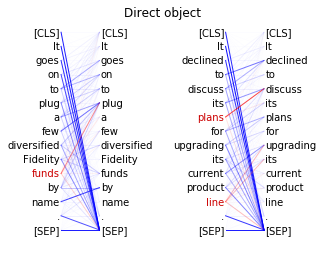

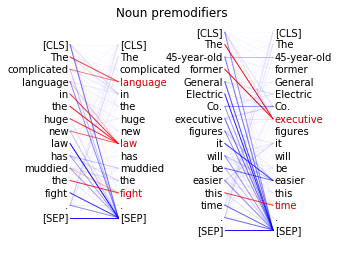

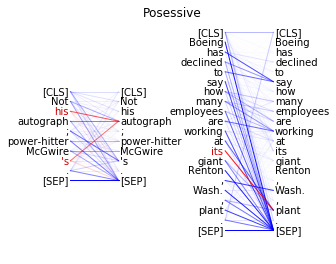

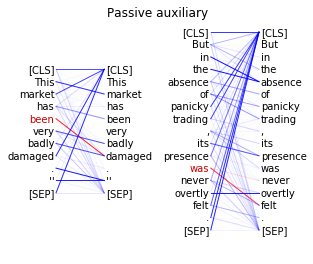

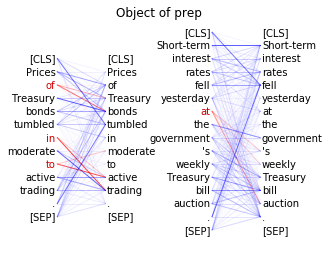

In [7]:
def plot_attn(title, examples, layer, head, color_words,
              color_from=True, width=3, example_sep=3, 
              word_height=1, pad=0.1, hide_sep=False):
    """Plot BERT's attention for a particular head/example."""
    plt.figure(figsize=(4, 4))
    for i, example in enumerate(examples):
    yoffset = 0
    if i == 0:
        yoffset += (len(examples[0]["words"]) -
                  len(examples[1]["words"])) * word_height / 2
    xoffset = i * width * example_sep
    attn = example["attns"][layer][head]
    if hide_sep:
        attn = np.array(attn)
        attn[:, 0] = 0
        attn[:, -1] = 0
        attn /= attn.sum(axis=-1, keepdims=True)

    words = ["[CLS]"] + example["words"] + ["[SEP]"]
    n_words = len(words)
    for position, word in enumerate(words):
        for x, from_word in [(xoffset, True), (xoffset + width, False)]:
            color = "k"
        if from_word == color_from and word in color_words:
            color = "#cc0000"
        plt.text(x, yoffset - (position * word_height), word,
                 ha="right" if from_word else "left", va="center",
                 color=color)

    for i in range(n_words):
        for j in range(n_words):
        color = "b"
        if words[i if color_from else j] in color_words:
            color = "r"
        plt.plot([xoffset + pad, xoffset + width - pad],
                 [yoffset - word_height * i, yoffset - word_height * j],
                 color=color, linewidth=1, alpha=attn[i, j])
    plt.axis("off")
    plt.title(title)
    plt.show()

# Examples from Figure 5 of the paper.
plot_attn("Direct object", [dev_data[42], dev_data[1286]], 7, 9, 
          ["funds", "plans", "line"], example_sep=4)
plot_attn("Noun premodifiers", [dev_data[13], dev_data[1671]], 7, 10, 
          ["language", "law", "fight", "time", "executive"], color_from=False)
plot_attn("Posessive", [dev_data[111], dev_data[244]], 6, 5,
          ["his", "'s", "its"])
plot_attn("Passive auxiliary", [dev_data[192], dev_data[680]], 3, 9,
         ["been", "was"])
plot_attn("Object of prep", [dev_data[i] for i in [975, 979]], 8, 5,
          ["in", "with", "to", "of", "at"], hide_sep=True)
#plot_attn(["PRT", dev_data[152], dev_data[1692]], 5, 6,
#          ["out", "around"])

### Probing classifiers (Section 5)

In [8]:
class WordEmbeddings(object):
  """Class for loading/using pretrained GloVe embeddings"""
    
    def __init__(self):
        self.pretrained_embeddings = load_pickle("./data/glove/embeddings.pkl")
        self.vocab = load_pickle("./data/glove/vocab.pkl")

    def tokid(self, w):
        return self.vocab.get(w.lower(), 0)

In [9]:
N_DISTANCE_FEATURES = 8
def make_distance_features(seq_len):
  """Constructs distance features for a sentence."""
  # how much ahead/behind the other word is
    distances = np.zeros((seq_len, seq_len))
    for i in range(seq_len):
        for j in range(seq_len):
            if i < j:
                distances[i, j] = (j - i) / float(seq_len)
    feature_matrices = [distances, distances.T]

  # indicator features on if other word is up to 2 words ahead/behind
  for k in range(3):
    for direction in ([1] if k == 0 else [-1, 1]):
        feature_matrices.append(np.eye(seq_len, k=k*direction))
    features = np.stack(feature_matrices)

  # additional indicator feature for ROOT
    features = np.concatenate(
    [np.zeros([N_DISTANCE_FEATURES - 1, seq_len, 1]), 
       features], -1)
    root = np.zeros((1, seq_len, seq_len + 1))
    root[:, :, 0] = 1

  return np.concatenate([features, root], 0)

In [10]:
def attn_linear_combo():
    return Probe()


def attn_and_words():
    return Probe(use_words=True)


def words_and_distances():
    return Probe(use_distance_features=True, use_attns=False,
               use_words=True, hidden_layer=True)


class Probe(object):
  """The probing classifier used in Section 5."""

  def __init__(self, use_distance_features=False, use_words=False,
               use_attns=True, include_transpose=True, hidden_layer=False):
    self._embeddings = WordEmbeddings()

    # We use a simple model with batch size 1
    self._attns = tf.placeholder(
        shape=[12, 12, None, None], dtype=tf.float32)
    self._labels = tf.placeholder(
        shape=[None], dtype=tf.int32)
    self._features = tf.placeholder(
        shape=[N_DISTANCE_FEATURES, None, None], dtype=tf.float32)
    self._words = tf.placeholder(shape=[None], dtype=tf.int32)

    if use_attns:
        seq_len = tf.shape(self._attns)[-1]
        if include_transpose:
        # Include both directions of attention
            attn_maps = tf.concat(
                [self._attns,
                 tf.transpose(self._attns, [0, 1, 3, 2])], 0)
            attn_maps = tf.reshape(attn_maps, [288, seq_len, seq_len])
        else:
            attn_maps = tf.reshape(self._attns, [144, seq_len, seq_len])
      # Use attention to start/end tokens to get score for ROOT
        root_features = (
          (tf.get_variable("ROOT_start", shape=[]) * attn_maps[:, 1:-1, 0]) +
          (tf.get_variable("ROOT_end", shape=[]) * attn_maps[:, 1:-1, -1])
      )
        attn_maps = tf.concat([tf.expand_dims(root_features, -1),
                             attn_maps[:, 1:-1, 1:-1]], -1)
    else:
      # Dummy attention map for models not using attention inputs
        n_words = tf.shape(self._words)[0]
        attn_maps = tf.zeros((1, n_words, n_words + 1))

    if use_distance_features:
        attn_maps = tf.concat([attn_maps, self._features], 0)

    if use_words:
        word_embedding_matrix = tf.get_variable(
          "word_embedding_matrix",
          initializer=self._embeddings.pretrained_embeddings,
          trainable=False)
        word_embeddings = tf.nn.embedding_lookup(word_embedding_matrix, self._words)
        n_words = tf.shape(self._words)[0]
        tiled_vertical = tf.tile(tf.expand_dims(word_embeddings, 0),
                               [n_words, 1, 1])
        tiled_horizontal = tf.tile(tf.expand_dims(word_embeddings, 1),
                                 [1, n_words, 1])
      word_reprs = tf.concat([tiled_horizontal, tiled_vertical], -1)
      word_reprs = tf.concat([word_reprs, tf.zeros((n_words, 1, 200))], 1) # dummy for ROOT
      if not use_attns:
        attn_maps = tf.concat([
            attn_maps, tf.transpose(word_reprs, [2, 0, 1])], 0)

    attn_maps = tf.transpose(attn_maps, [1, 2, 0])
    if use_words and use_attns:
      # attention-and-words probe
      weights = tf.layers.dense(word_reprs, attn_maps.shape[-1])
      self._logits = tf.reduce_sum(weights * attn_maps, axis=-1)
    else:
      if hidden_layer:
        # 1-hidden-layer MLP for words-and-distances baseline
        attn_maps = tf.layers.dense(attn_maps, 256,
                                    activation=tf.nn.tanh)
        self._logits = tf.squeeze(tf.layers.dense(attn_maps, 1), -1)
      else:
        # linear combination of attention heads
        attn_map_weights = tf.get_variable("attn_map_weights",
                                           shape=[attn_maps.shape[-1]])
        self._logits = tf.reduce_sum(attn_map_weights * attn_maps, axis=-1)

    loss = tf.reduce_sum(
        tf.nn.sparse_softmax_cross_entropy_with_logits(
            logits=self._logits, labels=self._labels))
    opt = tf.train.AdamOptimizer(learning_rate=0.002)
    self._train_op = opt.minimize(loss)

  def _create_feed_dict(self, example):
    return {
        self._attns: example["attns"],
        self._labels: example["heads"],
        self._features: make_distance_features(len(example["words"])),
        self._words: [self._embeddings.tokid(w) for w in example["words"]]
    }

  def train(self, sess, example):
    return sess.run(self._train_op, feed_dict=self._create_feed_dict(example))

  def test(self, sess, example):
    return sess.run(self._logits, feed_dict=self._create_feed_dict(example))


def run_training(probe, train_data):
  """Trains and evaluates the given attention probe."""
  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for epoch in range(1):
      print(40 * "=")
      print("EPOCH", (epoch + 1))
      print(40 * "=")
      print("Training...")
      for i, example in enumerate(train_data):
        if i % 2000 == 0:
          print("{:}/{:}".format(i, len(train_data)))
        probe.train(sess, example)

      print("Evaluating...")
      correct, total = 0, 0
      for i, example in enumerate(dev_data):
        if i % 1000 == 0:
          print("{:}/{:}".format(i, len(dev_data)))
        logits = probe.test(sess, example)
        for i, (head, prediction, reln) in enumerate(
            zip(example["heads"], logits.argmax(-1), example["relns"])):
          # it is standard to ignore punct for Stanford Dependency evaluation
          if reln != "punct":
            if head == prediction:
              correct += 1
            total += 1
      print("UAS: {:.1f}".format(100 * correct / total))

In [11]:
tf.reset_default_graph()
train_data = load_pickle("./data/depparse/train_attn.pkl")
run_training(attn_and_words(), train_data)

('EPOCH', 1)
Training...
0/36160
2000/36160
4000/36160
6000/36160
8000/36160
10000/36160
12000/36160
14000/36160
16000/36160
18000/36160
20000/36160
22000/36160
24000/36160
26000/36160
28000/36160
30000/36160
32000/36160
34000/36160
36000/36160
Evaluating...
0/1696
1000/1696
UAS: 78.0
